In [1]:
%load_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

CPython 3.5.5
IPython 6.3.0

numpy 1.14.3
sklearn 0.19.1
scipy 1.0.1
matplotlib 2.2.2
tensorflow 1.8.0


**11장 – 심층 신경망 훈련**

_이 노트북은 11장에 있는 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
import tensorflow as tf

# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8. 딥러닝

### 8.1.

_문제: He 초기화와 ELU 활성화 함수를 사용하여 각각 뉴런이 100개인 은닉층 다섯 개를 가진 DNN을 만드세요._

다음 연습문제도 비슷한 모델을 만들어야하므로 여기서 DNN을 구성하는 함수를 만들겠습니다:

In [4]:
he_init = tf.contrib.layers.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [5]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

### 8.2.

_문제: Adam 최적화와 조기 종료를 사용하여 MNIST 데이터셋에 훈련시키되 0에서 4까지의 숫자만 사용하세요. 다음 연습문제에서 5에서 9까지의 숫자에 대해 전이 학습을 사용할 것입니다. 출력층은 다섯 개의 뉴런에 소프트맥스 함수를 사용합니다. 나중에 재사용할 수 있도록 항상 일정한 간격으로 체크포인트와 최종 모델을 저장하세요._

비용 함수, 훈련 연산과 다른 필요한 구성 요소를 만듭니다:

In [6]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

MNIST 데이터셋을 로드합니다:

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)  # deprecated 경고 메세지를 출력하지 않기 위해 
mnist = input_data.read_data_sets("/tmp/data/")
tf.logging.set_verbosity(tf.logging.INFO)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


훈련 세트, 검증 세트, 테스트 세트를 만듭니다(검증 세트는 조기 종료에 사용합니다):

In [8]:
X_train1 = mnist.train.images[mnist.train.labels < 5]
y_train1 = mnist.train.labels[mnist.train.labels < 5]
X_valid1 = mnist.validation.images[mnist.validation.labels < 5]
y_valid1 = mnist.validation.labels[mnist.validation.labels < 5]
X_test1 = mnist.test.images[mnist.test.labels < 5]
y_test1 = mnist.test.labels[mnist.test.labels < 5]

In [9]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

0	검증 세트 손실: 0.142580	최선의 손실: 0.142580	정확도: 96.64%
1	검증 세트 손실: 0.136356	최선의 손실: 0.136356	정확도: 96.33%
2	검증 세트 손실: 0.105153	최선의 손실: 0.105153	정확도: 97.15%
3	검증 세트 손실: 0.110939	최선의 손실: 0.105153	정확도: 98.12%
4	검증 세트 손실: 0.315193	최선의 손실: 0.105153	정확도: 90.23%
5	검증 세트 손실: 1.352539	최선의 손실: 0.105153	정확도: 95.93%
6	검증 세트 손실: 0.404159	최선의 손실: 0.105153	정확도: 90.58%
7	검증 세트 손실: 0.478956	최선의 손실: 0.105153	정확도: 76.66%
8	검증 세트 손실: 0.296281	최선의 손실: 0.105153	정확도: 94.14%
9	검증 세트 손실: 0.474146	최선의 손실: 0.105153	정확도: 86.47%
10	검증 세트 손실: 0.272404	최선의 손실: 0.105153	정확도: 93.47%
11	검증 세트 손실: 0.262523	최선의 손실: 0.105153	정확도: 96.05%
12	검증 세트 손실: 0.228771	최선의 손실: 0.105153	정확도: 97.42%
13	검증 세트 손실: 0.240359	최선의 손실: 0.105153	정확도: 97.38%
14	검증 세트 손실: 0.234160	최선의 손실: 0.105153	정확도: 97.54%
15	검증 세트 손실: 0.334344	최선의 손실: 0.105153	정확도: 97.77%
16	검증 세트 손실: 0.286479	최선의 손실: 0.105153	정확도: 97.46%
17	검증 세트 손실: 2.433587	최선의 손실: 0.105153	정확도: 94.29%
18	검증 세트 손실: 1.035606	최선의 손실: 0.105153	정확도: 85.54%
19	검증 세트 손실: 0.272855	최선의 손실: 0.105153	정확

아주 나쁘지는 않지만 하이퍼파라미터를 튜닝하여 더 개선할 수 있을지 보겠습니다.

### 8.3.

_문제: 교차 검증을 사용하여 하이퍼파라미터를 튜닝하고 얼마의 성능을 달성할 수 있는지 확인해보세요._

하이퍼파라미터 튜닝을 하기 위해 사이킷런의 `RandomizedSearchCV` 클래스와 호환되는 `DNNClassifier` 클래스를 만듭니다. 이 클래스의 핵심은 다음과 같습니다:
* `__init__()` 메서드(생성자)는 각 하이퍼파라미터에 대한 인스턴스 변수를 만듭니다.
* `fit()` 메서드는 그래프를 만들고 세션을 시작해 모델을 훈련시킵니다:
  * `_build_graph()` 메서드를 호출해 그래프를 만듭니다(앞서 만든 그래프와 비슷합니다). 그래프가 만들어지면 다른 메서드에서 접근할 수 있도록 중요한 연산은 모두 인스턴스 변수로 저장합니다.
  * `_dnn()` 메서드는 위의 `dnn()` 함수와 비슷하게 은닉층을 만들고 배치 정규화와 드롭아웃을 추가합니다(다음 연습문제를 위해).
  * `fit()` 메서드에는 검증 세트(`X_valid`와 `y_valid`)가 주어지면 조기 종료를 실행합니다. 여기에서는 디스키 대신 메모리에 최상의 모델을 저장합니다. 이 함수는 그래프의 모든 변수와 값을 가져오기 위해 `_get_model_params()` 함수를 사용하고 (최상의 모델에서) 변수 값을 복원하기 위해 `_restore_model_params()` 함수를 사용합니다. 이런 방식은 훈련 속도를 높여 줍니다.
  * `fit()` 메서드가 모델 훈련을 마치면 예측을 만들기 위해 모델을 저장하고 복원하는 대신에 빠르게 예측을 만들기 위해 그대로 세션을 열어 둡니다. `close_session()` 메서드를 호출해 세션을 닫을 수 있습니다.
  * `predict_proba()` 메서드는 훈련 모델을 사용해 클래스 확률을 예측합니다.
  * `predict()` 메서드는 `predict_proba()`를 호출해 각 샘플에 대해 가장 높은 확률을 가진 클래스를 반환합니다.

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """모든 하이퍼파파미터를 저장하는 것으로 DNNClassifier를 초기화합니다."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """배치 정규화와 드롭아웃 기능을 넣어 은닉층을 구성합니다."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """이전과 동일한 모델을 만듭니다."""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # 중요한 연산은 인스턴스 변수로 저장하여 참조하기 쉽게 합니다.
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """모든 변수 값을 가져옵니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """모든 변수를 주어진 값으로 설정합니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """훈련 세트에 모델을 훈련시킵니다. X_valid와 y_valid가 주어지면 조기 종료를 적용합니다."""
        self.close_session()

        # 훈련 세트로부터 n_inputs와 n_outputs를 구합니다.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # 레이블 벡터를 정렬된 클래스 인덱스 벡터로 변환합니다.
        # 0부터 n_outputs - 1까지의 정수를 담고 있게 됩니다.
        # 예를 들어, y가 [8, 8, 9, 5, 7, 6, 6, 6]이면 
        # 정렬된 클래스 레이블(self.classes_)은 [5, 6, 7, 8, 9]가 되고
        # 레이블 벡터는 [3, 3, 4, 0, 2, 1, 1, 1]로 변환됩니다.
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # 배치 정규화를 위한 추가 연산
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # 조기 종료를 위해
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # 이제 모델을 훈련합니다!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("조기 종료!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\t마지막 훈련 배치 손실: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # 조기 종료를 사용하면 이전의 최상의 모델로 되돌립니다.
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("%s 객체가 아직 훈련되지 않았습니다" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

이 클래스를 사용하여 이전과 비슷한 정확도가 나오는지 확인해 보죠(드롭아웃과 배치 정규화는 사용하지 않습니다):

In [11]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.825829	최선의 손실: 0.825829	정확도: 84.36%
1	검증 세트 손실: 0.226767	최선의 손실: 0.226767	정확도: 95.39%
2	검증 세트 손실: 0.094620	최선의 손실: 0.094620	정확도: 97.50%
3	검증 세트 손실: 1.769363	최선의 손실: 0.094620	정확도: 19.08%
4	검증 세트 손실: 1.639235	최선의 손실: 0.094620	정확도: 22.01%
5	검증 세트 손실: 1.641189	최선의 손실: 0.094620	정확도: 22.01%
6	검증 세트 손실: 1.676724	최선의 손실: 0.094620	정확도: 18.73%
7	검증 세트 손실: 1.775086	최선의 손실: 0.094620	정확도: 22.01%
8	검증 세트 손실: 1.699567	최선의 손실: 0.094620	정확도: 19.27%
9	검증 세트 손실: 1.767559	최선의 손실: 0.094620	정확도: 20.91%
10	검증 세트 손실: 1.629341	최선의 손실: 0.094620	정확도: 22.01%
11	검증 세트 손실: 1.812651	최선의 손실: 0.094620	정확도: 22.01%
12	검증 세트 손실: 1.675936	최선의 손실: 0.094620	정확도: 18.73%
13	검증 세트 손실: 1.633258	최선의 손실: 0.094620	정확도: 20.91%
14	검증 세트 손실: 1.652906	최선의 손실: 0.094620	정확도: 20.91%
15	검증 세트 손실: 1.635939	최선의 손실: 0.094620	정확도: 20.91%
16	검증 세트 손실: 1.718920	최선의 손실: 0.094620	정확도: 19.08%
17	검증 세트 손실: 1.682459	최선의 손실: 0.094620	정확도: 19.27%
18	검증 세트 손실: 1.675367	최선의 손실: 0.094620	정확도: 18.73%
19	검증 세트 손실: 1.645803	최선의 손실: 0.094620	정확

DNNClassifier(activation=<function elu at 0x7f738a2bd1e0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f737fbd3d90>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

모델 훈련이 완료되면 이전과 비슷한 정확도가 나오는지 확인해 보겠습니다:

In [12]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9793734189531037

좋네요! 잘 작동합니다. 이제 사이킷런의 `RandomizedSearchCV` 클래스를 사용해서 더 나은 하이퍼파라미터를 찾아보겠습니다(시스템에 따라 이 작업은 한 시간 이상 걸릴지 모릅니다):

In [13]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # 은닉층의 수나 옵티마이저 등을 달리하여 탐색해 볼 수 있습니다.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

# 생성자에 넘겨주는 fit_params 매개변수는 사이킷런 0.19 버전부터 경고가 발생하고 0.21 버전에서 사라지므로
# 대신 fit() 메서드에 매개변수로 전달해야 합니다.:
rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] batch_size=100, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.05, n_neurons=10 
0	검증 세트 손실: 0.131358	최선의 손실: 0.131358	정확도: 96.68%
1	검증 세트 손실: 0.136887	최선의 손실: 0.131358	정확도: 96.52%
2	검증 세트 손실: 0.122056	최선의 손실: 0.122056	정확도: 96.79%
3	검증 세트 손실: 0.131960	최선의 손실: 0.122056	정확도: 96.79%
4	검증 세트 손실: 0.173777	최선의 손실: 0.122056	정확도: 95.97%
5	검증 세트 손실: 0.133734	최선의 손실: 0.122056	정확도: 96.68%
6	검증 세트 손실: 0.120576	최선의 손실: 0.120576	정확도: 96.99%
7	검증 세트 손실: 0.147677	최선의 손실: 0.120576	정확도: 96.68%
8	검증 세트 손실: 0.129115	최선의 손실: 0.120576	정확도: 96.79%
9	검증 세트 손실: 0.207614	최선의 손실: 0.120576	정확도: 95.62%
10	검증 세트 손실: 1.389598	최선의 손실: 0.120576	정확도: 34.79%
11	검증 세트 손실: 1.069314	최선의 손실: 0.120576	정확도: 38.58%
12	검증 세트 손실: 1.061086	최선의 손실: 0.120576	정확도: 39.76%
13	검증 세트 손실: 1.026689	최선의 손실: 0.120576	정확도: 39.37%
14	검증 세트 손실: 1.043682	최선의 손실: 0.120576	정확도: 40.42%
15	검증 세트 손실: 1.083720	최선의 손실: 0.120576	정확도: 40.89%
16	검증 세트 손실: 1.031031	최선의 손실: 0.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


0	검증 세트 손실: 0.160212	최선의 손실: 0.160212	정확도: 95.39%
1	검증 세트 손실: 0.152015	최선의 손실: 0.152015	정확도: 96.13%
2	검증 세트 손실: 0.116358	최선의 손실: 0.116358	정확도: 97.19%
3	검증 세트 손실: 0.212592	최선의 손실: 0.116358	정확도: 94.84%
4	검증 세트 손실: 0.118002	최선의 손실: 0.116358	정확도: 96.76%
5	검증 세트 손실: 0.153413	최선의 손실: 0.116358	정확도: 95.86%
6	검증 세트 손실: 0.134702	최선의 손실: 0.116358	정확도: 96.95%
7	검증 세트 손실: 0.140082	최선의 손실: 0.116358	정확도: 96.52%
8	검증 세트 손실: 0.165304	최선의 손실: 0.116358	정확도: 93.71%
9	검증 세트 손실: 1.620656	최선의 손실: 0.116358	정확도: 22.01%
10	검증 세트 손실: 1.609132	최선의 손실: 0.116358	정확도: 22.01%
11	검증 세트 손실: 1.632971	최선의 손실: 0.116358	정확도: 19.08%
12	검증 세트 손실: 1.628353	최선의 손실: 0.116358	정확도: 19.27%
13	검증 세트 손실: 1.625960	최선의 손실: 0.116358	정확도: 19.08%
14	검증 세트 손실: 1.614784	최선의 손실: 0.116358	정확도: 22.01%
15	검증 세트 손실: 1.614323	최선의 손실: 0.116358	정확도: 22.01%
16	검증 세트 손실: 1.620646	최선의 손실: 0.116358	정확도: 22.01%
17	검증 세트 손실: 1.613835	최선의 손실: 0.116358	정확도: 20.91%
18	검증 세트 손실: 1.612884	최선의 손실: 0.116358	정확도: 22.01%
19	검증 세트 손실: 1.610178	최선의 손실: 0.116358	정확

29	검증 세트 손실: 0.105981	최선의 손실: 0.062149	정확도: 98.05%
30	검증 세트 손실: 0.100353	최선의 손실: 0.062149	정확도: 97.97%
31	검증 세트 손실: 0.106992	최선의 손실: 0.062149	정확도: 98.05%
32	검증 세트 손실: 0.079171	최선의 손실: 0.062149	정확도: 98.12%
33	검증 세트 손실: 0.091985	최선의 손실: 0.062149	정확도: 98.05%
34	검증 세트 손실: 0.093240	최선의 손실: 0.062149	정확도: 98.36%
35	검증 세트 손실: 0.088248	최선의 손실: 0.062149	정확도: 98.44%
36	검증 세트 손실: 0.108965	최선의 손실: 0.062149	정확도: 98.16%
조기 종료!
[CV]  batch_size=500, activation=<function relu at 0x7f738a2ee510>, learning_rate=0.02, n_neurons=30, total=   2.8s
[CV] batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f737fb55048>, learning_rate=0.05, n_neurons=90 
0	검증 세트 손실: 4959.016602	최선의 손실: 4959.016602	정확도: 58.95%
1	검증 세트 손실: 5.446846	최선의 손실: 5.446846	정확도: 65.68%
2	검증 세트 손실: 1392.261108	최선의 손실: 5.446846	정확도: 39.21%
3	검증 세트 손실: 68.069595	최선의 손실: 5.446846	정확도: 76.94%
4	검증 세트 손실: 27.544319	최선의 손실: 5.446846	정확도: 81.16%
5	검증 세트 손실: 12.511521	최선의 손실: 5.446846	정확도: 88.19%
6	검증 세트 손실: 16.485

14	검증 세트 손실: 94.236565	최선의 손실: 24.346964	정확도: 96.01%
15	검증 세트 손실: 158.345917	최선의 손실: 24.346964	정확도: 93.16%
16	검증 세트 손실: 162.887070	최선의 손실: 24.346964	정확도: 93.00%
17	검증 세트 손실: 97.908829	최선의 손실: 24.346964	정확도: 96.17%
18	검증 세트 손실: 368280.000000	최선의 손실: 24.346964	정확도: 85.07%
19	검증 세트 손실: 31994.333984	최선의 손실: 24.346964	정확도: 93.94%
20	검증 세트 손실: 20165.306641	최선의 손실: 24.346964	정확도: 94.49%
21	검증 세트 손실: 16833.039062	최선의 손실: 24.346964	정확도: 95.62%
22	검증 세트 손실: 13721.860352	최선의 손실: 24.346964	정확도: 94.64%
23	검증 세트 손실: 8218.649414	최선의 손실: 24.346964	정확도: 94.45%
24	검증 세트 손실: 42806.761719	최선의 손실: 24.346964	정확도: 93.59%
25	검증 세트 손실: 6759.045898	최선의 손실: 24.346964	정확도: 96.25%
26	검증 세트 손실: 4524.816895	최선의 손실: 24.346964	정확도: 96.36%
27	검증 세트 손실: 4394.646973	최선의 손실: 24.346964	정확도: 96.21%
28	검증 세트 손실: 5590.129883	최선의 손실: 24.346964	정확도: 95.70%
29	검증 세트 손실: 28643.064453	최선의 손실: 24.346964	정확도: 91.48%
30	검증 세트 손실: 7282.187012	최선의 손실: 24.346964	정확도: 96.99%
조기 종료!
[CV]  batch_size=50, activation=<function leaky_relu.<lo

[CV]  batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f737fb55048>, learning_rate=0.01, n_neurons=120, total=   3.0s
[CV] batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f737fb55048>, learning_rate=0.01, n_neurons=90 
0	검증 세트 손실: 0.104860	최선의 손실: 0.104860	정확도: 96.83%
1	검증 세트 손실: 0.063637	최선의 손실: 0.063637	정확도: 98.01%
2	검증 세트 손실: 0.056582	최선의 손실: 0.056582	정확도: 98.16%
3	검증 세트 손실: 0.075052	최선의 손실: 0.056582	정확도: 98.05%
4	검증 세트 손실: 0.057609	최선의 손실: 0.056582	정확도: 98.01%
5	검증 세트 손실: 0.045507	최선의 손실: 0.045507	정확도: 98.48%
6	검증 세트 손실: 0.049195	최선의 손실: 0.045507	정확도: 98.51%
7	검증 세트 손실: 0.069034	최선의 손실: 0.045507	정확도: 98.36%
8	검증 세트 손실: 0.049007	최선의 손실: 0.045507	정확도: 98.71%
9	검증 세트 손실: 0.052319	최선의 손실: 0.045507	정확도: 98.36%
10	검증 세트 손실: 0.043772	최선의 손실: 0.043772	정확도: 98.91%
11	검증 세트 손실: 0.045685	최선의 손실: 0.043772	정확도: 98.91%
12	검증 세트 손실: 0.056483	최선의 손실: 0.043772	정확도: 98.87%
13	검증 세트 손실: 0.044548	최선의 손실: 0.043772	정확도: 99.02%


0	검증 세트 손실: 0.127971	최선의 손실: 0.127971	정확도: 95.93%
1	검증 세트 손실: 0.076743	최선의 손실: 0.076743	정확도: 97.73%
2	검증 세트 손실: 0.059686	최선의 손실: 0.059686	정확도: 98.16%
3	검증 세트 손실: 0.055500	최선의 손실: 0.055500	정확도: 98.40%
4	검증 세트 손실: 0.049846	최선의 손실: 0.049846	정확도: 98.36%
5	검증 세트 손실: 0.050812	최선의 손실: 0.049846	정확도: 98.44%
6	검증 세트 손실: 0.036367	최선의 손실: 0.036367	정확도: 98.91%
7	검증 세트 손실: 0.040803	최선의 손실: 0.036367	정확도: 98.67%
8	검증 세트 손실: 0.055379	최선의 손실: 0.036367	정확도: 98.44%
9	검증 세트 손실: 0.053489	최선의 손실: 0.036367	정확도: 98.48%
10	검증 세트 손실: 0.054987	최선의 손실: 0.036367	정확도: 98.51%
11	검증 세트 손실: 0.060149	최선의 손실: 0.036367	정확도: 98.44%
12	검증 세트 손실: 0.047267	최선의 손실: 0.036367	정확도: 98.83%
13	검증 세트 손실: 0.053801	최선의 손실: 0.036367	정확도: 98.87%
14	검증 세트 손실: 0.049535	최선의 손실: 0.036367	정확도: 98.91%
15	검증 세트 손실: 0.043959	최선의 손실: 0.036367	정확도: 99.10%
16	검증 세트 손실: 0.059245	최선의 손실: 0.036367	정확도: 98.67%
17	검증 세트 손실: 0.053413	최선의 손실: 0.036367	정확도: 98.75%
18	검증 세트 손실: 0.072318	최선의 손실: 0.036367	정확도: 98.67%
19	검증 세트 손실: 0.055238	최선의 손실: 0.036367	정확

23	검증 세트 손실: 1.647554	최선의 손실: 1.609592	정확도: 22.01%
24	검증 세트 손실: 1.652203	최선의 손실: 1.609592	정확도: 18.73%
25	검증 세트 손실: 1.610976	최선의 손실: 1.609592	정확도: 20.91%
26	검증 세트 손실: 1.614099	최선의 손실: 1.609592	정확도: 20.91%
27	검증 세트 손실: 1.614368	최선의 손실: 1.609592	정확도: 20.91%
28	검증 세트 손실: 1.642985	최선의 손실: 1.609592	정확도: 19.08%
29	검증 세트 손실: 1.614041	최선의 손실: 1.609592	정확도: 19.08%
30	검증 세트 손실: 1.609285	최선의 손실: 1.609285	정확도: 22.01%
31	검증 세트 손실: 1.634891	최선의 손실: 1.609285	정확도: 18.73%
32	검증 세트 손실: 1.614004	최선의 손실: 1.609285	정확도: 19.08%
33	검증 세트 손실: 1.619316	최선의 손실: 1.609285	정확도: 19.08%
34	검증 세트 손실: 1.611677	최선의 손실: 1.609285	정확도: 22.01%
35	검증 세트 손실: 1.638077	최선의 손실: 1.609285	정확도: 20.91%
36	검증 세트 손실: 1.621401	최선의 손실: 1.609285	정확도: 22.01%
37	검증 세트 손실: 1.617569	최선의 손실: 1.609285	정확도: 22.01%
38	검증 세트 손실: 1.620771	최선의 손실: 1.609285	정확도: 20.91%
39	검증 세트 손실: 1.627337	최선의 손실: 1.609285	정확도: 19.27%
40	검증 세트 손실: 1.607884	최선의 손실: 1.607884	정확도: 22.01%
41	검증 세트 손실: 1.634035	최선의 손실: 1.607884	정확도: 22.01%
42	검증 세트 손실: 1.618333	최선의 손실: 1

26	검증 세트 손실: 0.108104	최선의 손실: 0.067963	정확도: 97.85%
27	검증 세트 손실: 0.219004	최선의 손실: 0.067963	정확도: 97.07%
28	검증 세트 손실: 0.108362	최선의 손실: 0.067963	정확도: 97.77%
29	검증 세트 손실: 0.098935	최선의 손실: 0.067963	정확도: 97.89%
30	검증 세트 손실: 0.100086	최선의 손실: 0.067963	정확도: 97.54%
31	검증 세트 손실: 0.091291	최선의 손실: 0.067963	정확도: 98.24%
32	검증 세트 손실: 0.371474	최선의 손실: 0.067963	정확도: 98.32%
33	검증 세트 손실: 0.111307	최선의 손실: 0.067963	정확도: 97.54%
조기 종료!
[CV]  batch_size=100, activation=<function relu at 0x7f738a2ee510>, learning_rate=0.02, n_neurons=30, total=   6.4s
[CV] batch_size=100, activation=<function relu at 0x7f738a2ee510>, learning_rate=0.02, n_neurons=30 
0	검증 세트 손실: 0.089817	최선의 손실: 0.089817	정확도: 97.65%
1	검증 세트 손실: 0.099206	최선의 손실: 0.089817	정확도: 97.30%
2	검증 세트 손실: 0.093683	최선의 손실: 0.089817	정확도: 97.46%
3	검증 세트 손실: 0.093219	최선의 손실: 0.089817	정확도: 97.54%
4	검증 세트 손실: 0.081220	최선의 손실: 0.081220	정확도: 97.77%
5	검증 세트 손실: 0.085970	최선의 손실: 0.081220	정확도: 97.77%
6	검증 세트 손실: 0.097083	최선의 손실: 0.081220	정확도: 96.95%
7	검증 세트 손실: 0.0934

0	검증 세트 손실: 0.121137	최선의 손실: 0.121137	정확도: 97.30%
1	검증 세트 손실: 0.070906	최선의 손실: 0.070906	정확도: 98.08%
2	검증 세트 손실: 0.085365	최선의 손실: 0.070906	정확도: 97.69%
3	검증 세트 손실: 0.085952	최선의 손실: 0.070906	정확도: 97.73%
4	검증 세트 손실: 0.095008	최선의 손실: 0.070906	정확도: 97.97%
5	검증 세트 손실: 0.057167	최선의 손실: 0.057167	정확도: 98.55%
6	검증 세트 손실: 0.144764	최선의 손실: 0.057167	정확도: 97.30%
7	검증 세트 손실: 0.217731	최선의 손실: 0.057167	정확도: 96.17%
8	검증 세트 손실: 0.090277	최선의 손실: 0.057167	정확도: 97.62%
9	검증 세트 손실: 0.090789	최선의 손실: 0.057167	정확도: 97.62%
10	검증 세트 손실: 0.095652	최선의 손실: 0.057167	정확도: 98.08%
11	검증 세트 손실: 0.073820	최선의 손실: 0.057167	정확도: 98.40%
12	검증 세트 손실: 0.110818	최선의 손실: 0.057167	정확도: 98.05%
13	검증 세트 손실: 0.100247	최선의 손실: 0.057167	정확도: 97.73%
14	검증 세트 손실: 0.099558	최선의 손실: 0.057167	정확도: 98.05%
15	검증 세트 손실: 0.126182	최선의 손실: 0.057167	정확도: 97.77%
16	검증 세트 손실: 0.072048	최선의 손실: 0.057167	정확도: 98.05%
17	검증 세트 손실: 0.099430	최선의 손실: 0.057167	정확도: 98.24%
18	검증 세트 손실: 0.131276	최선의 손실: 0.057167	정확도: 98.12%
19	검증 세트 손실: 4.010344	최선의 손실: 0.057167	정확

9	검증 세트 손실: 526.303162	최선의 손실: 2.861630	정확도: 96.21%
10	검증 세트 손실: 558.767883	최선의 손실: 2.861630	정확도: 94.25%
11	검증 세트 손실: 1046.698486	최선의 손실: 2.861630	정확도: 96.17%
12	검증 세트 손실: 445.640015	최선의 손실: 2.861630	정확도: 95.82%
13	검증 세트 손실: 650.660645	최선의 손실: 2.861630	정확도: 96.29%
14	검증 세트 손실: 633.673401	최선의 손실: 2.861630	정확도: 96.99%
15	검증 세트 손실: 4291.384766	최선의 손실: 2.861630	정확도: 96.56%
16	검증 세트 손실: 1141.078003	최선의 손실: 2.861630	정확도: 96.99%
17	검증 세트 손실: 1373.047363	최선의 손실: 2.861630	정확도: 97.46%
18	검증 세트 손실: 3618.889404	최선의 손실: 2.861630	정확도: 96.64%
19	검증 세트 손실: 3446.796387	최선의 손실: 2.861630	정확도: 95.35%
20	검증 세트 손실: 2572.293701	최선의 손실: 2.861630	정확도: 96.95%
21	검증 세트 손실: 2632.004395	최선의 손실: 2.861630	정확도: 96.76%
조기 종료!
[CV]  batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f736d745d08>, learning_rate=0.02, n_neurons=120, total=  52.5s
[CV] batch_size=500, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.1, n_neurons=50 
0	검증 세트 손실: 1.806977	최선의 손실: 1.806977	정확도: 

28	검증 세트 손실: 1.631046	최선의 손실: 0.124415	정확도: 18.73%
29	검증 세트 손실: 1.618762	최선의 손실: 0.124415	정확도: 22.01%
30	검증 세트 손실: 1.615479	최선의 손실: 0.124415	정확도: 20.91%
31	검증 세트 손실: 1.616488	최선의 손실: 0.124415	정확도: 22.01%
32	검증 세트 손실: 1.610171	최선의 손실: 0.124415	정확도: 22.01%
33	검증 세트 손실: 1.623160	최선의 손실: 0.124415	정확도: 19.08%
34	검증 세트 손실: 1.627331	최선의 손실: 0.124415	정확도: 20.91%
35	검증 세트 손실: 1.627435	최선의 손실: 0.124415	정확도: 19.27%
36	검증 세트 손실: 1.618342	최선의 손실: 0.124415	정확도: 19.27%
조기 종료!
[CV]  batch_size=500, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.1, n_neurons=50, total=   3.0s
[CV] batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f737fb55048>, learning_rate=0.1, n_neurons=100 
0	검증 세트 손실: 6.036595	최선의 손실: 6.036595	정확도: 69.59%
1	검증 세트 손실: 2.043573	최선의 손실: 2.043573	정확도: 72.87%
2	검증 세트 손실: 0.484242	최선의 손실: 0.484242	정확도: 87.65%
3	검증 세트 손실: 1.541157	최선의 손실: 0.484242	정확도: 73.81%
4	검증 세트 손실: 699320.437500	최선의 손실: 0.484242	정확도: 19.27%
5	검증 세트 손실: 90903.320312	최

15	검증 세트 손실: 10705.510742	최선의 손실: 0.121361	정확도: 92.06%
16	검증 세트 손실: 5004.265137	최선의 손실: 0.121361	정확도: 95.39%
17	검증 세트 손실: 5891.799805	최선의 손실: 0.121361	정확도: 95.62%
18	검증 세트 손실: 3836.821777	최선의 손실: 0.121361	정확도: 96.48%
19	검증 세트 손실: 3843.629883	최선의 손실: 0.121361	정확도: 96.83%
20	검증 세트 손실: 2667.820312	최선의 손실: 0.121361	정확도: 96.83%
21	검증 세트 손실: 3475.297852	최선의 손실: 0.121361	정확도: 95.58%
22	검증 세트 손실: 2551.543701	최선의 손실: 0.121361	정확도: 96.05%
23	검증 세트 손실: 3031.558594	최선의 손실: 0.121361	정확도: 95.23%
24	검증 세트 손실: 1891.486084	최선의 손실: 0.121361	정확도: 97.19%
25	검증 세트 손실: 2338.679932	최선의 손실: 0.121361	정확도: 96.64%
26	검증 세트 손실: 2014.508545	최선의 손실: 0.121361	정확도: 95.66%
27	검증 세트 손실: 2405.554443	최선의 손실: 0.121361	정확도: 96.60%
28	검증 세트 손실: 3458.688477	최선의 손실: 0.121361	정확도: 94.64%
29	검증 세트 손실: 17461.615234	최선의 손실: 0.121361	정확도: 94.06%
30	검증 세트 손실: 2813.408203	최선의 손실: 0.121361	정확도: 96.17%
31	검증 세트 손실: 5106.535156	최선의 손실: 0.121361	정확도: 93.20%
32	검증 세트 손실: 5045.147949	최선의 손실: 0.121361	정확도: 93.59%
조기 종료!
[CV]  batch_size=10

24	검증 세트 손실: 2.497146	최선의 손실: 1.700590	정확도: 19.27%
25	검증 세트 손실: 1.703904	최선의 손실: 1.700590	정확도: 22.01%
26	검증 세트 손실: 2.280939	최선의 손실: 1.700590	정확도: 18.73%
27	검증 세트 손실: 1.996808	최선의 손실: 1.700590	정확도: 18.73%
28	검증 세트 손실: 2.451432	최선의 손실: 1.700590	정확도: 19.08%
29	검증 세트 손실: 2.785381	최선의 손실: 1.700590	정확도: 20.91%
조기 종료!
[CV]  batch_size=10, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.05, n_neurons=100, total=  47.2s
[CV] batch_size=500, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.02, n_neurons=90 
0	검증 세트 손실: 0.146550	최선의 손실: 0.146550	정확도: 94.84%
1	검증 세트 손실: 0.094867	최선의 손실: 0.094867	정확도: 96.87%
2	검증 세트 손실: 0.095423	최선의 손실: 0.094867	정확도: 96.56%
3	검증 세트 손실: 0.064081	최선의 손실: 0.064081	정확도: 98.05%
4	검증 세트 손실: 0.064736	최선의 손실: 0.064081	정확도: 97.89%
5	검증 세트 손실: 0.066322	최선의 손실: 0.064081	정확도: 97.89%
6	검증 세트 손실: 0.063930	최선의 손실: 0.063930	정확도: 98.12%
7	검증 세트 손실: 0.064293	최선의 손실: 0.063930	정확도: 98.08%
8	검증 세트 손실: 0.055577	최선의 손실: 0.055577	정확도: 98.36%
9	검증 세트 손실: 0.058049	최

11	검증 세트 손실: 1.582595	최선의 손실: 0.170579	정확도: 23.65%
12	검증 세트 손실: 1.580916	최선의 손실: 0.170579	정확도: 23.65%
13	검증 세트 손실: 1.583850	최선의 손실: 0.170579	정확도: 20.91%
14	검증 세트 손실: 1.581269	최선의 손실: 0.170579	정확도: 23.65%
15	검증 세트 손실: 1.581416	최선의 손실: 0.170579	정확도: 23.65%
16	검증 세트 손실: 1.585085	최선의 손실: 0.170579	정확도: 23.65%
17	검증 세트 손실: 1.587295	최선의 손실: 0.170579	정확도: 20.72%
18	검증 세트 손실: 1.582088	최선의 손실: 0.170579	정확도: 23.65%
19	검증 세트 손실: 1.270253	최선의 손실: 0.170579	정확도: 39.56%
20	검증 세트 손실: 1.575266	최선의 손실: 0.170579	정확도: 24.32%
21	검증 세트 손실: 1.576395	최선의 손실: 0.170579	정확도: 24.32%
조기 종료!
[CV]  batch_size=50, activation=<function relu at 0x7f738a2ee510>, learning_rate=0.05, n_neurons=30, total=   7.9s
[CV] batch_size=50, activation=<function relu at 0x7f738a2ee510>, learning_rate=0.05, n_neurons=30 
0	검증 세트 손실: 0.213169	최선의 손실: 0.213169	정확도: 95.50%
1	검증 세트 손실: 0.517129	최선의 손실: 0.213169	정확도: 74.75%
2	검증 세트 손실: 1.409116	최선의 손실: 0.213169	정확도: 34.40%
3	검증 세트 손실: 1.311955	최선의 손실: 0.213169	정확도: 35.38%
4	검증 세트 손실: 1.265

5	검증 세트 손실: 0.185205	최선의 손실: 0.124966	정확도: 95.86%
6	검증 세트 손실: 0.151646	최선의 손실: 0.124966	정확도: 96.40%
7	검증 세트 손실: 0.164112	최선의 손실: 0.124966	정확도: 96.29%
8	검증 세트 손실: 0.683742	최선의 손실: 0.124966	정확도: 78.81%
9	검증 세트 손실: 1.137868	최선의 손실: 0.124966	정확도: 47.46%
10	검증 세트 손실: 0.245956	최선의 손실: 0.124966	정확도: 92.65%
11	검증 세트 손실: 0.459690	최선의 손실: 0.124966	정확도: 80.30%
12	검증 세트 손실: 1.955078	최선의 손실: 0.124966	정확도: 91.52%
13	검증 세트 손실: 0.582435	최선의 손실: 0.124966	정확도: 73.85%
14	검증 세트 손실: 0.520729	최선의 손실: 0.124966	정확도: 77.83%
15	검증 세트 손실: 0.762683	최선의 손실: 0.124966	정확도: 71.70%
16	검증 세트 손실: 0.591740	최선의 손실: 0.124966	정확도: 74.28%
17	검증 세트 손실: 1.212704	최선의 손실: 0.124966	정확도: 45.97%
18	검증 세트 손실: 0.785290	최선의 손실: 0.124966	정확도: 70.68%
19	검증 세트 손실: 0.664190	최선의 손실: 0.124966	정확도: 68.53%
20	검증 세트 손실: 0.903928	최선의 손실: 0.124966	정확도: 56.84%
21	검증 세트 손실: 1.120231	최선의 손실: 0.124966	정확도: 54.10%
22	검증 세트 손실: 1.421821	최선의 손실: 0.124966	정확도: 57.43%
23	검증 세트 손실: 1.060686	최선의 손실: 0.124966	정확도: 53.99%
조기 종료!
[CV]  batch_size=10, activati

15	검증 세트 손실: 0.093466	최선의 손실: 0.079665	정확도: 97.54%
16	검증 세트 손실: 0.079792	최선의 손실: 0.079665	정확도: 97.89%
17	검증 세트 손실: 0.109453	최선의 손실: 0.079665	정확도: 97.38%
18	검증 세트 손실: 0.080300	최선의 손실: 0.079665	정확도: 98.24%
19	검증 세트 손실: 0.110411	최선의 손실: 0.079665	정확도: 97.46%
20	검증 세트 손실: 0.075459	최선의 손실: 0.075459	정확도: 97.85%
21	검증 세트 손실: 0.074641	최선의 손실: 0.074641	정확도: 98.32%
22	검증 세트 손실: 0.062378	최선의 손실: 0.062378	정확도: 98.24%
23	검증 세트 손실: 0.068209	최선의 손실: 0.062378	정확도: 98.32%
24	검증 세트 손실: 0.076480	최선의 손실: 0.062378	정확도: 98.08%
25	검증 세트 손실: 0.087372	최선의 손실: 0.062378	정확도: 98.28%
26	검증 세트 손실: 0.120130	최선의 손실: 0.062378	정확도: 97.58%
27	검증 세트 손실: 0.078843	최선의 손실: 0.062378	정확도: 98.24%
28	검증 세트 손실: 0.066052	최선의 손실: 0.062378	정확도: 98.51%
29	검증 세트 손실: 0.077615	최선의 손실: 0.062378	정확도: 98.28%
30	검증 세트 손실: 0.086158	최선의 손실: 0.062378	정확도: 98.28%
31	검증 세트 손실: 0.138006	최선의 손실: 0.062378	정확도: 98.16%
32	검증 세트 손실: 0.125814	최선의 손실: 0.062378	정확도: 98.28%
33	검증 세트 손실: 0.105276	최선의 손실: 0.062378	정확도: 98.20%
34	검증 세트 손실: 0.423094	최선의 손실: 0

9	검증 세트 손실: 0.087827	최선의 손실: 0.087827	정확도: 97.58%
10	검증 세트 손실: 0.094932	최선의 손실: 0.087827	정확도: 97.19%
11	검증 세트 손실: 0.112793	최선의 손실: 0.087827	정확도: 96.83%
12	검증 세트 손실: 0.084992	최선의 손실: 0.084992	정확도: 97.62%
13	검증 세트 손실: 0.101290	최선의 손실: 0.084992	정확도: 97.03%
14	검증 세트 손실: 0.095391	최선의 손실: 0.084992	정확도: 97.46%
15	검증 세트 손실: 0.089654	최선의 손실: 0.084992	정확도: 97.50%
16	검증 세트 손실: 0.083526	최선의 손실: 0.083526	정확도: 97.89%
17	검증 세트 손실: 0.104814	최선의 손실: 0.083526	정확도: 97.42%
18	검증 세트 손실: 0.105825	최선의 손실: 0.083526	정확도: 97.54%
19	검증 세트 손실: 0.106660	최선의 손실: 0.083526	정확도: 97.15%
20	검증 세트 손실: 0.110320	최선의 손실: 0.083526	정확도: 97.26%
21	검증 세트 손실: 0.093945	최선의 손실: 0.083526	정확도: 97.69%
22	검증 세트 손실: 0.101414	최선의 손실: 0.083526	정확도: 97.69%
23	검증 세트 손실: 0.125447	최선의 손실: 0.083526	정확도: 97.19%
24	검증 세트 손실: 0.100788	최선의 손실: 0.083526	정확도: 97.50%
25	검증 세트 손실: 0.127719	최선의 손실: 0.083526	정확도: 97.22%
26	검증 세트 손실: 0.136075	최선의 손실: 0.083526	정확도: 97.46%
27	검증 세트 손실: 0.124739	최선의 손실: 0.083526	정확도: 97.26%
28	검증 세트 손실: 0.107940	최선의 손실: 0.

4	검증 세트 손실: 0.092688	최선의 손실: 0.070908	정확도: 98.01%
5	검증 세트 손실: 0.065849	최선의 손실: 0.065849	정확도: 98.40%
6	검증 세트 손실: 0.049691	최선의 손실: 0.049691	정확도: 98.59%
7	검증 세트 손실: 0.083899	최선의 손실: 0.049691	정확도: 97.77%
8	검증 세트 손실: 0.128899	최선의 손실: 0.049691	정확도: 97.97%
9	검증 세트 손실: 1.060302	최선의 손실: 0.049691	정확도: 77.25%
10	검증 세트 손실: 1.609462	최선의 손실: 0.049691	정확도: 22.01%
11	검증 세트 손실: 1.622200	최선의 손실: 0.049691	정확도: 19.27%
12	검증 세트 손실: 1.622142	최선의 손실: 0.049691	정확도: 19.27%
13	검증 세트 손실: 1.638234	최선의 손실: 0.049691	정확도: 18.73%
14	검증 세트 손실: 1.632090	최선의 손실: 0.049691	정확도: 20.91%
15	검증 세트 손실: 1.627630	최선의 손실: 0.049691	정확도: 19.08%
16	검증 세트 손실: 1.631667	최선의 손실: 0.049691	정확도: 19.27%
17	검증 세트 손실: 1.652224	최선의 손실: 0.049691	정확도: 20.91%
18	검증 세트 손실: 1.670237	최선의 손실: 0.049691	정확도: 22.01%
19	검증 세트 손실: 1.639060	최선의 손실: 0.049691	정확도: 20.91%
20	검증 세트 손실: 1.627109	최선의 손실: 0.049691	정확도: 18.73%
21	검증 세트 손실: 1.689527	최선의 손실: 0.049691	정확도: 22.01%
22	검증 세트 손실: 1.646617	최선의 손실: 0.049691	정확도: 19.27%
23	검증 세트 손실: 1.669662	최선의 손실: 0.04969

12	검증 세트 손실: 2.193029	최선의 손실: 1.897247	정확도: 22.01%
13	검증 세트 손실: 2.432747	최선의 손실: 1.897247	정확도: 22.01%
14	검증 세트 손실: 2.763578	최선의 손실: 1.897247	정확도: 22.01%
15	검증 세트 손실: 2.097944	최선의 손실: 1.897247	정확도: 22.01%
16	검증 세트 손실: 3.267366	최선의 손실: 1.897247	정확도: 20.91%
17	검증 세트 손실: 2.947588	최선의 손실: 1.897247	정확도: 20.91%
18	검증 세트 손실: 3.994301	최선의 손실: 1.897247	정확도: 22.01%
19	검증 세트 손실: 4.488717	최선의 손실: 1.897247	정확도: 22.01%
20	검증 세트 손실: 2.885106	최선의 손실: 1.897247	정확도: 20.91%
21	검증 세트 손실: 2.420197	최선의 손실: 1.897247	정확도: 20.91%
22	검증 세트 손실: 1.643378	최선의 손실: 1.643378	정확도: 18.73%
23	검증 세트 손실: 1.877509	최선의 손실: 1.643378	정확도: 19.08%
24	검증 세트 손실: 2.305290	최선의 손실: 1.643378	정확도: 20.91%
25	검증 세트 손실: 2.186714	최선의 손실: 1.643378	정확도: 19.08%
26	검증 세트 손실: 2.791283	최선의 손실: 1.643378	정확도: 20.91%
27	검증 세트 손실: 3.082478	최선의 손실: 1.643378	정확도: 22.01%
28	검증 세트 손실: 3.760586	최선의 손실: 1.643378	정확도: 18.73%
29	검증 세트 손실: 3.059407	최선의 손실: 1.643378	정확도: 19.08%
30	검증 세트 손실: 2.367162	최선의 손실: 1.643378	정확도: 22.01%
31	검증 세트 손실: 2.324404	최선의 손실: 1

6	검증 세트 손실: 1.612779	최선의 손실: 1.610373	정확도: 22.01%
7	검증 세트 손실: 1.654525	최선의 손실: 1.610373	정확도: 22.01%
8	검증 세트 손실: 1.659124	최선의 손실: 1.610373	정확도: 18.73%
9	검증 세트 손실: 1.686131	최선의 손실: 1.610373	정확도: 19.27%
10	검증 세트 손실: 1.633308	최선의 손실: 1.610373	정확도: 22.01%
11	검증 세트 손실: 1.654168	최선의 손실: 1.610373	정확도: 19.27%
12	검증 세트 손실: 1.624906	최선의 손실: 1.610373	정확도: 20.91%
13	검증 세트 손실: 1.680345	최선의 손실: 1.610373	정확도: 19.08%
14	검증 세트 손실: 1.644989	최선의 손실: 1.610373	정확도: 18.73%
15	검증 세트 손실: 1.653713	최선의 손실: 1.610373	정확도: 18.73%
16	검증 세트 손실: 1.729175	최선의 손실: 1.610373	정확도: 22.01%
17	검증 세트 손실: 1.625388	최선의 손실: 1.610373	정확도: 22.01%
18	검증 세트 손실: 1.632917	최선의 손실: 1.610373	정확도: 22.01%
19	검증 세트 손실: 1.657624	최선의 손실: 1.610373	정확도: 19.27%
20	검증 세트 손실: 1.648483	최선의 손실: 1.610373	정확도: 22.01%
21	검증 세트 손실: 2.145180	최선의 손실: 1.610373	정확도: 22.01%
조기 종료!
[CV]  batch_size=100, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.1, n_neurons=90, total=   4.4s
[CV] batch_size=500, activation=<function leaky_relu.<locals>.param

[CV]  batch_size=500, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.02, n_neurons=140, total=   2.9s
[CV] batch_size=500, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.02, n_neurons=140 
0	검증 세트 손실: 0.197067	최선의 손실: 0.197067	정확도: 94.18%
1	검증 세트 손실: 0.106381	최선의 손실: 0.106381	정확도: 96.44%
2	검증 세트 손실: 0.091681	최선의 손실: 0.091681	정확도: 97.07%
3	검증 세트 손실: 0.074427	최선의 손실: 0.074427	정확도: 97.81%
4	검증 세트 손실: 0.068278	최선의 손실: 0.068278	정확도: 97.93%
5	검증 세트 손실: 0.061890	최선의 손실: 0.061890	정확도: 98.12%
6	검증 세트 손실: 0.055001	최선의 손실: 0.055001	정확도: 98.20%
7	검증 세트 손실: 0.054396	최선의 손실: 0.054396	정확도: 98.40%
8	검증 세트 손실: 0.081775	최선의 손실: 0.054396	정확도: 97.89%
9	검증 세트 손실: 0.049693	최선의 손실: 0.049693	정확도: 98.51%
10	검증 세트 손실: 0.062691	최선의 손실: 0.049693	정확도: 98.44%
11	검증 세트 손실: 0.048321	최선의 손실: 0.048321	정확도: 98.55%
12	검증 세트 손실: 0.053928	최선의 손실: 0.048321	정확도: 98.40%
13	검증 세트 손실: 0.045204	최선의 손실: 0.045204	정확도: 98.71%
14	검증 세트 손실: 0.047268	최선의 손실: 0.045204	정확도: 98.87%
15	검증 세트 손실: 0.065757	최선의 손실

10	검증 세트 손실: 0.078914	최선의 손실: 0.058201	정확도: 98.16%
11	검증 세트 손실: 0.065126	최선의 손실: 0.058201	정확도: 98.40%
12	검증 세트 손실: 0.084432	최선의 손실: 0.058201	정확도: 97.69%
13	검증 세트 손실: 0.077058	최선의 손실: 0.058201	정확도: 98.55%
14	검증 세트 손실: 0.092233	최선의 손실: 0.058201	정확도: 98.20%
15	검증 세트 손실: 0.090472	최선의 손실: 0.058201	정확도: 98.32%
16	검증 세트 손실: 0.105631	최선의 손실: 0.058201	정확도: 97.81%
17	검증 세트 손실: 0.082115	최선의 손실: 0.058201	정확도: 98.75%
18	검증 세트 손실: 0.085675	최선의 손실: 0.058201	정확도: 98.48%
19	검증 세트 손실: 0.075742	최선의 손실: 0.058201	정확도: 98.79%
20	검증 세트 손실: 0.069197	최선의 손실: 0.058201	정확도: 98.48%
21	검증 세트 손실: 0.077932	최선의 손실: 0.058201	정확도: 98.55%
22	검증 세트 손실: 0.083667	최선의 손실: 0.058201	정확도: 98.36%
23	검증 세트 손실: 0.076434	최선의 손실: 0.058201	정확도: 98.32%
24	검증 세트 손실: 0.105803	최선의 손실: 0.058201	정확도: 98.28%
25	검증 세트 손실: 0.092556	최선의 손실: 0.058201	정확도: 98.40%
26	검증 세트 손실: 0.109842	최선의 손실: 0.058201	정확도: 97.93%
27	검증 세트 손실: 0.086381	최선의 손실: 0.058201	정확도: 98.59%
28	검증 세트 손실: 0.081117	최선의 손실: 0.058201	정확도: 98.67%
조기 종료!
[CV]  batch_size=100, ac

16	검증 세트 손실: 0.144042	최선의 손실: 0.069501	정확도: 96.48%
17	검증 세트 손실: 0.170115	최선의 손실: 0.069501	정확도: 97.03%
18	검증 세트 손실: 0.140658	최선의 손실: 0.069501	정확도: 96.95%
19	검증 세트 손실: 0.245837	최선의 손실: 0.069501	정확도: 94.21%
20	검증 세트 손실: 0.180271	최선의 손실: 0.069501	정확도: 96.56%
21	검증 세트 손실: 0.169416	최선의 손실: 0.069501	정확도: 96.33%
22	검증 세트 손실: 0.203975	최선의 손실: 0.069501	정확도: 96.99%
23	검증 세트 손실: 0.133772	최선의 손실: 0.069501	정확도: 96.99%
24	검증 세트 손실: 0.446753	최선의 손실: 0.069501	정확도: 94.80%
25	검증 세트 손실: 0.411719	최선의 손실: 0.069501	정확도: 95.58%
조기 종료!
[CV]  batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f736d745d08>, learning_rate=0.02, n_neurons=70, total=   7.1s
[CV] batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f736d745d08>, learning_rate=0.02, n_neurons=70 
0	검증 세트 손실: 0.095429	최선의 손실: 0.095429	정확도: 97.11%
1	검증 세트 손실: 0.091871	최선의 손실: 0.091871	정확도: 97.30%
2	검증 세트 손실: 0.075460	최선의 손실: 0.075460	정확도: 97.97%
3	검증 세트 손실: 0.118922	최선의 손실: 0.075460	

0	검증 세트 손실: 17.200743	최선의 손실: 17.200743	정확도: 95.74%
1	검증 세트 손실: 14.253987	최선의 손실: 14.253987	정확도: 95.97%
2	검증 세트 손실: 5.206242	최선의 손실: 5.206242	정확도: 96.36%
3	검증 세트 손실: 8.541135	최선의 손실: 5.206242	정확도: 95.31%
4	검증 세트 손실: 15893812.000000	최선의 손실: 5.206242	정확도: 58.84%
5	검증 세트 손실: 472927.375000	최선의 손실: 5.206242	정확도: 92.18%
6	검증 세트 손실: 438728.750000	최선의 손실: 5.206242	정확도: 91.13%
7	검증 세트 손실: 270036.406250	최선의 손실: 5.206242	정확도: 93.67%
8	검증 세트 손실: 249133.562500	최선의 손실: 5.206242	정확도: 92.46%
9	검증 세트 손실: 225087.406250	최선의 손실: 5.206242	정확도: 92.22%
10	검증 세트 손실: 143029.937500	최선의 손실: 5.206242	정확도: 95.11%
11	검증 세트 손실: 119648.921875	최선의 손실: 5.206242	정확도: 94.45%
12	검증 세트 손실: 157800.843750	최선의 손실: 5.206242	정확도: 95.04%
13	검증 세트 손실: 158027.390625	최선의 손실: 5.206242	정확도: 93.20%
14	검증 세트 손실: 87231.921875	최선의 손실: 5.206242	정확도: 96.05%
15	검증 세트 손실: 370445.281250	최선의 손실: 5.206242	정확도: 84.64%
16	검증 세트 손실: 107828.867188	최선의 손실: 5.206242	정확도: 93.59%
17	검증 세트 손실: 100835.015625	최선의 손실: 5.206242	정확도: 94.92%
18	검증 세트 손실: 9847

14	검증 세트 손실: 1.263125	최선의 손실: 0.063780	정확도: 47.26%
15	검증 세트 손실: 0.863230	최선의 손실: 0.063780	정확도: 60.52%
16	검증 세트 손실: 0.745303	최선의 손실: 0.063780	정확도: 60.59%
17	검증 세트 손실: 0.780116	최선의 손실: 0.063780	정확도: 75.92%
18	검증 세트 손실: 0.610404	최선의 손실: 0.063780	정확도: 75.72%
19	검증 세트 손실: 0.296462	최선의 손실: 0.063780	정확도: 94.06%
20	검증 세트 손실: 0.418174	최선의 손실: 0.063780	정확도: 90.77%
21	검증 세트 손실: 0.209804	최선의 손실: 0.063780	정확도: 96.56%
22	검증 세트 손실: 0.292427	최선의 손실: 0.063780	정확도: 97.07%
23	검증 세트 손실: 0.209261	최선의 손실: 0.063780	정확도: 97.81%
24	검증 세트 손실: 0.159998	최선의 손실: 0.063780	정확도: 97.73%
조기 종료!
[CV]  batch_size=100, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.02, n_neurons=50, total=   4.9s
[CV] batch_size=100, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.02, n_neurons=50 
0	검증 세트 손실: 0.088381	최선의 손실: 0.088381	정확도: 97.34%
1	검증 세트 손실: 0.094022	최선의 손실: 0.088381	정확도: 97.46%
2	검증 세트 손실: 0.072776	최선의 손실: 0.072776	정확도: 97.97%
3	검증 세트 손실: 0.117047	최선의 손실: 0.072776	정확도: 97.81%
4	검증 세트 손실: 0.094

12	검증 세트 손실: 0.167044	최선의 손실: 0.109335	정확도: 96.25%
13	검증 세트 손실: 0.119785	최선의 손실: 0.109335	정확도: 96.87%
14	검증 세트 손실: 0.124444	최선의 손실: 0.109335	정확도: 96.68%
15	검증 세트 손실: 0.149647	최선의 손실: 0.109335	정확도: 96.21%
16	검증 세트 손실: 0.123429	최선의 손실: 0.109335	정확도: 96.44%
17	검증 세트 손실: 0.120085	최선의 손실: 0.109335	정확도: 97.03%
18	검증 세트 손실: 0.120813	최선의 손실: 0.109335	정확도: 96.44%
19	검증 세트 손실: 0.134334	최선의 손실: 0.109335	정확도: 96.17%
20	검증 세트 손실: 0.145839	최선의 손실: 0.109335	정확도: 96.52%
21	검증 세트 손실: 0.106488	최선의 손실: 0.106488	정확도: 97.11%
22	검증 세트 손실: 0.121791	최선의 손실: 0.106488	정확도: 96.79%
23	검증 세트 손실: 0.143375	최선의 손실: 0.106488	정확도: 96.33%
24	검증 세트 손실: 0.122682	최선의 손실: 0.106488	정확도: 96.87%
25	검증 세트 손실: 0.146276	최선의 손실: 0.106488	정확도: 96.79%
26	검증 세트 손실: 0.150099	최선의 손실: 0.106488	정확도: 96.76%
27	검증 세트 손실: 0.128638	최선의 손실: 0.106488	정확도: 96.72%
28	검증 세트 손실: 0.169055	최선의 손실: 0.106488	정확도: 95.78%
29	검증 세트 손실: 0.153824	최선의 손실: 0.106488	정확도: 96.13%
30	검증 세트 손실: 0.143584	최선의 손실: 0.106488	정확도: 95.93%
31	검증 세트 손실: 0.111478	최선의 손실: 0

4	검증 세트 손실: 0.058197	최선의 손실: 0.058016	정확도: 98.51%
5	검증 세트 손실: 0.087033	최선의 손실: 0.058016	정확도: 98.01%
6	검증 세트 손실: 0.066855	최선의 손실: 0.058016	정확도: 98.05%
7	검증 세트 손실: 0.108692	최선의 손실: 0.058016	정확도: 96.91%
8	검증 세트 손실: 0.402230	최선의 손실: 0.058016	정확도: 98.32%
9	검증 세트 손실: 0.082898	최선의 손실: 0.058016	정확도: 98.05%
10	검증 세트 손실: 0.080534	최선의 손실: 0.058016	정확도: 98.36%
11	검증 세트 손실: 0.065200	최선의 손실: 0.058016	정확도: 98.63%
12	검증 세트 손실: 0.111653	최선의 손실: 0.058016	정확도: 98.55%
13	검증 세트 손실: 0.080090	최선의 손실: 0.058016	정확도: 98.87%
14	검증 세트 손실: 0.091369	최선의 손실: 0.058016	정확도: 98.75%
15	검증 세트 손실: 0.091037	최선의 손실: 0.058016	정확도: 98.63%
16	검증 세트 손실: 0.262611	최선의 손실: 0.058016	정확도: 98.05%
17	검증 세트 손실: 0.089861	최선의 손실: 0.058016	정확도: 98.24%
18	검증 세트 손실: 0.135155	최선의 손실: 0.058016	정확도: 97.97%
19	검증 세트 손실: 0.146337	최선의 손실: 0.058016	정확도: 98.48%
20	검증 세트 손실: 0.151961	최선의 손실: 0.058016	정확도: 98.08%
21	검증 세트 손실: 0.166575	최선의 손실: 0.058016	정확도: 98.51%
22	검증 세트 손실: 0.126371	최선의 손실: 0.058016	정확도: 98.71%
23	검증 세트 손실: 0.223717	최선의 손실: 0.05801

9	검증 세트 손실: 1.192031	최선의 손실: 1.057029	정확도: 95.47%
10	검증 세트 손실: 0.920280	최선의 손실: 0.920280	정확도: 94.92%
11	검증 세트 손실: 0.971789	최선의 손실: 0.920280	정확도: 95.90%
12	검증 세트 손실: 1.129442	최선의 손실: 0.920280	정확도: 94.29%
13	검증 세트 손실: 0.714328	최선의 손실: 0.714328	정확도: 96.05%
14	검증 세트 손실: 1.070054	최선의 손실: 0.714328	정확도: 95.54%
15	검증 세트 손실: 1.970670	최선의 손실: 0.714328	정확도: 94.84%
16	검증 세트 손실: 0.698383	최선의 손실: 0.698383	정확도: 96.25%
17	검증 세트 손실: 0.869765	최선의 손실: 0.698383	정확도: 96.60%
18	검증 세트 손실: 0.671454	최선의 손실: 0.671454	정확도: 96.87%
19	검증 세트 손실: 0.675267	최선의 손실: 0.671454	정확도: 93.35%
20	검증 세트 손실: 0.674204	최선의 손실: 0.671454	정확도: 96.48%
21	검증 세트 손실: 0.731187	최선의 손실: 0.671454	정확도: 96.21%
22	검증 세트 손실: 1.082663	최선의 손실: 0.671454	정확도: 96.09%
23	검증 세트 손실: 0.827655	최선의 손실: 0.671454	정확도: 94.64%
24	검증 세트 손실: 1.153016	최선의 손실: 0.671454	정확도: 96.25%
25	검증 세트 손실: 0.944627	최선의 손실: 0.671454	정확도: 96.87%
26	검증 세트 손실: 0.894790	최선의 손실: 0.671454	정확도: 96.40%
27	검증 세트 손실: 0.819723	최선의 손실: 0.671454	정확도: 95.66%
28	검증 세트 손실: 0.638434	최선의 손실: 0.

111	검증 세트 손실: 5.583642	최선의 손실: 3.117604	정확도: 96.52%
112	검증 세트 손실: 22.477179	최선의 손실: 3.117604	정확도: 96.87%
조기 종료!
[CV]  batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f736d745d08>, learning_rate=0.1, n_neurons=100, total=  10.1s
[CV] batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f736d745d08>, learning_rate=0.1, n_neurons=100 
0	검증 세트 손실: 5020.979492	최선의 손실: 5020.979492	정확도: 18.76%
1	검증 세트 손실: 1976.238525	최선의 손실: 1976.238525	정확도: 44.10%
2	검증 세트 손실: 69.379158	최선의 손실: 69.379158	정확도: 71.23%
3	검증 세트 손실: 8.217289	최선의 손실: 8.217289	정확도: 87.96%
4	검증 세트 손실: 4.344393	최선의 손실: 4.344393	정확도: 91.40%
5	검증 세트 손실: 2.934256	최선의 손실: 2.934256	정확도: 93.59%
6	검증 세트 손실: 2.509925	최선의 손실: 2.509925	정확도: 93.94%
7	검증 세트 손실: 1.941523	최선의 손실: 1.941523	정확도: 92.18%
8	검증 세트 손실: 4.377177	최선의 손실: 1.941523	정확도: 90.93%
9	검증 세트 손실: 1.344884	최선의 손실: 1.344884	정확도: 95.15%
10	검증 세트 손실: 1.135813	최선의 손실: 1.135813	정확도: 95.11%
11	검증 세트 손실: 1.092989	최선의 손실

2	검증 세트 손실: 1.747335	최선의 손실: 1.635981	정확도: 18.73%
3	검증 세트 손실: 1.666753	최선의 손실: 1.635981	정확도: 19.27%
4	검증 세트 손실: 1.640455	최선의 손실: 1.635981	정확도: 22.01%
5	검증 세트 손실: 1.907968	최선의 손실: 1.635981	정확도: 19.08%
6	검증 세트 손실: 1.861143	최선의 손실: 1.635981	정확도: 22.01%
7	검증 세트 손실: 1.646455	최선의 손실: 1.635981	정확도: 19.27%
8	검증 세트 손실: 1.682898	최선의 손실: 1.635981	정확도: 22.01%
9	검증 세트 손실: 1.800022	최선의 손실: 1.635981	정확도: 18.73%
10	검증 세트 손실: 1.787573	최선의 손실: 1.635981	정확도: 22.01%
11	검증 세트 손실: 1.982571	최선의 손실: 1.635981	정확도: 22.01%
12	검증 세트 손실: 1.943092	최선의 손실: 1.635981	정확도: 20.91%
13	검증 세트 손실: 1.777602	최선의 손실: 1.635981	정확도: 19.27%
14	검증 세트 손실: 1.791736	최선의 손실: 1.635981	정확도: 19.08%
15	검증 세트 손실: 1.913676	최선의 손실: 1.635981	정확도: 22.01%
16	검증 세트 손실: 1.850441	최선의 손실: 1.635981	정확도: 19.08%
17	검증 세트 손실: 1.676427	최선의 손실: 1.635981	정확도: 20.91%
18	검증 세트 손실: 1.803298	최선의 손실: 1.635981	정확도: 22.01%
19	검증 세트 손실: 1.727334	최선의 손실: 1.635981	정확도: 22.01%
20	검증 세트 손실: 1.709793	최선의 손실: 1.635981	정확도: 18.73%
21	검증 세트 손실: 1.744467	최선의 손실: 1.635981	

0	검증 세트 손실: 18.338503	최선의 손실: 18.338503	정확도: 39.29%
1	검증 세트 손실: 425.615509	최선의 손실: 18.338503	정확도: 33.78%
2	검증 세트 손실: 185.916489	최선의 손실: 18.338503	정확도: 31.43%
3	검증 세트 손실: 166.548126	최선의 손실: 18.338503	정확도: 24.28%
4	검증 세트 손실: 51.209503	최선의 손실: 18.338503	정확도: 46.25%
5	검증 세트 손실: 28.571503	최선의 손실: 18.338503	정확도: 54.93%
6	검증 세트 손실: 68.079857	최선의 손실: 18.338503	정확도: 35.54%
7	검증 세트 손실: 23.278650	최선의 손실: 18.338503	정확도: 54.77%
8	검증 세트 손실: 29.167734	최선의 손실: 18.338503	정확도: 58.64%
9	검증 세트 손실: 54.082554	최선의 손실: 18.338503	정확도: 58.05%
10	검증 세트 손실: 185.491760	최선의 손실: 18.338503	정확도: 64.54%
11	검증 세트 손실: 15.751663	최선의 손실: 15.751663	정확도: 61.49%
12	검증 세트 손실: 312.584137	최선의 손실: 15.751663	정확도: 47.73%
13	검증 세트 손실: 996.449402	최선의 손실: 15.751663	정확도: 64.66%
14	검증 세트 손실: 5.246263	최선의 손실: 5.246263	정확도: 75.53%
15	검증 세트 손실: 16.334307	최선의 손실: 5.246263	정확도: 52.78%
16	검증 세트 손실: 6.229960	최선의 손실: 5.246263	정확도: 72.28%
17	검증 세트 손실: 90.696144	최선의 손실: 5.246263	정확도: 27.95%
18	검증 세트 손실: 7.062860	최선의 손실: 5.246263	정확도: 68.45%
19	검증

22	검증 세트 손실: 2.119686	최선의 손실: 1.650901	정확도: 22.01%
23	검증 세트 손실: 2.245298	최선의 손실: 1.650901	정확도: 19.27%
24	검증 세트 손실: 1.920224	최선의 손실: 1.650901	정확도: 20.91%
25	검증 세트 손실: 1.993323	최선의 손실: 1.650901	정확도: 20.91%
26	검증 세트 손실: 1.718371	최선의 손실: 1.650901	정확도: 19.08%
27	검증 세트 손실: 2.015470	최선의 손실: 1.650901	정확도: 18.73%
28	검증 세트 손실: 2.296115	최선의 손실: 1.650901	정확도: 19.08%
29	검증 세트 손실: 1.739971	최선의 손실: 1.650901	정확도: 20.91%
30	검증 세트 손실: 1.709734	최선의 손실: 1.650901	정확도: 18.73%
31	검증 세트 손실: 1.664723	최선의 손실: 1.650901	정확도: 20.91%
32	검증 세트 손실: 1.779047	최선의 손실: 1.650901	정확도: 22.01%
33	검증 세트 손실: 1.714498	최선의 손실: 1.650901	정확도: 19.08%
34	검증 세트 손실: 2.160549	최선의 손실: 1.650901	정확도: 19.08%
35	검증 세트 손실: 2.389712	최선의 손실: 1.650901	정확도: 19.27%
36	검증 세트 손실: 1.843753	최선의 손실: 1.650901	정확도: 18.73%
37	검증 세트 손실: 1.860698	최선의 손실: 1.650901	정확도: 19.08%
38	검증 세트 손실: 2.205716	최선의 손실: 1.650901	정확도: 19.08%
조기 종료!
[CV]  batch_size=10, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.05, n_neurons=70, total= 1.0min
[CV] batch_s

8	검증 세트 손실: 0.059023	최선의 손실: 0.049233	정확도: 98.55%
9	검증 세트 손실: 0.056148	최선의 손실: 0.049233	정확도: 98.59%
10	검증 세트 손실: 0.050187	최선의 손실: 0.049233	정확도: 98.83%
11	검증 세트 손실: 0.071004	최선의 손실: 0.049233	정확도: 98.28%
12	검증 세트 손실: 0.044647	최선의 손실: 0.044647	정확도: 98.75%
13	검증 세트 손실: 0.070554	최선의 손실: 0.044647	정확도: 98.32%
14	검증 세트 손실: 0.041783	최선의 손실: 0.041783	정확도: 98.91%
15	검증 세트 손실: 0.062721	최선의 손실: 0.041783	정확도: 98.87%
16	검증 세트 손실: 0.051807	최선의 손실: 0.041783	정확도: 99.02%
17	검증 세트 손실: 0.066709	최선의 손실: 0.041783	정확도: 98.71%
18	검증 세트 손실: 0.061977	최선의 손실: 0.041783	정확도: 98.67%
19	검증 세트 손실: 0.062951	최선의 손실: 0.041783	정확도: 98.67%
20	검증 세트 손실: 0.067577	최선의 손실: 0.041783	정확도: 98.67%
21	검증 세트 손실: 0.065615	최선의 손실: 0.041783	정확도: 98.91%
22	검증 세트 손실: 0.064310	최선의 손실: 0.041783	정확도: 98.87%
23	검증 세트 손실: 0.055371	최선의 손실: 0.041783	정확도: 98.94%
24	검증 세트 손실: 0.055397	최선의 손실: 0.041783	정확도: 98.87%
25	검증 세트 손실: 0.064382	최선의 손실: 0.041783	정확도: 98.87%
26	검증 세트 손실: 0.084317	최선의 손실: 0.041783	정확도: 98.83%
27	검증 세트 손실: 0.072014	최선의 손실: 0.0

13	검증 세트 손실: 1.767699	최선의 손실: 0.100756	정확도: 20.91%
14	검증 세트 손실: 1.682552	최선의 손실: 0.100756	정확도: 22.01%
15	검증 세트 손실: 1.667079	최선의 손실: 0.100756	정확도: 19.08%
16	검증 세트 손실: 1.815681	최선의 손실: 0.100756	정확도: 18.73%
17	검증 세트 손실: 1.642721	최선의 손실: 0.100756	정확도: 19.27%
18	검증 세트 손실: 1.686189	최선의 손실: 0.100756	정확도: 19.27%
19	검증 세트 손실: 1.631973	최선의 손실: 0.100756	정확도: 22.01%
20	검증 세트 손실: 1.659709	최선의 손실: 0.100756	정확도: 19.27%
21	검증 세트 손실: 1.727266	최선의 손실: 0.100756	정확도: 19.27%
조기 종료!
[CV]  batch_size=50, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.02, n_neurons=120, total=   8.0s
[CV] batch_size=50, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.02, n_neurons=120 
0	검증 세트 손실: 0.113396	최선의 손실: 0.113396	정확도: 95.90%
1	검증 세트 손실: 0.094950	최선의 손실: 0.094950	정확도: 97.38%
2	검증 세트 손실: 0.084801	최선의 손실: 0.084801	정확도: 98.12%
3	검증 세트 손실: 1.988617	최선의 손실: 0.084801	정확도: 76.90%
4	검증 세트 손실: 1.681228	최선의 손실: 0.084801	정확도: 19.27%
5	검증 세트 손실: 1.637818	최선의 손실: 0.084801	정확도: 20.91%
6	검증 세트 손실: 1.67214

15	검증 세트 손실: 1.617456	최선의 손실: 1.214482	정확도: 22.01%
16	검증 세트 손실: 1.626728	최선의 손실: 1.214482	정확도: 22.01%
17	검증 세트 손실: 1.625576	최선의 손실: 1.214482	정확도: 19.08%
18	검증 세트 손실: 1.609318	최선의 손실: 1.214482	정확도: 20.91%
19	검증 세트 손실: 1.613103	최선의 손실: 1.214482	정확도: 19.08%
20	검증 세트 손실: 1.613209	최선의 손실: 1.214482	정확도: 19.27%
21	검증 세트 손실: 1.623181	최선의 손실: 1.214482	정확도: 22.01%
22	검증 세트 손실: 1.617826	최선의 손실: 1.214482	정확도: 22.01%
23	검증 세트 손실: 1.617140	최선의 손실: 1.214482	정확도: 22.01%
24	검증 세트 손실: 1.608747	최선의 손실: 1.214482	정확도: 20.91%
25	검증 세트 손실: 1.615628	최선의 손실: 1.214482	정확도: 18.73%
26	검증 세트 손실: 1.608631	최선의 손실: 1.214482	정확도: 20.91%
27	검증 세트 손실: 1.614458	최선의 손실: 1.214482	정확도: 22.01%
28	검증 세트 손실: 1.623593	최선의 손실: 1.214482	정확도: 19.08%
29	검증 세트 손실: 1.620651	최선의 손실: 1.214482	정확도: 19.27%
30	검증 세트 손실: 1.614126	최선의 손실: 1.214482	정확도: 19.08%
31	검증 세트 손실: 1.608861	최선의 손실: 1.214482	정확도: 22.01%
32	검증 세트 손실: 1.612235	최선의 손실: 1.214482	정확도: 18.73%
33	검증 세트 손실: 1.618439	최선의 손실: 1.214482	정확도: 18.73%
조기 종료!
[CV]  batch_size=50, act

12	검증 세트 손실: 0.569282	최선의 손실: 0.460685	정확도: 95.86%
13	검증 세트 손실: 0.446970	최선의 손실: 0.446970	정확도: 96.87%
14	검증 세트 손실: 0.552905	최선의 손실: 0.446970	정확도: 95.47%
15	검증 세트 손실: 0.676743	최선의 손실: 0.446970	정확도: 94.29%
16	검증 세트 손실: 0.781570	최선의 손실: 0.446970	정확도: 96.48%
17	검증 세트 손실: 0.545105	최선의 손실: 0.446970	정확도: 96.91%
18	검증 세트 손실: 0.449043	최선의 손실: 0.446970	정확도: 96.64%
19	검증 세트 손실: 0.272469	최선의 손실: 0.272469	정확도: 97.07%
20	검증 세트 손실: 0.427910	최선의 손실: 0.272469	정확도: 93.63%
21	검증 세트 손실: 0.382450	최선의 손실: 0.272469	정확도: 95.66%
22	검증 세트 손실: 0.284913	최선의 손실: 0.272469	정확도: 96.33%
23	검증 세트 손실: 0.283387	최선의 손실: 0.272469	정확도: 97.19%
24	검증 세트 손실: 0.233463	최선의 손실: 0.233463	정확도: 97.26%
25	검증 세트 손실: 0.348983	최선의 손실: 0.233463	정확도: 95.70%
26	검증 세트 손실: 0.240162	최선의 손실: 0.233463	정확도: 96.79%
27	검증 세트 손실: 0.237886	최선의 손실: 0.233463	정확도: 97.42%
28	검증 세트 손실: 0.229221	최선의 손실: 0.229221	정확도: 97.42%
29	검증 세트 손실: 0.288951	최선의 손실: 0.229221	정확도: 95.93%
30	검증 세트 손실: 0.285358	최선의 손실: 0.229221	정확도: 96.91%
31	검증 세트 손실: 2.052584	최선의 손실: 0

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 39.4min finished


0	검증 세트 손실: 0.110219	최선의 손실: 0.110219	정확도: 96.64%
1	검증 세트 손실: 0.073379	최선의 손실: 0.073379	정확도: 97.73%
2	검증 세트 손실: 0.062589	최선의 손실: 0.062589	정확도: 97.97%
3	검증 세트 손실: 0.060639	최선의 손실: 0.060639	정확도: 98.01%
4	검증 세트 손실: 0.046205	최선의 손실: 0.046205	정확도: 98.28%
5	검증 세트 손실: 0.066354	최선의 손실: 0.046205	정확도: 98.16%
6	검증 세트 손실: 0.035539	최선의 손실: 0.035539	정확도: 98.91%
7	검증 세트 손실: 0.034738	최선의 손실: 0.034738	정확도: 99.02%
8	검증 세트 손실: 0.041379	최선의 손실: 0.034738	정확도: 98.94%
9	검증 세트 손실: 0.045923	최선의 손실: 0.034738	정확도: 98.91%
10	검증 세트 손실: 0.039392	최선의 손실: 0.034738	정확도: 98.87%
11	검증 세트 손실: 0.044926	최선의 손실: 0.034738	정확도: 99.06%
12	검증 세트 손실: 0.057086	최선의 손실: 0.034738	정확도: 98.44%
13	검증 세트 손실: 0.045179	최선의 손실: 0.034738	정확도: 98.91%
14	검증 세트 손실: 0.050866	최선의 손실: 0.034738	정확도: 98.94%
15	검증 세트 손실: 0.070704	최선의 손실: 0.034738	정확도: 98.55%
16	검증 세트 손실: 0.058181	최선의 손실: 0.034738	정확도: 98.91%
17	검증 세트 손실: 0.035154	최선의 손실: 0.034738	정확도: 99.10%
18	검증 세트 손실: 0.036058	최선의 손실: 0.034738	정확도: 99.10%
19	검증 세트 손실: 0.031061	최선의 손실: 0.031061	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7f738a2bd1e0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f737fbd3d90>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'batch_size': [10, 50, 100, 500], 'activation': [<function relu at 0x7f738a2ee510>, <function elu at 0x7f738a2bd1e0>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f737fb55048>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f736d745d08>], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_trai

In [14]:
rnd_search.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.elu(features, name=None)>,
 'batch_size': 500,
 'learning_rate': 0.01,
 'n_neurons': 140}

In [15]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9918272037361354

아주 좋습니다! 하이퍼파라미터 튜닝을 하니 정확도가 99.2%까지 올라갔습니다! 98%에서 99.2%로 향상된 것이 크게 느껴지지 않을지 모르지만 오류 비율을 생각해 보면 대략 2%에서 0.8%로 줄어든 것입니다. 이는 모델이 만든 에러의 개수를 60%가 감소시킨 것입니다!

모델은 저장하는 것이 좋습니다:

In [16]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_문제: 배치 정규화를 추가한 다음 학습 곡선을 비교해보세요. 이전보다 수렴이 빨라졌나요? 모델의 성능이 더 나아졌나요?_

앞서 찾은 최상의 모델이 얼마나 빠르게 수렴하는지 보기 위해 다시 훈련시켜 보겠습니다(다른 방법으로는 텐서보드에서 학습 곡선을 그리기 위해 서머리를 저장하도록 코드를 조금 바꿀 수 있습니다):

In [17]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=120, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.086888	최선의 손실: 0.086888	정확도: 97.26%
1	검증 세트 손실: 0.064788	최선의 손실: 0.064788	정확도: 98.01%
2	검증 세트 손실: 0.061523	최선의 손실: 0.061523	정확도: 98.28%
3	검증 세트 손실: 0.058581	최선의 손실: 0.058581	정확도: 98.16%
4	검증 세트 손실: 0.053322	최선의 손실: 0.053322	정확도: 98.20%
5	검증 세트 손실: 0.046818	최선의 손실: 0.046818	정확도: 98.75%
6	검증 세트 손실: 0.044525	최선의 손실: 0.044525	정확도: 98.48%
7	검증 세트 손실: 0.049822	최선의 손실: 0.044525	정확도: 98.32%
8	검증 세트 손실: 0.048372	최선의 손실: 0.044525	정확도: 98.44%
9	검증 세트 손실: 0.044103	최선의 손실: 0.044103	정확도: 98.63%
10	검증 세트 손실: 0.047062	최선의 손실: 0.044103	정확도: 98.67%
11	검증 세트 손실: 0.073834	최선의 손실: 0.044103	정확도: 98.40%
12	검증 세트 손실: 0.038117	최선의 손실: 0.038117	정확도: 99.10%
13	검증 세트 손실: 0.060503	최선의 손실: 0.038117	정확도: 98.59%
14	검증 세트 손실: 0.053996	최선의 손실: 0.038117	정확도: 98.48%
15	검증 세트 손실: 0.060920	최선의 손실: 0.038117	정확도: 98.79%
16	검증 세트 손실: 0.043309	최선의 손실: 0.038117	정확도: 98.91%
17	검증 세트 손실: 0.063278	최선의 손실: 0.038117	정확도: 98.55%
18	검증 세트 손실: 0.063923	최선의 손실: 0.038117	정확도: 98.71%
19	검증 세트 손실: 0.056511	최선의 손실: 0.038117	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f736d757a60>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f737fbd3d90>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 가장 좋은 손실에 도달했습니다.

테스트 세트에서 어느 정확도를 얻을 수 있는지 확인해 보겠습니다:

In [18]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9922163845106052

좋습니다. 이제 같은 모델을 사용해서 배치 정규화를 적용해 봅니다:

In [19]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=120, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.037753	최선의 손실: 0.037753	정확도: 98.91%
1	검증 세트 손실: 0.041754	최선의 손실: 0.037753	정확도: 98.75%
2	검증 세트 손실: 0.039994	최선의 손실: 0.037753	정확도: 98.71%
3	검증 세트 손실: 0.041313	최선의 손실: 0.037753	정확도: 98.98%
4	검증 세트 손실: 0.041555	최선의 손실: 0.037753	정확도: 98.75%
5	검증 세트 손실: 0.040498	최선의 손실: 0.037753	정확도: 99.02%
6	검증 세트 손실: 0.043453	최선의 손실: 0.037753	정확도: 98.94%
7	검증 세트 손실: 0.037884	최선의 손실: 0.037753	정확도: 99.06%
8	검증 세트 손실: 0.031270	최선의 손실: 0.031270	정확도: 99.18%
9	검증 세트 손실: 0.037382	최선의 손실: 0.031270	정확도: 99.14%
10	검증 세트 손실: 0.037925	최선의 손실: 0.031270	정확도: 98.87%
11	검증 세트 손실: 0.044685	최선의 손실: 0.031270	정확도: 98.91%
12	검증 세트 손실: 0.032196	최선의 손실: 0.031270	정확도: 99.18%
13	검증 세트 손실: 0.046368	최선의 손실: 0.031270	정확도: 98.94%
14	검증 세트 손실: 0.037728	최선의 손실: 0.031270	정확도: 99.10%
15	검증 세트 손실: 0.040095	최선의 손실: 0.031270	정확도: 99.18%
16	검증 세트 손실: 0.034966	최선의 손실: 0.031270	정확도: 99.10%
17	검증 세트 손실: 0.041942	최선의 손실: 0.031270	정확도: 98.98%
18	검증 세트 손실: 0.039248	최선의 손실: 0.031270	정확도: 99.22%
19	검증 세트 손실: 0.043054	최선의 손실: 0.031270	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f736d757d90>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f737fbd3d90>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 최선의 값에 도달했습니다. 정확도를 살펴보겠습니다:

In [20]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9933839268340144

배치 정규화로 정확도가 조금 향상되었습니다. 배치 정규화를 사용했을 때 하이퍼파라미터 탐색이 달라질 수 있는지 확인해 보죠:

In [21]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_bn.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] batch_size=50, activation=<function relu at 0x7f738a2ee510>, learning_rate=0.01, batch_norm_momentum=0.99, n_neurons=70 
0	검증 세트 손실: 0.063628	최선의 손실: 0.063628	정확도: 98.16%
1	검증 세트 손실: 0.078497	최선의 손실: 0.063628	정확도: 97.81%
2	검증 세트 손실: 0.081407	최선의 손실: 0.063628	정확도: 97.97%
3	검증 세트 손실: 0.062405	최선의 손실: 0.062405	정확도: 98.12%
4	검증 세트 손실: 0.039643	최선의 손실: 0.039643	정확도: 98.98%
5	검증 세트 손실: 0.043090	최선의 손실: 0.039643	정확도: 98.83%
6	검증 세트 손실: 0.039838	최선의 손실: 0.039643	정확도: 98.94%
7	검증 세트 손실: 0.041517	최선의 손실: 0.039643	정확도: 99.10%
8	검증 세트 손실: 0.062114	최선의 손실: 0.039643	정확도: 98.51%
9	검증 세트 손실: 0.046949	최선의 손실: 0.039643	정확도: 98.94%
10	검증 세트 손실: 0.045700	최선의 손실: 0.039643	정확도: 98.79%
11	검증 세트 손실: 0.034234	최선의 손실: 0.034234	정확도: 99.10%
12	검증 세트 손실: 0.037071	최선의 손실: 0.034234	정확도: 99.06%
13	검증 세트 손실: 0.046539	최선의 손실: 0.034234	정확도: 98.83%
14	검증 세트 손실: 0.042388	최선의 손실: 0.034234	정확도: 98.67%
15	검증 세트 손실: 0.034174	최선의 손실: 0.034174	정확도: 99.22%
16	검증 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.8s remaining:    0.0s


0	검증 세트 손실: 0.083991	최선의 손실: 0.083991	정확도: 97.69%
1	검증 세트 손실: 0.054791	최선의 손실: 0.054791	정확도: 98.59%
2	검증 세트 손실: 0.059230	최선의 손실: 0.054791	정확도: 98.20%
3	검증 세트 손실: 0.059522	최선의 손실: 0.054791	정확도: 98.32%
4	검증 세트 손실: 0.043569	최선의 손실: 0.043569	정확도: 98.71%
5	검증 세트 손실: 0.055622	최선의 손실: 0.043569	정확도: 98.79%
6	검증 세트 손실: 0.054838	최선의 손실: 0.043569	정확도: 98.51%
7	검증 세트 손실: 0.044712	최선의 손실: 0.043569	정확도: 98.79%
8	검증 세트 손실: 0.033677	최선의 손실: 0.033677	정확도: 99.10%
9	검증 세트 손실: 0.049924	최선의 손실: 0.033677	정확도: 98.71%
10	검증 세트 손실: 0.040808	최선의 손실: 0.033677	정확도: 98.98%
11	검증 세트 손실: 0.058955	최선의 손실: 0.033677	정확도: 98.48%
12	검증 세트 손실: 0.050546	최선의 손실: 0.033677	정확도: 99.02%
13	검증 세트 손실: 0.037833	최선의 손실: 0.033677	정확도: 98.87%
14	검증 세트 손실: 0.051192	최선의 손실: 0.033677	정확도: 98.71%
15	검증 세트 손실: 0.038225	최선의 손실: 0.033677	정확도: 99.06%
16	검증 세트 손실: 0.053009	최선의 손실: 0.033677	정확도: 98.71%
17	검증 세트 손실: 0.047198	최선의 손실: 0.033677	정확도: 98.87%
18	검증 세트 손실: 0.042114	최선의 손실: 0.033677	정확도: 99.06%
19	검증 세트 손실: 0.040017	최선의 손실: 0.033677	정확

0	검증 세트 손실: 0.091876	최선의 손실: 0.091876	정확도: 97.65%
1	검증 세트 손실: 0.073604	최선의 손실: 0.073604	정확도: 97.89%
2	검증 세트 손실: 0.093396	최선의 손실: 0.073604	정확도: 97.46%
3	검증 세트 손실: 0.055939	최선의 손실: 0.055939	정확도: 98.32%
4	검증 세트 손실: 0.066660	최선의 손실: 0.055939	정확도: 97.93%
5	검증 세트 손실: 0.063245	최선의 손실: 0.055939	정확도: 97.89%
6	검증 세트 손실: 0.064115	최선의 손실: 0.055939	정확도: 97.85%
7	검증 세트 손실: 0.054974	최선의 손실: 0.054974	정확도: 98.01%
8	검증 세트 손실: 0.050848	최선의 손실: 0.050848	정확도: 98.67%
9	검증 세트 손실: 0.050869	최선의 손실: 0.050848	정확도: 98.24%
10	검증 세트 손실: 0.042244	최선의 손실: 0.042244	정확도: 98.67%
11	검증 세트 손실: 0.039359	최선의 손실: 0.039359	정확도: 98.79%
12	검증 세트 손실: 0.040671	최선의 손실: 0.039359	정확도: 98.63%
13	검증 세트 손실: 0.042599	최선의 손실: 0.039359	정확도: 98.63%
14	검증 세트 손실: 0.047775	최선의 손실: 0.039359	정확도: 98.63%
15	검증 세트 손실: 0.042566	최선의 손실: 0.039359	정확도: 98.48%
16	검증 세트 손실: 0.030219	최선의 손실: 0.030219	정확도: 98.83%
17	검증 세트 손실: 0.036437	최선의 손실: 0.030219	정확도: 98.83%
18	검증 세트 손실: 0.036485	최선의 손실: 0.030219	정확도: 99.02%
19	검증 세트 손실: 0.036268	최선의 손실: 0.030219	정확

18	검증 세트 손실: 0.052322	최선의 손실: 0.033917	정확도: 98.67%
19	검증 세트 손실: 0.051675	최선의 손실: 0.033917	정확도: 98.71%
20	검증 세트 손실: 0.054263	최선의 손실: 0.033917	정확도: 98.75%
21	검증 세트 손실: 0.049284	최선의 손실: 0.033917	정확도: 98.87%
22	검증 세트 손실: 0.045582	최선의 손실: 0.033917	정확도: 98.87%
23	검증 세트 손실: 0.048945	최선의 손실: 0.033917	정확도: 98.67%
24	검증 세트 손실: 0.034695	최선의 손실: 0.033917	정확도: 99.10%
25	검증 세트 손실: 0.050671	최선의 손실: 0.033917	정확도: 98.67%
26	검증 세트 손실: 0.050165	최선의 손실: 0.033917	정확도: 98.55%
27	검증 세트 손실: 0.035421	최선의 손실: 0.033917	정확도: 98.98%
28	검증 세트 손실: 0.038195	최선의 손실: 0.033917	정확도: 98.98%
29	검증 세트 손실: 0.043858	최선의 손실: 0.033917	정확도: 99.06%
30	검증 세트 손실: 0.042251	최선의 손실: 0.033917	정확도: 98.94%
31	검증 세트 손실: 0.054718	최선의 손실: 0.033917	정확도: 98.87%
32	검증 세트 손실: 0.050415	최선의 손실: 0.033917	정확도: 98.83%
33	검증 세트 손실: 0.039215	최선의 손실: 0.033917	정확도: 99.14%
조기 종료!
[CV]  batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f73540339d8>, learning_rate=0.01, batch_norm_momentum=0.95, n_neurons=30, total=  26

0	검증 세트 손실: 0.080993	최선의 손실: 0.080993	정확도: 97.58%
1	검증 세트 손실: 0.065657	최선의 손실: 0.065657	정확도: 98.20%
2	검증 세트 손실: 0.090192	최선의 손실: 0.065657	정확도: 97.54%
3	검증 세트 손실: 0.051412	최선의 손실: 0.051412	정확도: 98.63%
4	검증 세트 손실: 0.065449	최선의 손실: 0.051412	정확도: 98.08%
5	검증 세트 손실: 0.060002	최선의 손실: 0.051412	정확도: 98.05%
6	검증 세트 손실: 0.047430	최선의 손실: 0.047430	정확도: 98.55%
7	검증 세트 손실: 0.041980	최선의 손실: 0.041980	정확도: 98.79%
8	검증 세트 손실: 0.040703	최선의 손실: 0.040703	정확도: 98.87%
9	검증 세트 손실: 0.039710	최선의 손실: 0.039710	정확도: 98.55%
10	검증 세트 손실: 0.034910	최선의 손실: 0.034910	정확도: 98.83%
11	검증 세트 손실: 0.037037	최선의 손실: 0.034910	정확도: 98.79%
12	검증 세트 손실: 0.035956	최선의 손실: 0.034910	정확도: 98.79%
13	검증 세트 손실: 0.036476	최선의 손실: 0.034910	정확도: 98.79%
14	검증 세트 손실: 0.040442	최선의 손실: 0.034910	정확도: 98.94%
15	검증 세트 손실: 0.041826	최선의 손실: 0.034910	정확도: 98.83%
16	검증 세트 손실: 0.047319	최선의 손실: 0.034910	정확도: 98.67%
17	검증 세트 손실: 0.037770	최선의 손실: 0.034910	정확도: 98.87%
18	검증 세트 손실: 0.041799	최선의 손실: 0.034910	정확도: 98.63%
19	검증 세트 손실: 0.043587	최선의 손실: 0.034910	정확

30	검증 세트 손실: 0.048024	최선의 손실: 0.035380	정확도: 99.06%
31	검증 세트 손실: 0.058064	최선의 손실: 0.035380	정확도: 98.98%
32	검증 세트 손실: 0.051286	최선의 손실: 0.035380	정확도: 98.98%
33	검증 세트 손실: 0.080228	최선의 손실: 0.035380	정확도: 98.51%
34	검증 세트 손실: 0.051052	최선의 손실: 0.035380	정확도: 98.94%
35	검증 세트 손실: 0.058742	최선의 손실: 0.035380	정확도: 98.91%
36	검증 세트 손실: 0.063548	최선의 손실: 0.035380	정확도: 98.91%
37	검증 세트 손실: 0.058361	최선의 손실: 0.035380	정확도: 98.79%
38	검증 세트 손실: 0.073720	최선의 손실: 0.035380	정확도: 98.79%
39	검증 세트 손실: 0.089845	최선의 손실: 0.035380	정확도: 98.24%
40	검증 세트 손실: 0.050312	최선의 손실: 0.035380	정확도: 98.91%
41	검증 세트 손실: 0.034238	최선의 손실: 0.034238	정확도: 98.98%
42	검증 세트 손실: 0.039486	최선의 손실: 0.034238	정확도: 99.14%
43	검증 세트 손실: 0.059658	최선의 손실: 0.034238	정확도: 99.02%
44	검증 세트 손실: 0.071439	최선의 손실: 0.034238	정확도: 98.91%
45	검증 세트 손실: 0.042942	최선의 손실: 0.034238	정확도: 99.10%
46	검증 세트 손실: 0.048536	최선의 손실: 0.034238	정확도: 99.06%
47	검증 세트 손실: 0.051885	최선의 손실: 0.034238	정확도: 99.14%
48	검증 세트 손실: 0.072594	최선의 손실: 0.034238	정확도: 98.83%
49	검증 세트 손실: 0.041460	최선의 손실: 0

29	검증 세트 손실: 0.058014	최선의 손실: 0.053894	정확도: 98.91%
30	검증 세트 손실: 0.077688	최선의 손실: 0.053894	정확도: 98.71%
조기 종료!
[CV]  batch_size=100, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.1, batch_norm_momentum=0.99, n_neurons=90, total=  22.5s
[CV] batch_size=500, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.02, batch_norm_momentum=0.98, n_neurons=70 
0	검증 세트 손실: 0.180757	최선의 손실: 0.180757	정확도: 96.87%
1	검증 세트 손실: 0.084867	최선의 손실: 0.084867	정확도: 97.58%
2	검증 세트 손실: 0.076456	최선의 손실: 0.076456	정확도: 97.93%
3	검증 세트 손실: 0.069824	최선의 손실: 0.069824	정확도: 98.16%
4	검증 세트 손실: 0.054059	최선의 손실: 0.054059	정확도: 98.40%
5	검증 세트 손실: 0.069224	최선의 손실: 0.054059	정확도: 98.16%
6	검증 세트 손실: 0.065480	최선의 손실: 0.054059	정확도: 97.97%
7	검증 세트 손실: 0.058515	최선의 손실: 0.054059	정확도: 98.44%
8	검증 세트 손실: 0.068231	최선의 손실: 0.054059	정확도: 98.08%
9	검증 세트 손실: 0.101827	최선의 손실: 0.054059	정확도: 97.62%
10	검증 세트 손실: 0.067064	최선의 손실: 0.054059	정확도: 98.55%
11	검증 세트 손실: 0.084453	최선의 손실: 0.054059	정확도: 98.40%
12	검증 세트 손실: 0.082210	최

0	검증 세트 손실: 0.086246	최선의 손실: 0.086246	정확도: 97.42%
1	검증 세트 손실: 0.058083	최선의 손실: 0.058083	정확도: 98.44%
2	검증 세트 손실: 0.053848	최선의 손실: 0.053848	정확도: 98.51%
3	검증 세트 손실: 0.054959	최선의 손실: 0.053848	정확도: 98.59%
4	검증 세트 손실: 0.066866	최선의 손실: 0.053848	정확도: 98.12%
5	검증 세트 손실: 0.043207	최선의 손실: 0.043207	정확도: 98.75%
6	검증 세트 손실: 0.053675	최선의 손실: 0.043207	정확도: 98.59%
7	검증 세트 손실: 0.053676	최선의 손실: 0.043207	정확도: 98.63%
8	검증 세트 손실: 0.044923	최선의 손실: 0.043207	정확도: 98.59%
9	검증 세트 손실: 0.173405	최선의 손실: 0.043207	정확도: 95.50%
10	검증 세트 손실: 0.054545	최선의 손실: 0.043207	정확도: 98.59%
11	검증 세트 손실: 0.058687	최선의 손실: 0.043207	정확도: 98.83%
12	검증 세트 손실: 0.047626	최선의 손실: 0.043207	정확도: 98.71%
13	검증 세트 손실: 0.039282	최선의 손실: 0.039282	정확도: 99.10%
14	검증 세트 손실: 0.042646	최선의 손실: 0.039282	정확도: 98.98%
15	검증 세트 손실: 0.063650	최선의 손실: 0.039282	정확도: 98.67%
16	검증 세트 손실: 0.051720	최선의 손실: 0.039282	정확도: 98.79%
17	검증 세트 손실: 0.063068	최선의 손실: 0.039282	정확도: 98.44%
18	검증 세트 손실: 0.073633	최선의 손실: 0.039282	정확도: 98.48%
19	검증 세트 손실: 0.050965	최선의 손실: 0.039282	정확

21	검증 세트 손실: 0.064523	최선의 손실: 0.050465	정확도: 98.51%
22	검증 세트 손실: 0.087388	최선의 손실: 0.050465	정확도: 97.89%
23	검증 세트 손실: 0.061250	최선의 손실: 0.050465	정확도: 98.44%
24	검증 세트 손실: 0.092467	최선의 손실: 0.050465	정확도: 97.65%
25	검증 세트 손실: 0.068438	최선의 손실: 0.050465	정확도: 98.28%
26	검증 세트 손실: 0.060756	최선의 손실: 0.050465	정확도: 98.32%
27	검증 세트 손실: 0.057426	최선의 손실: 0.050465	정확도: 98.48%
28	검증 세트 손실: 0.076512	최선의 손실: 0.050465	정확도: 98.28%
29	검증 세트 손실: 0.084764	최선의 손실: 0.050465	정확도: 98.40%
조기 종료!
[CV]  batch_size=100, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.02, batch_norm_momentum=0.95, n_neurons=10, total=  21.9s
[CV] batch_size=100, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.02, batch_norm_momentum=0.95, n_neurons=10 
0	검증 세트 손실: 0.132167	최선의 손실: 0.132167	정확도: 96.05%
1	검증 세트 손실: 0.099537	최선의 손실: 0.099537	정확도: 97.11%
2	검증 세트 손실: 0.080030	최선의 손실: 0.080030	정확도: 97.50%
3	검증 세트 손실: 0.071593	최선의 손실: 0.071593	정확도: 97.65%
4	검증 세트 손실: 0.064518	최선의 손실: 0.064518	정확도: 98.08%
5	검증 세트 손실: 0.061

0	검증 세트 손실: 0.110073	최선의 손실: 0.110073	정확도: 96.99%
1	검증 세트 손실: 0.103993	최선의 손실: 0.103993	정확도: 97.30%
2	검증 세트 손실: 0.076519	최선의 손실: 0.076519	정확도: 97.62%
3	검증 세트 손실: 0.062687	최선의 손실: 0.062687	정확도: 97.97%
4	검증 세트 손실: 0.058639	최선의 손실: 0.058639	정확도: 98.24%
5	검증 세트 손실: 0.059712	최선의 손실: 0.058639	정확도: 98.16%
6	검증 세트 손실: 0.052621	최선의 손실: 0.052621	정확도: 98.16%
7	검증 세트 손실: 0.068912	최선의 손실: 0.052621	정확도: 97.97%
8	검증 세트 손실: 0.059364	최선의 손실: 0.052621	정확도: 98.44%
9	검증 세트 손실: 0.055714	최선의 손실: 0.052621	정확도: 98.55%
10	검증 세트 손실: 0.056494	최선의 손실: 0.052621	정확도: 98.48%
11	검증 세트 손실: 0.063154	최선의 손실: 0.052621	정확도: 98.08%
12	검증 세트 손실: 0.080215	최선의 손실: 0.052621	정확도: 97.38%
13	검증 세트 손실: 0.069968	최선의 손실: 0.052621	정확도: 98.05%
14	검증 세트 손실: 0.055614	최선의 손실: 0.052621	정확도: 98.55%
15	검증 세트 손실: 0.065322	최선의 손실: 0.052621	정확도: 98.32%
16	검증 세트 손실: 0.063421	최선의 손실: 0.052621	정확도: 98.08%
17	검증 세트 손실: 0.074311	최선의 손실: 0.052621	정확도: 98.20%
18	검증 세트 손실: 0.063910	최선의 손실: 0.052621	정확도: 98.40%
19	검증 세트 손실: 0.067374	최선의 손실: 0.052621	정확

0	검증 세트 손실: 0.433448	최선의 손실: 0.433448	정확도: 96.87%
1	검증 세트 손실: 0.296668	최선의 손실: 0.296668	정확도: 97.69%
2	검증 세트 손실: 0.271451	최선의 손실: 0.271451	정확도: 97.50%
3	검증 세트 손실: 0.168923	최선의 손실: 0.168923	정확도: 98.36%
4	검증 세트 손실: 0.107488	최선의 손실: 0.107488	정확도: 98.94%
5	검증 세트 손실: 0.147033	최선의 손실: 0.107488	정확도: 97.65%
6	검증 세트 손실: 0.091610	최선의 손실: 0.091610	정확도: 98.79%
7	검증 세트 손실: 0.119546	최선의 손실: 0.091610	정확도: 98.32%
8	검증 세트 손실: 0.082931	최선의 손실: 0.082931	정확도: 98.67%
9	검증 세트 손실: 0.074126	최선의 손실: 0.074126	정확도: 98.59%
10	검증 세트 손실: 0.081139	최선의 손실: 0.074126	정확도: 98.79%
11	검증 세트 손실: 0.094756	최선의 손실: 0.074126	정확도: 98.51%
12	검증 세트 손실: 0.081141	최선의 손실: 0.074126	정확도: 98.36%
13	검증 세트 손실: 0.070765	최선의 손실: 0.070765	정확도: 98.91%
14	검증 세트 손실: 0.062611	최선의 손실: 0.062611	정확도: 98.91%
15	검증 세트 손실: 0.067694	최선의 손실: 0.062611	정확도: 98.51%
16	검증 세트 손실: 0.067856	최선의 손실: 0.062611	정확도: 98.67%
17	검증 세트 손실: 0.072161	최선의 손실: 0.062611	정확도: 98.79%
18	검증 세트 손실: 0.071769	최선의 손실: 0.062611	정확도: 98.94%
19	검증 세트 손실: 0.166590	최선의 손실: 0.062611	정확

2	검증 세트 손실: 0.503057	최선의 손실: 0.503057	정확도: 93.90%
3	검증 세트 손실: 0.476858	최선의 손실: 0.476858	정확도: 93.04%
4	검증 세트 손실: 0.386102	최선의 손실: 0.386102	정확도: 94.41%
5	검증 세트 손실: 0.392953	최선의 손실: 0.386102	정확도: 93.24%
6	검증 세트 손실: 0.253081	최선의 손실: 0.253081	정확도: 95.39%
7	검증 세트 손실: 0.229552	최선의 손실: 0.229552	정확도: 95.86%
8	검증 세트 손실: 0.193943	최선의 손실: 0.193943	정확도: 95.70%
9	검증 세트 손실: 0.103853	최선의 손실: 0.103853	정확도: 97.42%
10	검증 세트 손실: 0.117728	최선의 손실: 0.103853	정확도: 97.73%
11	검증 세트 손실: 0.163906	최선의 손실: 0.103853	정확도: 96.33%
12	검증 세트 손실: 0.116410	최선의 손실: 0.103853	정확도: 97.54%
13	검증 세트 손실: 0.168469	최선의 손실: 0.103853	정확도: 96.91%
14	검증 세트 손실: 0.113451	최선의 손실: 0.103853	정확도: 97.50%
15	검증 세트 손실: 0.161063	최선의 손실: 0.103853	정확도: 97.15%
16	검증 세트 손실: 0.119229	최선의 손실: 0.103853	정확도: 97.58%
17	검증 세트 손실: 0.133826	최선의 손실: 0.103853	정확도: 97.50%
18	검증 세트 손실: 0.121301	최선의 손실: 0.103853	정확도: 97.77%
19	검증 세트 손실: 0.114776	최선의 손실: 0.103853	정확도: 97.93%
20	검증 세트 손실: 0.149931	최선의 손실: 0.103853	정확도: 97.50%
21	검증 세트 손실: 0.121008	최선의 손실: 0.103853	

7	검증 세트 손실: 0.075878	최선의 손실: 0.075878	정확도: 98.01%
8	검증 세트 손실: 0.085244	최선의 손실: 0.075878	정확도: 97.77%
9	검증 세트 손실: 0.176430	최선의 손실: 0.075878	정확도: 95.58%
10	검증 세트 손실: 0.070517	최선의 손실: 0.070517	정확도: 98.08%
11	검증 세트 손실: 0.130834	최선의 손실: 0.070517	정확도: 96.17%
12	검증 세트 손실: 0.067546	최선의 손실: 0.067546	정확도: 98.55%
13	검증 세트 손실: 0.058482	최선의 손실: 0.058482	정확도: 98.48%
14	검증 세트 손실: 0.072861	최선의 손실: 0.058482	정확도: 98.05%
15	검증 세트 손실: 0.081471	최선의 손실: 0.058482	정확도: 98.16%
16	검증 세트 손실: 0.068911	최선의 손실: 0.058482	정확도: 98.16%
17	검증 세트 손실: 0.058401	최선의 손실: 0.058401	정확도: 98.63%
18	검증 세트 손실: 0.083487	최선의 손실: 0.058401	정확도: 98.01%
19	검증 세트 손실: 0.078428	최선의 손실: 0.058401	정확도: 98.20%
20	검증 세트 손실: 0.066711	최선의 손실: 0.058401	정확도: 98.55%
21	검증 세트 손실: 0.073400	최선의 손실: 0.058401	정확도: 98.32%
22	검증 세트 손실: 0.119341	최선의 손실: 0.058401	정확도: 97.58%
23	검증 세트 손실: 0.063473	최선의 손실: 0.058401	정확도: 98.48%
24	검증 세트 손실: 0.065908	최선의 손실: 0.058401	정확도: 98.48%
25	검증 세트 손실: 0.067188	최선의 손실: 0.058401	정확도: 98.40%
26	검증 세트 손실: 0.050294	최선의 손실: 0.05

19	검증 세트 손실: 0.086902	최선의 손실: 0.034938	정확도: 98.36%
20	검증 세트 손실: 0.080846	최선의 손실: 0.034938	정확도: 98.67%
21	검증 세트 손실: 0.040564	최선의 손실: 0.034938	정확도: 99.18%
22	검증 세트 손실: 0.050681	최선의 손실: 0.034938	정확도: 98.87%
23	검증 세트 손실: 0.029690	최선의 손실: 0.029690	정확도: 99.45%
24	검증 세트 손실: 0.082578	최선의 손실: 0.029690	정확도: 98.55%
25	검증 세트 손실: 0.073668	최선의 손실: 0.029690	정확도: 98.67%
26	검증 세트 손실: 0.047765	최선의 손실: 0.029690	정확도: 99.02%
27	검증 세트 손실: 0.050707	최선의 손실: 0.029690	정확도: 98.94%
28	검증 세트 손실: 0.054398	최선의 손실: 0.029690	정확도: 98.91%
29	검증 세트 손실: 0.090548	최선의 손실: 0.029690	정확도: 98.63%
30	검증 세트 손실: 0.183887	최선의 손실: 0.029690	정확도: 98.01%
31	검증 세트 손실: 0.114752	최선의 손실: 0.029690	정확도: 98.08%
32	검증 세트 손실: 0.067549	최선의 손실: 0.029690	정확도: 98.87%
33	검증 세트 손실: 0.059744	최선의 손실: 0.029690	정확도: 98.79%
34	검증 세트 손실: 0.037072	최선의 손실: 0.029690	정확도: 99.10%
35	검증 세트 손실: 0.044778	최선의 손실: 0.029690	정확도: 99.02%
36	검증 세트 손실: 0.041730	최선의 손실: 0.029690	정확도: 99.14%
37	검증 세트 손실: 0.047610	최선의 손실: 0.029690	정확도: 99.02%
38	검증 세트 손실: 0.071458	최선의 손실: 0

25	검증 세트 손실: 0.056744	최선의 손실: 0.041128	정확도: 98.98%
26	검증 세트 손실: 0.072535	최선의 손실: 0.041128	정확도: 98.75%
27	검증 세트 손실: 0.065889	최선의 손실: 0.041128	정확도: 99.06%
28	검증 세트 손실: 0.063956	최선의 손실: 0.041128	정확도: 99.10%
29	검증 세트 손실: 0.127281	최선의 손실: 0.041128	정확도: 98.87%
30	검증 세트 손실: 0.215989	최선의 손실: 0.041128	정확도: 98.51%
31	검증 세트 손실: 0.070305	최선의 손실: 0.041128	정확도: 98.75%
32	검증 세트 손실: 0.069855	최선의 손실: 0.041128	정확도: 98.98%
33	검증 세트 손실: 0.079615	최선의 손실: 0.041128	정확도: 98.94%
34	검증 세트 손실: 0.065296	최선의 손실: 0.041128	정확도: 99.06%
35	검증 세트 손실: 0.074146	최선의 손실: 0.041128	정확도: 98.94%
36	검증 세트 손실: 0.073557	최선의 손실: 0.041128	정확도: 98.87%
37	검증 세트 손실: 0.114279	최선의 손실: 0.041128	정확도: 98.75%
38	검증 세트 손실: 0.092351	최선의 손실: 0.041128	정확도: 98.91%
조기 종료!
[CV]  batch_size=50, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.05, batch_norm_momentum=0.9, n_neurons=140, total=  53.8s
[CV] batch_size=50, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.05, batch_norm_momentum=0.9, n_neurons=140 
0	검증 세트 손실: 0.

18	검증 세트 손실: 0.056473	최선의 손실: 0.053416	정확도: 98.55%
19	검증 세트 손실: 0.054321	최선의 손실: 0.053416	정확도: 98.91%
20	검증 세트 손실: 0.080832	최선의 손실: 0.053416	정확도: 98.36%
21	검증 세트 손실: 0.086669	최선의 손실: 0.053416	정확도: 98.36%
22	검증 세트 손실: 0.104901	최선의 손실: 0.053416	정확도: 98.32%
23	검증 세트 손실: 0.095346	최선의 손실: 0.053416	정확도: 98.36%
24	검증 세트 손실: 0.092183	최선의 손실: 0.053416	정확도: 98.24%
25	검증 세트 손실: 0.113185	최선의 손실: 0.053416	정확도: 98.48%
26	검증 세트 손실: 0.104748	최선의 손실: 0.053416	정확도: 97.85%
27	검증 세트 손실: 0.080750	최선의 손실: 0.053416	정확도: 98.79%
28	검증 세트 손실: 0.074065	최선의 손실: 0.053416	정확도: 98.67%
29	검증 세트 손실: 0.083262	최선의 손실: 0.053416	정확도: 98.75%
30	검증 세트 손실: 0.086033	최선의 손실: 0.053416	정확도: 98.71%
31	검증 세트 손실: 0.109489	최선의 손실: 0.053416	정확도: 98.59%
조기 종료!
[CV]  batch_size=50, activation=<function relu at 0x7f738a2ee510>, learning_rate=0.1, batch_norm_momentum=0.99, n_neurons=70, total=  43.6s
[CV] batch_size=50, activation=<function relu at 0x7f738a2ee510>, learning_rate=0.1, batch_norm_momentum=0.99, n_neurons=70 
0	검증 세트 손실: 0.

1	검증 세트 손실: 0.062540	최선의 손실: 0.062540	정확도: 98.08%
2	검증 세트 손실: 0.055164	최선의 손실: 0.055164	정확도: 98.36%
3	검증 세트 손실: 0.065984	최선의 손실: 0.055164	정확도: 98.01%
4	검증 세트 손실: 0.051667	최선의 손실: 0.051667	정확도: 98.59%
5	검증 세트 손실: 0.044697	최선의 손실: 0.044697	정확도: 98.40%
6	검증 세트 손실: 0.047738	최선의 손실: 0.044697	정확도: 98.67%
7	검증 세트 손실: 0.068400	최선의 손실: 0.044697	정확도: 98.32%
8	검증 세트 손실: 0.044785	최선의 손실: 0.044697	정확도: 98.71%
9	검증 세트 손실: 0.060203	최선의 손실: 0.044697	정확도: 98.44%
10	검증 세트 손실: 0.035961	최선의 손실: 0.035961	정확도: 98.79%
11	검증 세트 손실: 0.060677	최선의 손실: 0.035961	정확도: 98.79%
12	검증 세트 손실: 0.043136	최선의 손실: 0.035961	정확도: 99.02%
13	검증 세트 손실: 0.050055	최선의 손실: 0.035961	정확도: 98.55%
14	검증 세트 손실: 0.058701	최선의 손실: 0.035961	정확도: 98.87%
15	검증 세트 손실: 0.040683	최선의 손실: 0.035961	정확도: 98.94%
16	검증 세트 손실: 0.045400	최선의 손실: 0.035961	정확도: 99.02%
17	검증 세트 손실: 0.045145	최선의 손실: 0.035961	정확도: 98.59%
18	검증 세트 손실: 0.033817	최선의 손실: 0.033817	정확도: 98.94%
19	검증 세트 손실: 0.068858	최선의 손실: 0.033817	정확도: 98.63%
20	검증 세트 손실: 0.040037	최선의 손실: 0.033817	정

28	검증 세트 손실: 0.039314	최선의 손실: 0.025829	정확도: 98.94%
29	검증 세트 손실: 0.038838	최선의 손실: 0.025829	정확도: 99.14%
30	검증 세트 손실: 0.057772	최선의 손실: 0.025829	정확도: 98.94%
31	검증 세트 손실: 0.051400	최선의 손실: 0.025829	정확도: 99.10%
32	검증 세트 손실: 0.046439	최선의 손실: 0.025829	정확도: 99.14%
33	검증 세트 손실: 0.036503	최선의 손실: 0.025829	정확도: 99.41%
34	검증 세트 손실: 0.046981	최선의 손실: 0.025829	정확도: 99.06%
35	검증 세트 손실: 0.034807	최선의 손실: 0.025829	정확도: 99.45%
36	검증 세트 손실: 0.042073	최선의 손실: 0.025829	정확도: 99.14%
37	검증 세트 손실: 0.028926	최선의 손실: 0.025829	정확도: 99.14%
38	검증 세트 손실: 0.031296	최선의 손실: 0.025829	정확도: 99.34%
39	검증 세트 손실: 0.038672	최선의 손실: 0.025829	정확도: 99.30%
40	검증 세트 손실: 0.047932	최선의 손실: 0.025829	정확도: 98.94%
41	검증 세트 손실: 0.035917	최선의 손실: 0.025829	정확도: 99.22%
조기 종료!
[CV]  batch_size=50, activation=<function relu at 0x7f738a2ee510>, learning_rate=0.01, batch_norm_momentum=0.98, n_neurons=140, total=  57.6s
[CV] batch_size=500, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.02, batch_norm_momentum=0.9, n_neurons=30 
0	검증 세트 손실: 

3	검증 세트 손실: 0.044547	최선의 손실: 0.044547	정확도: 98.67%
4	검증 세트 손실: 0.056698	최선의 손실: 0.044547	정확도: 98.20%
5	검증 세트 손실: 0.063571	최선의 손실: 0.044547	정확도: 98.24%
6	검증 세트 손실: 0.052533	최선의 손실: 0.044547	정확도: 98.40%
7	검증 세트 손실: 0.040790	최선의 손실: 0.040790	정확도: 98.87%
8	검증 세트 손실: 0.060944	최선의 손실: 0.040790	정확도: 98.36%
9	검증 세트 손실: 0.069921	최선의 손실: 0.040790	정확도: 98.40%
10	검증 세트 손실: 0.051709	최선의 손실: 0.040790	정확도: 98.55%
11	검증 세트 손실: 0.041268	최선의 손실: 0.040790	정확도: 99.02%
12	검증 세트 손실: 0.060717	최선의 손실: 0.040790	정확도: 98.48%
13	검증 세트 손실: 0.061758	최선의 손실: 0.040790	정확도: 98.59%
14	검증 세트 손실: 0.047861	최선의 손실: 0.040790	정확도: 98.87%
15	검증 세트 손실: 0.123977	최선의 손실: 0.040790	정확도: 97.65%
16	검증 세트 손실: 0.052441	최선의 손실: 0.040790	정확도: 98.75%
17	검증 세트 손실: 0.062721	최선의 손실: 0.040790	정확도: 98.63%
18	검증 세트 손실: 0.131143	최선의 손실: 0.040790	정확도: 97.07%
19	검증 세트 손실: 0.084946	최선의 손실: 0.040790	정확도: 98.05%
20	검증 세트 손실: 0.058462	최선의 손실: 0.040790	정확도: 98.48%
21	검증 세트 손실: 0.070593	최선의 손실: 0.040790	정확도: 98.59%
22	검증 세트 손실: 0.067643	최선의 손실: 0.040790

15	검증 세트 손실: 0.208509	최선의 손실: 0.049737	정확도: 97.15%
16	검증 세트 손실: 0.118026	최선의 손실: 0.049737	정확도: 98.20%
17	검증 세트 손실: 0.153792	최선의 손실: 0.049737	정확도: 98.32%
18	검증 세트 손실: 0.082346	최선의 손실: 0.049737	정확도: 98.67%
19	검증 세트 손실: 0.084494	최선의 손실: 0.049737	정확도: 98.67%
20	검증 세트 손실: 0.128540	최선의 손실: 0.049737	정확도: 98.63%
21	검증 세트 손실: 0.090399	최선의 손실: 0.049737	정확도: 98.94%
22	검증 세트 손실: 0.240111	최선의 손실: 0.049737	정확도: 98.20%
23	검증 세트 손실: 0.442379	최선의 손실: 0.049737	정확도: 98.01%
24	검증 세트 손실: 0.168355	최선의 손실: 0.049737	정확도: 98.67%
25	검증 세트 손실: 0.147873	최선의 손실: 0.049737	정확도: 98.87%
26	검증 세트 손실: 0.164725	최선의 손실: 0.049737	정확도: 98.75%
27	검증 세트 손실: 0.269011	최선의 손실: 0.049737	정확도: 98.59%
28	검증 세트 손실: 0.171039	최선의 손실: 0.049737	정확도: 98.67%
29	검증 세트 손실: 0.258062	최선의 손실: 0.049737	정확도: 98.59%
조기 종료!
[CV]  batch_size=50, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.1, batch_norm_momentum=0.99, n_neurons=120, total=  41.5s
[CV] batch_size=50, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.1, batc

[CV]  batch_size=500, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.02, batch_norm_momentum=0.99, n_neurons=10, total=   7.7s
[CV] batch_size=500, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.02, batch_norm_momentum=0.99, n_neurons=10 
0	검증 세트 손실: 0.261918	최선의 손실: 0.261918	정확도: 93.43%
1	검증 세트 손실: 0.178758	최선의 손실: 0.178758	정확도: 94.61%
2	검증 세트 손실: 0.235439	최선의 손실: 0.178758	정확도: 92.81%
3	검증 세트 손실: 0.236573	최선의 손실: 0.178758	정확도: 92.30%
4	검증 세트 손실: 0.115192	최선의 손실: 0.115192	정확도: 96.40%
5	검증 세트 손실: 0.096719	최선의 손실: 0.096719	정확도: 97.07%
6	검증 세트 손실: 0.096867	최선의 손실: 0.096719	정확도: 96.72%
7	검증 세트 손실: 0.142681	최선의 손실: 0.096719	정확도: 95.27%
8	검증 세트 손실: 0.103823	최선의 손실: 0.096719	정확도: 96.79%
9	검증 세트 손실: 0.076379	최선의 손실: 0.076379	정확도: 98.05%
10	검증 세트 손실: 0.086660	최선의 손실: 0.076379	정확도: 97.62%
11	검증 세트 손실: 0.085268	최선의 손실: 0.076379	정확도: 97.42%
12	검증 세트 손실: 0.093674	최선의 손실: 0.076379	정확도: 97.65%
13	검증 세트 손실: 0.084467	최선의 손실: 0.076379	정확도: 97.46%
14	검증 세트 손실: 0.098277	최선의 손실:

25	검증 세트 손실: 0.044905	최선의 손실: 0.040890	정확도: 99.06%
26	검증 세트 손실: 0.063882	최선의 손실: 0.040890	정확도: 98.51%
27	검증 세트 손실: 0.084354	최선의 손실: 0.040890	정확도: 98.44%
28	검증 세트 손실: 0.084978	최선의 손실: 0.040890	정확도: 98.63%
29	검증 세트 손실: 0.273063	최선의 손실: 0.040890	정확도: 97.73%
30	검증 세트 손실: 0.240195	최선의 손실: 0.040890	정확도: 98.71%
31	검증 세트 손실: 0.123615	최선의 손실: 0.040890	정확도: 98.79%
32	검증 세트 손실: 0.079183	최선의 손실: 0.040890	정확도: 99.10%
33	검증 세트 손실: 0.086839	최선의 손실: 0.040890	정확도: 98.75%
34	검증 세트 손실: 0.080101	최선의 손실: 0.040890	정확도: 98.94%
35	검증 세트 손실: 0.086596	최선의 손실: 0.040890	정확도: 99.30%
36	검증 세트 손실: 0.150241	최선의 손실: 0.040890	정확도: 98.51%
37	검증 세트 손실: 0.069625	최선의 손실: 0.040890	정확도: 99.10%
38	검증 세트 손실: 0.203317	최선의 손실: 0.040890	정확도: 98.51%
39	검증 세트 손실: 0.135664	최선의 손실: 0.040890	정확도: 99.06%
40	검증 세트 손실: 0.097024	최선의 손실: 0.040890	정확도: 99.10%
41	검증 세트 손실: 0.095055	최선의 손실: 0.040890	정확도: 98.98%
42	검증 세트 손실: 0.109368	최선의 손실: 0.040890	정확도: 99.14%
43	검증 세트 손실: 0.091120	최선의 손실: 0.040890	정확도: 98.94%
44	검증 세트 손실: 0.076429	최선의 손실: 0

10	검증 세트 손실: 0.033508	최선의 손실: 0.033508	정확도: 98.94%
11	검증 세트 손실: 0.032493	최선의 손실: 0.032493	정확도: 99.22%
12	검증 세트 손실: 0.041632	최선의 손실: 0.032493	정확도: 98.83%
13	검증 세트 손실: 0.040585	최선의 손실: 0.032493	정확도: 98.75%
14	검증 세트 손실: 0.043409	최선의 손실: 0.032493	정확도: 98.94%
15	검증 세트 손실: 0.043190	최선의 손실: 0.032493	정확도: 98.91%
16	검증 세트 손실: 0.031681	최선의 손실: 0.031681	정확도: 99.14%
17	검증 세트 손실: 0.043424	최선의 손실: 0.031681	정확도: 98.75%
18	검증 세트 손실: 0.036272	최선의 손실: 0.031681	정확도: 99.14%
19	검증 세트 손실: 0.042642	최선의 손실: 0.031681	정확도: 99.18%
20	검증 세트 손실: 0.036506	최선의 손실: 0.031681	정확도: 98.94%
21	검증 세트 손실: 0.044711	최선의 손실: 0.031681	정확도: 98.87%
22	검증 세트 손실: 0.049469	최선의 손실: 0.031681	정확도: 98.98%
23	검증 세트 손실: 0.040381	최선의 손실: 0.031681	정확도: 98.94%
24	검증 세트 손실: 0.041399	최선의 손실: 0.031681	정확도: 99.10%
25	검증 세트 손실: 0.033236	최선의 손실: 0.031681	정확도: 99.22%
26	검증 세트 손실: 0.040205	최선의 손실: 0.031681	정확도: 98.98%
27	검증 세트 손실: 0.036119	최선의 손실: 0.031681	정확도: 99.10%
28	검증 세트 손실: 0.037971	최선의 손실: 0.031681	정확도: 99.22%
29	검증 세트 손실: 0.041096	최선의 손실: 0

22	검증 세트 손실: 0.066985	최선의 손실: 0.057785	정확도: 98.87%
23	검증 세트 손실: 0.062243	최선의 손실: 0.057785	정확도: 98.98%
24	검증 세트 손실: 0.061462	최선의 손실: 0.057785	정확도: 98.91%
25	검증 세트 손실: 0.075491	최선의 손실: 0.057785	정확도: 98.83%
26	검증 세트 손실: 0.122943	최선의 손실: 0.057785	정확도: 97.93%
27	검증 세트 손실: 0.082544	최선의 손실: 0.057785	정확도: 98.63%
28	검증 세트 손실: 0.082735	최선의 손실: 0.057785	정확도: 98.59%
29	검증 세트 손실: 0.058160	최선의 손실: 0.057785	정확도: 99.06%
30	검증 세트 손실: 0.074064	최선의 손실: 0.057785	정확도: 98.79%
조기 종료!
[CV]  batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7354033730>, learning_rate=0.05, batch_norm_momentum=0.99, n_neurons=90, total=   7.1s
[CV] batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7354033730>, learning_rate=0.05, batch_norm_momentum=0.99, n_neurons=90 
0	검증 세트 손실: 2.611147	최선의 손실: 2.611147	정확도: 92.89%
1	검증 세트 손실: 0.329195	최선의 손실: 0.329195	정확도: 97.22%
2	검증 세트 손실: 0.222968	최선의 손실: 0.222968	정확도: 97.15%
3	검증 세트 손실: 0.108871	최선의 손실: 0.108871

76	검증 세트 손실: 0.065437	최선의 손실: 0.046731	정확도: 98.87%
77	검증 세트 손실: 0.085684	최선의 손실: 0.046731	정확도: 98.44%
78	검증 세트 손실: 0.077815	최선의 손실: 0.046731	정확도: 98.67%
79	검증 세트 손실: 0.070025	최선의 손실: 0.046731	정확도: 98.55%
80	검증 세트 손실: 0.078044	최선의 손실: 0.046731	정확도: 98.91%
81	검증 세트 손실: 0.101573	최선의 손실: 0.046731	정확도: 98.44%
82	검증 세트 손실: 0.074199	최선의 손실: 0.046731	정확도: 98.94%
83	검증 세트 손실: 0.087504	최선의 손실: 0.046731	정확도: 98.75%
84	검증 세트 손실: 0.104900	최선의 손실: 0.046731	정확도: 98.44%
85	검증 세트 손실: 0.089540	최선의 손실: 0.046731	정확도: 98.87%
86	검증 세트 손실: 0.085148	최선의 손실: 0.046731	정확도: 98.83%
87	검증 세트 손실: 0.070849	최선의 손실: 0.046731	정확도: 98.91%
88	검증 세트 손실: 0.085560	최선의 손실: 0.046731	정확도: 98.83%
89	검증 세트 손실: 0.096922	최선의 손실: 0.046731	정확도: 98.55%
90	검증 세트 손실: 0.079419	최선의 손실: 0.046731	정확도: 98.75%
91	검증 세트 손실: 0.084000	최선의 손실: 0.046731	정확도: 98.91%
92	검증 세트 손실: 0.075143	최선의 손실: 0.046731	정확도: 98.59%
조기 종료!
[CV]  batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7354033730>, learning_rate=0.05,

29	검증 세트 손실: 0.039207	최선의 손실: 0.029054	정확도: 98.67%
30	검증 세트 손실: 0.040858	최선의 손실: 0.029054	정확도: 98.59%
31	검증 세트 손실: 0.030017	최선의 손실: 0.029054	정확도: 99.06%
32	검증 세트 손실: 0.032208	최선의 손실: 0.029054	정확도: 98.98%
33	검증 세트 손실: 0.042530	최선의 손실: 0.029054	정확도: 98.79%
34	검증 세트 손실: 0.040067	최선의 손실: 0.029054	정확도: 98.67%
35	검증 세트 손실: 0.043733	최선의 손실: 0.029054	정확도: 98.40%
36	검증 세트 손실: 0.041819	최선의 손실: 0.029054	정확도: 98.83%
37	검증 세트 손실: 0.031849	최선의 손실: 0.029054	정확도: 99.02%
38	검증 세트 손실: 0.034916	최선의 손실: 0.029054	정확도: 98.87%
39	검증 세트 손실: 0.030296	최선의 손실: 0.029054	정확도: 99.02%
40	검증 세트 손실: 0.046381	최선의 손실: 0.029054	정확도: 98.79%
41	검증 세트 손실: 0.034857	최선의 손실: 0.029054	정확도: 98.94%
42	검증 세트 손실: 0.036712	최선의 손실: 0.029054	정확도: 98.67%
43	검증 세트 손실: 0.066128	최선의 손실: 0.029054	정확도: 98.48%
44	검증 세트 손실: 0.028506	최선의 손실: 0.028506	정확도: 98.98%
45	검증 세트 손실: 0.032316	최선의 손실: 0.028506	정확도: 99.14%
46	검증 세트 손실: 0.055302	최선의 손실: 0.028506	정확도: 98.51%
47	검증 세트 손실: 0.030114	최선의 손실: 0.028506	정확도: 98.94%
48	검증 세트 손실: 0.041489	최선의 손실: 0

38	검증 세트 손실: 0.060783	최선의 손실: 0.032249	정확도: 98.98%
39	검증 세트 손실: 0.065021	최선의 손실: 0.032249	정확도: 98.44%
40	검증 세트 손실: 0.065220	최선의 손실: 0.032249	정확도: 98.75%
41	검증 세트 손실: 0.052252	최선의 손실: 0.032249	정확도: 98.83%
42	검증 세트 손실: 0.043190	최선의 손실: 0.032249	정확도: 99.45%
43	검증 세트 손실: 0.150628	최선의 손실: 0.032249	정확도: 97.69%
44	검증 세트 손실: 0.052702	최선의 손실: 0.032249	정확도: 98.71%
조기 종료!
[CV]  batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7354033730>, learning_rate=0.05, batch_norm_momentum=0.98, n_neurons=120, total= 5.0min
[CV] batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7354033730>, learning_rate=0.01, batch_norm_momentum=0.99, n_neurons=120 
0	검증 세트 손실: 0.061343	최선의 손실: 0.061343	정확도: 98.24%
1	검증 세트 손실: 0.092855	최선의 손실: 0.061343	정확도: 97.50%
2	검증 세트 손실: 0.056016	최선의 손실: 0.056016	정확도: 98.63%
3	검증 세트 손실: 0.036236	최선의 손실: 0.036236	정확도: 98.79%
4	검증 세트 손실: 0.043870	최선의 손실: 0.036236	정확도: 98.67%
5	검증 세트 손실: 0.053011	최선의 손실: 0.036236	정

65	검증 세트 손실: 0.037671	최선의 손실: 0.025227	정확도: 99.10%
66	검증 세트 손실: 0.051221	최선의 손실: 0.025227	정확도: 98.91%
67	검증 세트 손실: 0.026387	최선의 손실: 0.025227	정확도: 99.34%
68	검증 세트 손실: 0.042005	최선의 손실: 0.025227	정확도: 99.18%
69	검증 세트 손실: 0.042958	최선의 손실: 0.025227	정확도: 99.26%
조기 종료!
[CV]  batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7354033730>, learning_rate=0.01, batch_norm_momentum=0.99, n_neurons=120, total= 1.7min
[CV] batch_size=500, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.05, batch_norm_momentum=0.999, n_neurons=140 
0	검증 세트 손실: 201.350540	최선의 손실: 201.350540	정확도: 85.93%
1	검증 세트 손실: 23.290667	최선의 손실: 23.290667	정확도: 91.44%
2	검증 세트 손실: 11.956513	최선의 손실: 11.956513	정확도: 91.24%
3	검증 세트 손실: 4.508650	최선의 손실: 4.508650	정확도: 94.45%
4	검증 세트 손실: 4.159642	최선의 손실: 4.159642	정확도: 93.12%
5	검증 세트 손실: 1.385204	최선의 손실: 1.385204	정확도: 97.03%
6	검증 세트 손실: 1.392454	최선의 손실: 1.385204	정확도: 96.76%
7	검증 세트 손실: 1.095826	최선의 손실: 1.095826	정확도: 97.38%
8	검증 세트 손실: 0.670510	

76	검증 세트 손실: 0.090508	최선의 손실: 0.090508	정확도: 99.14%
77	검증 세트 손실: 0.089775	최선의 손실: 0.089775	정확도: 99.14%
78	검증 세트 손실: 0.087690	최선의 손실: 0.087690	정확도: 99.10%
79	검증 세트 손실: 0.087435	최선의 손실: 0.087435	정확도: 99.06%
80	검증 세트 손실: 0.086629	최선의 손실: 0.086629	정확도: 99.10%
81	검증 세트 손실: 0.085849	최선의 손실: 0.085849	정확도: 99.06%
82	검증 세트 손실: 0.086975	최선의 손실: 0.085849	정확도: 99.10%
83	검증 세트 손실: 0.087221	최선의 손실: 0.085849	정확도: 99.10%
84	검증 세트 손실: 0.085723	최선의 손실: 0.085723	정확도: 99.14%
85	검증 세트 손실: 0.085011	최선의 손실: 0.085011	정확도: 99.14%
86	검증 세트 손실: 0.084023	최선의 손실: 0.084023	정확도: 99.10%
87	검증 세트 손실: 0.083542	최선의 손실: 0.083542	정확도: 99.10%
88	검증 세트 손실: 0.083023	최선의 손실: 0.083023	정확도: 99.10%
89	검증 세트 손실: 0.082244	최선의 손실: 0.082244	정확도: 99.10%
90	검증 세트 손실: 0.081631	최선의 손실: 0.081631	정확도: 99.10%
91	검증 세트 손실: 0.081847	최선의 손실: 0.081631	정확도: 99.10%
92	검증 세트 손실: 0.081353	최선의 손실: 0.081353	정확도: 99.10%
93	검증 세트 손실: 0.081113	최선의 손실: 0.081113	정확도: 99.10%
94	검증 세트 손실: 0.080383	최선의 손실: 0.080383	정확도: 99.06%
95	검증 세트 손실: 0.079870	최선의 손실: 0

108	검증 세트 손실: 1.277664	최선의 손실: 0.062278	정확도: 96.40%
109	검증 세트 손실: 0.767619	최선의 손실: 0.062278	정확도: 98.01%
110	검증 세트 손실: 0.657303	최선의 손실: 0.062278	정확도: 98.16%
111	검증 세트 손실: 0.703333	최선의 손실: 0.062278	정확도: 98.36%
112	검증 세트 손실: 0.700934	최선의 손실: 0.062278	정확도: 98.01%
113	검증 세트 손실: 0.820728	최선의 손실: 0.062278	정확도: 98.32%
114	검증 세트 손실: 0.402025	최선의 손실: 0.062278	정확도: 98.63%
115	검증 세트 손실: 0.729238	최선의 손실: 0.062278	정확도: 97.89%
116	검증 세트 손실: 0.457011	최선의 손실: 0.062278	정확도: 98.55%
117	검증 세트 손실: 0.556598	최선의 손실: 0.062278	정확도: 98.44%
118	검증 세트 손실: 0.458114	최선의 손실: 0.062278	정확도: 98.55%
119	검증 세트 손실: 0.283602	최선의 손실: 0.062278	정확도: 99.02%
120	검증 세트 손실: 0.339813	최선의 손실: 0.062278	정확도: 98.75%
121	검증 세트 손실: 0.275453	최선의 손실: 0.062278	정확도: 98.91%
122	검증 세트 손실: 0.216435	최선의 손실: 0.062278	정확도: 99.14%
123	검증 세트 손실: 0.189303	최선의 손실: 0.062278	정확도: 99.18%
124	검증 세트 손실: 0.186706	최선의 손실: 0.062278	정확도: 99.14%
125	검증 세트 손실: 0.189144	최선의 손실: 0.062278	정확도: 99.02%
조기 종료!
[CV]  batch_size=500, activation=<function elu at 0x7f738

15	검증 세트 손실: 0.080247	최선의 손실: 0.046166	정확도: 97.93%
16	검증 세트 손실: 0.061843	최선의 손실: 0.046166	정확도: 98.67%
17	검증 세트 손실: 0.048337	최선의 손실: 0.046166	정확도: 98.91%
18	검증 세트 손실: 0.060371	최선의 손실: 0.046166	정확도: 98.79%
19	검증 세트 손실: 0.080577	최선의 손실: 0.046166	정확도: 98.71%
20	검증 세트 손실: 0.068256	최선의 손실: 0.046166	정확도: 99.02%
21	검증 세트 손실: 0.142209	최선의 손실: 0.046166	정확도: 98.40%
22	검증 세트 손실: 0.110053	최선의 손실: 0.046166	정확도: 98.36%
23	검증 세트 손실: 0.122068	최선의 손실: 0.046166	정확도: 98.55%
24	검증 세트 손실: 0.084962	최선의 손실: 0.046166	정확도: 98.75%
25	검증 세트 손실: 0.070149	최선의 손실: 0.046166	정확도: 98.59%
26	검증 세트 손실: 0.059966	최선의 손실: 0.046166	정확도: 98.71%
27	검증 세트 손실: 0.088774	최선의 손실: 0.046166	정확도: 98.67%
28	검증 세트 손실: 0.082710	최선의 손실: 0.046166	정확도: 98.55%
29	검증 세트 손실: 0.096589	최선의 손실: 0.046166	정확도: 98.63%
30	검증 세트 손실: 0.093410	최선의 손실: 0.046166	정확도: 98.67%
31	검증 세트 손실: 0.096619	최선의 손실: 0.046166	정확도: 98.67%
32	검증 세트 손실: 0.118848	최선의 손실: 0.046166	정확도: 98.36%
33	검증 세트 손실: 0.142411	최선의 손실: 0.046166	정확도: 98.24%
34	검증 세트 손실: 0.135614	최선의 손실: 0

36	검증 세트 손실: 0.062748	최선의 손실: 0.039582	정확도: 98.75%
37	검증 세트 손실: 0.069537	최선의 손실: 0.039582	정확도: 98.75%
38	검증 세트 손실: 0.064353	최선의 손실: 0.039582	정확도: 98.51%
39	검증 세트 손실: 0.058209	최선의 손실: 0.039582	정확도: 98.79%
40	검증 세트 손실: 0.061472	최선의 손실: 0.039582	정확도: 98.67%
41	검증 세트 손실: 0.060261	최선의 손실: 0.039582	정확도: 98.75%
42	검증 세트 손실: 0.058232	최선의 손실: 0.039582	정확도: 98.83%
43	검증 세트 손실: 0.057877	최선의 손실: 0.039582	정확도: 98.87%
44	검증 세트 손실: 0.061736	최선의 손실: 0.039582	정확도: 98.83%
45	검증 세트 손실: 0.059831	최선의 손실: 0.039582	정확도: 98.91%
46	검증 세트 손실: 0.060041	최선의 손실: 0.039582	정확도: 98.91%
47	검증 세트 손실: 0.058600	최선의 손실: 0.039582	정확도: 98.94%
조기 종료!
[CV]  batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f73540339d8>, learning_rate=0.02, batch_norm_momentum=0.98, n_neurons=50, total=  10.2s
[CV] batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f73540339d8>, learning_rate=0.02, batch_norm_momentum=0.98, n_neurons=50 
0	검증 세트 손실: 0.310257	최선의 손실: 0.310

6	검증 세트 손실: 0.048777	최선의 손실: 0.048475	정확도: 98.91%
7	검증 세트 손실: 0.037165	최선의 손실: 0.037165	정확도: 99.14%
8	검증 세트 손실: 0.046081	최선의 손실: 0.037165	정확도: 99.02%
9	검증 세트 손실: 0.063288	최선의 손실: 0.037165	정확도: 98.59%
10	검증 세트 손실: 0.056553	최선의 손실: 0.037165	정확도: 98.67%
11	검증 세트 손실: 0.050754	최선의 손실: 0.037165	정확도: 98.83%
12	검증 세트 손실: 0.052732	최선의 손실: 0.037165	정확도: 98.87%
13	검증 세트 손실: 0.048010	최선의 손실: 0.037165	정확도: 99.06%
14	검증 세트 손실: 0.039794	최선의 손실: 0.037165	정확도: 99.10%
15	검증 세트 손실: 0.049692	최선의 손실: 0.037165	정확도: 98.98%
16	검증 세트 손실: 0.042703	최선의 손실: 0.037165	정확도: 99.14%
17	검증 세트 손실: 0.053856	최선의 손실: 0.037165	정확도: 98.87%
18	검증 세트 손실: 0.058080	최선의 손실: 0.037165	정확도: 98.71%
19	검증 세트 손실: 0.079347	최선의 손실: 0.037165	정확도: 98.40%
20	검증 세트 손실: 0.049026	최선의 손실: 0.037165	정확도: 98.91%
21	검증 세트 손실: 0.062239	최선의 손실: 0.037165	정확도: 98.79%
22	검증 세트 손실: 0.060031	최선의 손실: 0.037165	정확도: 98.75%
23	검증 세트 손실: 0.052763	최선의 손실: 0.037165	정확도: 99.06%
24	검증 세트 손실: 0.042598	최선의 손실: 0.037165	정확도: 99.22%
25	검증 세트 손실: 0.050408	최선의 손실: 0.037

12	검증 세트 손실: 0.061717	최선의 손실: 0.061717	정확도: 98.32%
13	검증 세트 손실: 0.082593	최선의 손실: 0.061717	정확도: 97.77%
14	검증 세트 손실: 0.057345	최선의 손실: 0.057345	정확도: 98.51%
15	검증 세트 손실: 0.076093	최선의 손실: 0.057345	정확도: 98.51%
16	검증 세트 손실: 0.073575	최선의 손실: 0.057345	정확도: 98.40%
17	검증 세트 손실: 0.073913	최선의 손실: 0.057345	정확도: 98.40%
18	검증 세트 손실: 0.066565	최선의 손실: 0.057345	정확도: 98.55%
19	검증 세트 손실: 0.073315	최선의 손실: 0.057345	정확도: 98.71%
20	검증 세트 손실: 0.082725	최선의 손실: 0.057345	정확도: 98.55%
21	검증 세트 손실: 0.086592	최선의 손실: 0.057345	정확도: 98.40%
22	검증 세트 손실: 0.085665	최선의 손실: 0.057345	정확도: 98.51%
23	검증 세트 손실: 0.072130	최선의 손실: 0.057345	정확도: 98.51%
24	검증 세트 손실: 0.067758	최선의 손실: 0.057345	정확도: 98.75%
25	검증 세트 손실: 0.085129	최선의 손실: 0.057345	정확도: 98.44%
26	검증 세트 손실: 0.074461	최선의 손실: 0.057345	정확도: 98.83%
27	검증 세트 손실: 0.058741	최선의 손실: 0.057345	정확도: 98.75%
28	검증 세트 손실: 0.061242	최선의 손실: 0.057345	정확도: 98.98%
29	검증 세트 손실: 0.058648	최선의 손실: 0.057345	정확도: 98.91%
30	검증 세트 손실: 0.067934	최선의 손실: 0.057345	정확도: 98.87%
31	검증 세트 손실: 0.077883	최선의 손실: 0

14	검증 세트 손실: 0.065794	최선의 손실: 0.044868	정확도: 98.55%
15	검증 세트 손실: 0.058689	최선의 손실: 0.044868	정확도: 98.67%
16	검증 세트 손실: 0.060284	최선의 손실: 0.044868	정확도: 98.71%
17	검증 세트 손실: 0.055110	최선의 손실: 0.044868	정확도: 98.87%
18	검증 세트 손실: 0.056835	최선의 손실: 0.044868	정확도: 98.59%
19	검증 세트 손실: 0.055508	최선의 손실: 0.044868	정확도: 98.51%
20	검증 세트 손실: 0.085006	최선의 손실: 0.044868	정확도: 98.12%
21	검증 세트 손실: 0.062964	최선의 손실: 0.044868	정확도: 98.51%
22	검증 세트 손실: 0.056669	최선의 손실: 0.044868	정확도: 98.63%
23	검증 세트 손실: 0.054541	최선의 손실: 0.044868	정확도: 98.83%
24	검증 세트 손실: 0.071928	최선의 손실: 0.044868	정확도: 98.59%
25	검증 세트 손실: 0.059803	최선의 손실: 0.044868	정확도: 98.87%
26	검증 세트 손실: 0.058841	최선의 손실: 0.044868	정확도: 98.83%
27	검증 세트 손실: 0.055096	최선의 손실: 0.044868	정확도: 98.71%
조기 종료!
[CV]  batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f73540339d8>, learning_rate=0.1, batch_norm_momentum=0.9, n_neurons=90, total=   6.6s
[CV] batch_size=500, activation=<function relu at 0x7f738a2ee510>, learning_rate=0.02, batch_norm_mo

22	검증 세트 손실: 0.048454	최선의 손실: 0.032200	정확도: 98.98%
23	검증 세트 손실: 0.044931	최선의 손실: 0.032200	정확도: 99.06%
24	검증 세트 손실: 0.057418	최선의 손실: 0.032200	정확도: 98.94%
25	검증 세트 손실: 0.050679	최선의 손실: 0.032200	정확도: 99.06%
조기 종료!
[CV]  batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f73540339d8>, learning_rate=0.01, batch_norm_momentum=0.9, n_neurons=140, total=   6.2s
[CV] batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f73540339d8>, learning_rate=0.01, batch_norm_momentum=0.9, n_neurons=140 
0	검증 세트 손실: 0.056921	최선의 손실: 0.056921	정확도: 98.08%
1	검증 세트 손실: 0.046394	최선의 손실: 0.046394	정확도: 98.55%
2	검증 세트 손실: 0.044573	최선의 손실: 0.044573	정확도: 98.59%
3	검증 세트 손실: 0.050558	최선의 손실: 0.044573	정확도: 98.55%
4	검증 세트 손실: 0.046283	최선의 손실: 0.044573	정확도: 98.67%
5	검증 세트 손실: 0.049044	최선의 손실: 0.044573	정확도: 98.67%
6	검증 세트 손실: 0.037831	최선의 손실: 0.037831	정확도: 98.94%
7	검증 세트 손실: 0.055440	최선의 손실: 0.037831	정확도: 98.59%
8	검증 세트 손실: 0.060828	최선의 손실: 0.037831	정확도:

43	검증 세트 손실: 0.441366	최선의 손실: 0.112672	정확도: 98.44%
44	검증 세트 손실: 0.353795	최선의 손실: 0.112672	정확도: 98.44%
45	검증 세트 손실: 0.425371	최선의 손실: 0.112672	정확도: 98.59%
46	검증 세트 손실: 0.418789	최선의 손실: 0.112672	정확도: 98.28%
47	검증 세트 손실: 0.643492	최선의 손실: 0.112672	정확도: 96.87%
조기 종료!
[CV]  batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f73540339d8>, learning_rate=0.1, batch_norm_momentum=0.999, n_neurons=160, total= 5.4min
[CV] batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f73540339d8>, learning_rate=0.1, batch_norm_momentum=0.999, n_neurons=160 
0	검증 세트 손실: 2.164887	최선의 손실: 2.164887	정확도: 90.58%
1	검증 세트 손실: 4.042850	최선의 손실: 2.164887	정확도: 92.46%
2	검증 세트 손실: 0.485385	최선의 손실: 0.485385	정확도: 94.10%
3	검증 세트 손실: 0.328102	최선의 손실: 0.328102	정확도: 96.76%
4	검증 세트 손실: 0.435461	최선의 손실: 0.328102	정확도: 97.15%
5	검증 세트 손실: 0.488258	최선의 손실: 0.328102	정확도: 94.45%
6	검증 세트 손실: 0.574346	최선의 손실: 0.328102	정확도: 95.07%
7	검증 세트 손실: 0.464429	최선의 손실: 0.328102	정확도

32	검증 세트 손실: 0.049268	최선의 손실: 0.037879	정확도: 98.91%
33	검증 세트 손실: 0.061203	최선의 손실: 0.037879	정확도: 98.75%
34	검증 세트 손실: 0.082191	최선의 손실: 0.037879	정확도: 98.28%
조기 종료!
[CV]  batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f73540339d8>, learning_rate=0.01, batch_norm_momentum=0.99, n_neurons=100, total=  27.3s
[CV] batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f73540339d8>, learning_rate=0.01, batch_norm_momentum=0.99, n_neurons=100 
0	검증 세트 손실: 0.133654	최선의 손실: 0.133654	정확도: 97.34%
1	검증 세트 손실: 0.110461	최선의 손실: 0.110461	정확도: 97.30%
2	검증 세트 손실: 0.072654	최선의 손실: 0.072654	정확도: 97.85%
3	검증 세트 손실: 0.077950	최선의 손실: 0.072654	정확도: 98.24%
4	검증 세트 손실: 0.035914	최선의 손실: 0.035914	정확도: 99.06%
5	검증 세트 손실: 0.038382	최선의 손실: 0.035914	정확도: 99.02%
6	검증 세트 손실: 0.059620	최선의 손실: 0.035914	정확도: 98.40%
7	검증 세트 손실: 0.055095	최선의 손실: 0.035914	정확도: 98.59%
8	검증 세트 손실: 0.054558	최선의 손실: 0.035914	정확도: 98.59%
9	검증 세트 손실: 0.047655	최선의 손실: 0.035914	정확도

16	검증 세트 손실: 0.044588	최선의 손실: 0.044588	정확도: 98.59%
17	검증 세트 손실: 0.045706	최선의 손실: 0.044588	정확도: 98.63%
18	검증 세트 손실: 0.062400	최선의 손실: 0.044588	정확도: 98.24%
19	검증 세트 손실: 0.055432	최선의 손실: 0.044588	정확도: 98.67%
20	검증 세트 손실: 0.264644	최선의 손실: 0.044588	정확도: 94.53%
21	검증 세트 손실: 0.042788	최선의 손실: 0.042788	정확도: 98.91%
22	검증 세트 손실: 0.068676	최선의 손실: 0.042788	정확도: 98.24%
23	검증 세트 손실: 0.053952	최선의 손실: 0.042788	정확도: 98.48%
24	검증 세트 손실: 0.098559	최선의 손실: 0.042788	정확도: 97.73%
25	검증 세트 손실: 0.061829	최선의 손실: 0.042788	정확도: 98.75%
26	검증 세트 손실: 0.060669	최선의 손실: 0.042788	정확도: 98.51%
27	검증 세트 손실: 0.048550	최선의 손실: 0.042788	정확도: 98.51%
28	검증 세트 손실: 0.044040	최선의 손실: 0.042788	정확도: 98.67%
29	검증 세트 손실: 0.057678	최선의 손실: 0.042788	정확도: 98.48%
30	검증 세트 손실: 0.087282	최선의 손실: 0.042788	정확도: 97.93%
31	검증 세트 손실: 0.100054	최선의 손실: 0.042788	정확도: 98.24%
32	검증 세트 손실: 0.044889	최선의 손실: 0.042788	정확도: 98.71%
33	검증 세트 손실: 0.064980	최선의 손실: 0.042788	정확도: 98.63%
34	검증 세트 손실: 0.053308	최선의 손실: 0.042788	정확도: 98.83%
35	검증 세트 손실: 0.054006	최선의 손실: 0

0	검증 세트 손실: 0.159471	최선의 손실: 0.159471	정확도: 95.43%
1	검증 세트 손실: 0.086191	최선의 손실: 0.086191	정확도: 97.77%
2	검증 세트 손실: 0.088526	최선의 손실: 0.086191	정확도: 97.73%
3	검증 세트 손실: 0.079645	최선의 손실: 0.079645	정확도: 97.89%
4	검증 세트 손실: 0.073451	최선의 손실: 0.073451	정확도: 97.85%
5	검증 세트 손실: 0.095928	최선의 손실: 0.073451	정확도: 98.32%
6	검증 세트 손실: 0.067359	최선의 손실: 0.067359	정확도: 98.28%
7	검증 세트 손실: 0.053618	최선의 손실: 0.053618	정확도: 98.51%
8	검증 세트 손실: 0.065295	최선의 손실: 0.053618	정확도: 98.91%
9	검증 세트 손실: 0.104914	최선의 손실: 0.053618	정확도: 97.89%
10	검증 세트 손실: 0.051703	최선의 손실: 0.051703	정확도: 98.79%
11	검증 세트 손실: 0.091118	최선의 손실: 0.051703	정확도: 98.36%
12	검증 세트 손실: 0.099088	최선의 손실: 0.051703	정확도: 98.16%
13	검증 세트 손실: 0.048817	최선의 손실: 0.048817	정확도: 98.63%
14	검증 세트 손실: 0.086798	최선의 손실: 0.048817	정확도: 98.44%
15	검증 세트 손실: 0.096072	최선의 손실: 0.048817	정확도: 98.01%
16	검증 세트 손실: 0.059161	최선의 손실: 0.048817	정확도: 98.71%
17	검증 세트 손실: 0.046486	최선의 손실: 0.046486	정확도: 98.98%
18	검증 세트 손실: 0.085353	최선의 손실: 0.046486	정확도: 98.40%
19	검증 세트 손실: 0.082220	최선의 손실: 0.046486	정확

10	검증 세트 손실: 0.319068	최선의 손실: 0.192770	정확도: 96.60%
11	검증 세트 손실: 0.301009	최선의 손실: 0.192770	정확도: 96.79%
12	검증 세트 손실: 0.255210	최선의 손실: 0.192770	정확도: 97.34%
13	검증 세트 손실: 0.411416	최선의 손실: 0.192770	정확도: 96.29%
14	검증 세트 손실: 0.235172	최선의 손실: 0.192770	정확도: 97.62%
15	검증 세트 손실: 0.172069	최선의 손실: 0.172069	정확도: 98.32%
16	검증 세트 손실: 0.219581	최선의 손실: 0.172069	정확도: 97.58%
17	검증 세트 손실: 0.204718	최선의 손실: 0.172069	정확도: 97.77%
18	검증 세트 손실: 0.218686	최선의 손실: 0.172069	정확도: 97.73%
19	검증 세트 손실: 0.192214	최선의 손실: 0.172069	정확도: 98.16%
20	검증 세트 손실: 0.171978	최선의 손실: 0.171978	정확도: 98.32%
21	검증 세트 손실: 0.229062	최선의 손실: 0.171978	정확도: 98.16%
22	검증 세트 손실: 0.243987	최선의 손실: 0.171978	정확도: 97.38%
23	검증 세트 손실: 0.190578	최선의 손실: 0.171978	정확도: 98.44%
24	검증 세트 손실: 0.163932	최선의 손실: 0.163932	정확도: 98.55%
25	검증 세트 손실: 0.188630	최선의 손실: 0.163932	정확도: 98.24%
26	검증 세트 손실: 0.209388	최선의 손실: 0.163932	정확도: 98.16%
27	검증 세트 손실: 0.153010	최선의 손실: 0.153010	정확도: 98.55%
28	검증 세트 손실: 0.137776	최선의 손실: 0.137776	정확도: 98.63%
29	검증 세트 손실: 0.134993	최선의 손실: 0

76	검증 세트 손실: 0.064487	최선의 손실: 0.064487	정확도: 98.91%
77	검증 세트 손실: 0.064023	최선의 손실: 0.064023	정확도: 98.98%
78	검증 세트 손실: 0.063898	최선의 손실: 0.063898	정확도: 98.94%
79	검증 세트 손실: 0.064060	최선의 손실: 0.063898	정확도: 98.91%
80	검증 세트 손실: 0.063392	최선의 손실: 0.063392	정확도: 98.91%
81	검증 세트 손실: 0.062782	최선의 손실: 0.062782	정확도: 98.91%
82	검증 세트 손실: 0.062901	최선의 손실: 0.062782	정확도: 98.87%
83	검증 세트 손실: 0.063029	최선의 손실: 0.062782	정확도: 98.91%
84	검증 세트 손실: 0.063280	최선의 손실: 0.062782	정확도: 98.87%
85	검증 세트 손실: 0.063269	최선의 손실: 0.062782	정확도: 98.91%
86	검증 세트 손실: 0.063340	최선의 손실: 0.062782	정확도: 98.87%
87	검증 세트 손실: 0.063215	최선의 손실: 0.062782	정확도: 98.91%
88	검증 세트 손실: 0.062545	최선의 손실: 0.062545	정확도: 98.94%
89	검증 세트 손실: 0.063188	최선의 손실: 0.062545	정확도: 98.87%
90	검증 세트 손실: 0.063373	최선의 손실: 0.062545	정확도: 98.83%
91	검증 세트 손실: 0.061868	최선의 손실: 0.061868	정확도: 98.91%
92	검증 세트 손실: 0.062247	최선의 손실: 0.061868	정확도: 98.94%
93	검증 세트 손실: 0.062627	최선의 손실: 0.061868	정확도: 98.98%
94	검증 세트 손실: 0.062289	최선의 손실: 0.061868	정확도: 98.94%
95	검증 세트 손실: 0.062109	최선의 손실: 0

118	검증 세트 손실: 0.039581	최선의 손실: 0.038274	정확도: 99.26%
119	검증 세트 손실: 0.039879	최선의 손실: 0.038274	정확도: 99.26%
120	검증 세트 손실: 0.040054	최선의 손실: 0.038274	정확도: 99.26%
121	검증 세트 손실: 0.039658	최선의 손실: 0.038274	정확도: 99.26%
122	검증 세트 손실: 0.039412	최선의 손실: 0.038274	정확도: 99.26%
123	검증 세트 손실: 0.039386	최선의 손실: 0.038274	정확도: 99.26%
124	검증 세트 손실: 0.039033	최선의 손실: 0.038274	정확도: 99.26%
125	검증 세트 손실: 0.038885	최선의 손실: 0.038274	정확도: 99.26%
126	검증 세트 손실: 0.039280	최선의 손실: 0.038274	정확도: 99.26%
127	검증 세트 손실: 0.042395	최선의 손실: 0.038274	정확도: 99.22%
128	검증 세트 손실: 0.038072	최선의 손실: 0.038072	정확도: 99.14%
129	검증 세트 손실: 0.038175	최선의 손실: 0.038072	정확도: 99.10%
130	검증 세트 손실: 0.038238	최선의 손실: 0.038072	정확도: 99.18%
131	검증 세트 손실: 0.037953	최선의 손실: 0.037953	정확도: 99.18%
132	검증 세트 손실: 0.037770	최선의 손실: 0.037770	정확도: 99.18%
133	검증 세트 손실: 0.037593	최선의 손실: 0.037593	정확도: 99.18%
134	검증 세트 손실: 0.037741	최선의 손실: 0.037593	정확도: 99.18%
135	검증 세트 손실: 0.037763	최선의 손실: 0.037593	정확도: 99.18%
136	검증 세트 손실: 0.037681	최선의 손실: 0.037593	정확도: 99.22%
137	검증 세트 손실

1	검증 세트 손실: 0.154125	최선의 손실: 0.154125	정확도: 97.65%
2	검증 세트 손실: 0.143028	최선의 손실: 0.143028	정확도: 96.13%
3	검증 세트 손실: 0.092420	최선의 손실: 0.092420	정확도: 97.93%
4	검증 세트 손실: 0.106767	최선의 손실: 0.092420	정확도: 96.48%
5	검증 세트 손실: 0.440529	최선의 손실: 0.092420	정확도: 89.64%
6	검증 세트 손실: 0.053277	최선의 손실: 0.053277	정확도: 98.59%
7	검증 세트 손실: 0.102831	최선의 손실: 0.053277	정확도: 96.99%
8	검증 세트 손실: 0.055311	최선의 손실: 0.053277	정확도: 98.44%
9	검증 세트 손실: 0.050859	최선의 손실: 0.050859	정확도: 98.51%
10	검증 세트 손실: 0.052555	최선의 손실: 0.050859	정확도: 98.55%
11	검증 세트 손실: 0.046673	최선의 손실: 0.046673	정확도: 98.67%
12	검증 세트 손실: 0.037888	최선의 손실: 0.037888	정확도: 98.75%
13	검증 세트 손실: 0.055524	최선의 손실: 0.037888	정확도: 98.67%
14	검증 세트 손실: 0.041076	최선의 손실: 0.037888	정확도: 98.59%
15	검증 세트 손실: 0.056087	최선의 손실: 0.037888	정확도: 98.32%
16	검증 세트 손실: 0.042697	최선의 손실: 0.037888	정확도: 98.79%
17	검증 세트 손실: 0.054755	최선의 손실: 0.037888	정확도: 98.63%
18	검증 세트 손실: 0.045557	최선의 손실: 0.037888	정확도: 98.87%
19	검증 세트 손실: 0.041613	최선의 손실: 0.037888	정확도: 98.98%
20	검증 세트 손실: 0.072091	최선의 손실: 0.037888	정

67	검증 세트 손실: 0.038295	최선의 손실: 0.029292	정확도: 99.10%
68	검증 세트 손실: 0.036326	최선의 손실: 0.029292	정확도: 99.34%
69	검증 세트 손실: 0.030817	최선의 손실: 0.029292	정확도: 99.30%
70	검증 세트 손실: 0.042943	최선의 손실: 0.029292	정확도: 99.18%
71	검증 세트 손실: 0.054757	최선의 손실: 0.029292	정확도: 98.94%
72	검증 세트 손실: 0.036897	최선의 손실: 0.029292	정확도: 99.34%
73	검증 세트 손실: 0.048006	최선의 손실: 0.029292	정확도: 98.83%
74	검증 세트 손실: 0.033149	최선의 손실: 0.029292	정확도: 99.41%
75	검증 세트 손실: 0.043783	최선의 손실: 0.029292	정확도: 99.30%
76	검증 세트 손실: 0.042742	최선의 손실: 0.029292	정확도: 99.37%
77	검증 세트 손실: 0.043424	최선의 손실: 0.029292	정확도: 99.30%
78	검증 세트 손실: 0.065959	최선의 손실: 0.029292	정확도: 98.83%
조기 종료!
[CV]  batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7354033730>, learning_rate=0.01, batch_norm_momentum=0.98, n_neurons=70, total=  59.6s
[CV] batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7354033730>, learning_rate=0.01, batch_norm_momentum=0.98, n_neurons=70 
0	검증 세트 손실: 0.067144	최선의 손실: 0.067

31	검증 세트 손실: 0.035614	최선의 손실: 0.029369	정확도: 99.10%
32	검증 세트 손실: 0.032993	최선의 손실: 0.029369	정확도: 99.06%
33	검증 세트 손실: 0.042674	최선의 손실: 0.029369	정확도: 98.94%
34	검증 세트 손실: 0.036620	최선의 손실: 0.029369	정확도: 99.06%
35	검증 세트 손실: 0.040542	최선의 손실: 0.029369	정확도: 98.83%
36	검증 세트 손실: 0.036386	최선의 손실: 0.029369	정확도: 99.18%
37	검증 세트 손실: 0.044442	최선의 손실: 0.029369	정확도: 98.55%
38	검증 세트 손실: 0.032158	최선의 손실: 0.029369	정확도: 99.14%
39	검증 세트 손실: 0.029448	최선의 손실: 0.029369	정확도: 99.26%
40	검증 세트 손실: 0.035393	최선의 손실: 0.029369	정확도: 99.10%
41	검증 세트 손실: 0.033461	최선의 손실: 0.029369	정확도: 99.10%
42	검증 세트 손실: 0.032154	최선의 손실: 0.029369	정확도: 99.10%
43	검증 세트 손실: 0.043954	최선의 손실: 0.029369	정확도: 98.94%
44	검증 세트 손실: 0.030341	최선의 손실: 0.029369	정확도: 99.26%
45	검증 세트 손실: 0.028665	최선의 손실: 0.028665	정확도: 99.22%
46	검증 세트 손실: 0.031814	최선의 손실: 0.028665	정확도: 99.14%
47	검증 세트 손실: 0.041641	최선의 손실: 0.028665	정확도: 99.10%
48	검증 세트 손실: 0.041181	최선의 손실: 0.028665	정확도: 98.91%
49	검증 세트 손실: 0.040978	최선의 손실: 0.028665	정확도: 99.14%
50	검증 세트 손실: 0.029696	최선의 손실: 0

49	검증 세트 손실: 0.112044	최선의 손실: 0.053856	정확도: 98.94%
50	검증 세트 손실: 0.088844	최선의 손실: 0.053856	정확도: 98.79%
51	검증 세트 손실: 0.101536	최선의 손실: 0.053856	정확도: 98.75%
52	검증 세트 손실: 0.074789	최선의 손실: 0.053856	정확도: 98.87%
53	검증 세트 손실: 0.098000	최선의 손실: 0.053856	정확도: 98.83%
54	검증 세트 손실: 0.130868	최선의 손실: 0.053856	정확도: 98.55%
55	검증 세트 손실: 0.092992	최선의 손실: 0.053856	정확도: 98.79%
56	검증 세트 손실: 0.134793	최선의 손실: 0.053856	정확도: 99.06%
57	검증 세트 손실: 0.154402	최선의 손실: 0.053856	정확도: 98.83%
58	검증 세트 손실: 0.085951	최선의 손실: 0.053856	정확도: 99.10%
59	검증 세트 손실: 0.133642	최선의 손실: 0.053856	정확도: 98.87%
60	검증 세트 손실: 0.074166	최선의 손실: 0.053856	정확도: 99.26%
61	검증 세트 손실: 0.134175	최선의 손실: 0.053856	정확도: 98.71%
62	검증 세트 손실: 0.114631	최선의 손실: 0.053856	정확도: 98.75%
63	검증 세트 손실: 0.105282	최선의 손실: 0.053856	정확도: 98.71%
64	검증 세트 손실: 0.102412	최선의 손실: 0.053856	정확도: 98.94%
65	검증 세트 손실: 0.115263	최선의 손실: 0.053856	정확도: 98.71%
조기 종료!
[CV]  batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f73540339d8>, learning_rate=0.1, 

42	검증 세트 손실: 0.072405	최선의 손실: 0.037368	정확도: 99.14%
43	검증 세트 손실: 0.093697	최선의 손실: 0.037368	정확도: 98.91%
44	검증 세트 손실: 0.411707	최선의 손실: 0.037368	정확도: 97.62%
45	검증 세트 손실: 0.129432	최선의 손실: 0.037368	정확도: 98.75%
조기 종료!
[CV]  batch_size=50, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.05, batch_norm_momentum=0.99, n_neurons=140, total= 1.1min
[CV] batch_size=50, activation=<function elu at 0x7f738a2bd1e0>, learning_rate=0.05, batch_norm_momentum=0.99, n_neurons=140 
0	검증 세트 손실: 0.165604	최선의 손실: 0.165604	정확도: 96.17%
1	검증 세트 손실: 0.101739	최선의 손실: 0.101739	정확도: 97.26%
2	검증 세트 손실: 0.077055	최선의 손실: 0.077055	정확도: 98.20%
3	검증 세트 손실: 0.072214	최선의 손실: 0.072214	정확도: 98.08%
4	검증 세트 손실: 0.078594	최선의 손실: 0.072214	정확도: 97.85%
5	검증 세트 손실: 0.117106	최선의 손실: 0.072214	정확도: 97.69%
6	검증 세트 손실: 0.075206	최선의 손실: 0.072214	정확도: 98.08%
7	검증 세트 손실: 0.043270	최선의 손실: 0.043270	정확도: 98.79%
8	검증 세트 손실: 0.068778	최선의 손실: 0.043270	정확도: 98.24%
9	검증 세트 손실: 0.052392	최선의 손실: 0.043270	정확도: 98.51%
10	검증 세트 손실: 0.066052	

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 217.5min finished


0	검증 세트 손실: 0.075115	최선의 손실: 0.075115	정확도: 97.65%
1	검증 세트 손실: 0.055800	최선의 손실: 0.055800	정확도: 98.28%
2	검증 세트 손실: 0.044505	최선의 손실: 0.044505	정확도: 98.67%
3	검증 세트 손실: 0.047578	최선의 손실: 0.044505	정확도: 98.63%
4	검증 세트 손실: 0.035123	최선의 손실: 0.035123	정확도: 98.98%
5	검증 세트 손실: 0.030424	최선의 손실: 0.030424	정확도: 99.02%
6	검증 세트 손실: 0.032113	최선의 손실: 0.030424	정확도: 99.06%
7	검증 세트 손실: 0.032850	최선의 손실: 0.030424	정확도: 98.94%
8	검증 세트 손실: 0.026317	최선의 손실: 0.026317	정확도: 99.10%
9	검증 세트 손실: 0.026240	최선의 손실: 0.026240	정확도: 99.14%
10	검증 세트 손실: 0.024848	최선의 손실: 0.024848	정확도: 99.26%
11	검증 세트 손실: 0.027026	최선의 손실: 0.024848	정확도: 99.22%
12	검증 세트 손실: 0.033376	최선의 손실: 0.024848	정확도: 99.14%
13	검증 세트 손실: 0.028493	최선의 손실: 0.024848	정확도: 99.10%
14	검증 세트 손실: 0.026331	최선의 손실: 0.024848	정확도: 99.10%
15	검증 세트 손실: 0.028913	최선의 손실: 0.024848	정확도: 99.18%
16	검증 세트 손실: 0.026107	최선의 손실: 0.024848	정확도: 99.30%
17	검증 세트 손실: 0.038757	최선의 손실: 0.024848	정확도: 98.79%
18	검증 세트 손실: 0.031658	최선의 손실: 0.024848	정확도: 99.18%
19	검증 세트 손실: 0.030226	최선의 손실: 0.024848	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7f738a2bd1e0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f737fbd3d90>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'batch_size': [10, 50, 100, 500], 'activation': [<function relu at 0x7f738a2ee510>, <function elu at 0x7f738a2bd1e0>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7354033730>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f73540339d8>], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160]},
          pre_dispatch='2*n_jo

In [22]:
rnd_search_bn.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>,
 'batch_norm_momentum': 0.98,
 'batch_size': 10,
 'learning_rate': 0.01,
 'n_neurons': 160}

In [23]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9949406499318934

이전보다 조금 더 나아졌습니다: 99.4% vs 99.3%. 드롭아웃이 더 나은지 확인해 보겠습니다.

### 8.5.

_문제: 모델이 훈련 세트에 과대적합되었나요? 모든 층에 드롭아웃을 적용하고 다시 시도해 보세요. 도움이 되었나요?_

앞서 훈련한 최상의 모델로 다시 돌아가서 훈련 세트의 성능이 어떤지 확인해 보겠습니다:

In [24]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9990013553035166

테스트 세트에서 보다 훈련 세트에서 모델 성능이 확실히 더 높습니다(99.91% vs 99.32%). 훈련 세트에 과대적합되었다는 뜻입니다. 규제를 조금 추가하면 도움이 될 것 같습니다. 50% 비율로 드롭아웃을 적용해 보죠:

In [25]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.164877	최선의 손실: 0.164877	정확도: 95.07%
1	검증 세트 손실: 0.125693	최선의 손실: 0.125693	정확도: 96.60%
2	검증 세트 손실: 0.112100	최선의 손실: 0.112100	정확도: 97.03%
3	검증 세트 손실: 0.106780	최선의 손실: 0.106780	정확도: 97.07%
4	검증 세트 손실: 0.099562	최선의 손실: 0.099562	정확도: 97.58%
5	검증 세트 손실: 0.081377	최선의 손실: 0.081377	정확도: 97.65%
6	검증 세트 손실: 0.086977	최선의 손실: 0.081377	정확도: 97.89%
7	검증 세트 손실: 0.099665	최선의 손실: 0.081377	정확도: 97.69%
8	검증 세트 손실: 0.076637	최선의 손실: 0.076637	정확도: 97.81%
9	검증 세트 손실: 0.085823	최선의 손실: 0.076637	정확도: 97.69%
10	검증 세트 손실: 0.080536	최선의 손실: 0.076637	정확도: 98.12%
11	검증 세트 손실: 0.075929	최선의 손실: 0.075929	정확도: 98.01%
12	검증 세트 손실: 0.071711	최선의 손실: 0.071711	정확도: 98.20%
13	검증 세트 손실: 0.071252	최선의 손실: 0.071252	정확도: 97.93%
14	검증 세트 손실: 0.072574	최선의 손실: 0.071252	정확도: 98.01%
15	검증 세트 손실: 0.074046	최선의 손실: 0.071252	정확도: 98.24%
16	검증 세트 손실: 0.081158	최선의 손실: 0.071252	정확도: 98.08%
17	검증 세트 손실: 0.063611	최선의 손실: 0.063611	정확도: 98.24%
18	검증 세트 손실: 0.074846	최선의 손실: 0.063611	정확도: 98.12%
19	검증 세트 손실: 0.067766	최선의 손실: 0.063611	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7354033f28>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f737fbd3d90>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 23에서 최적의 파라미터에 도달했습니다. 드롭아웃이 조금 수렴을 느리게 합니다.

정확도를 확인해 보죠:

In [26]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9881299863786729

운이 없네요. 드롭아웃도 그 다지 도움이 되지 않습니다. 하이퍼파라미터를 튜닝해서 조금이라도 성능을 쥐어짤 수 있는지 확인해 보겠습니다:

In [27]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_dropout.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] batch_size=100, dropout_rate=0.5, learning_rate=0.01, activation=<function relu at 0x7f738a2ee510>, n_neurons=70 
0	검증 세트 손실: 0.642312	최선의 손실: 0.642312	정확도: 74.90%
1	검증 세트 손실: 0.246857	최선의 손실: 0.246857	정확도: 94.33%
2	검증 세트 손실: 0.235708	최선의 손실: 0.235708	정확도: 94.88%
3	검증 세트 손실: 0.193189	최선의 손실: 0.193189	정확도: 95.27%
4	검증 세트 손실: 0.217870	최선의 손실: 0.193189	정확도: 95.35%
5	검증 세트 손실: 0.203067	최선의 손실: 0.193189	정확도: 95.47%
6	검증 세트 손실: 0.182191	최선의 손실: 0.182191	정확도: 96.01%
7	검증 세트 손실: 0.185686	최선의 손실: 0.182191	정확도: 95.74%
8	검증 세트 손실: 0.222046	최선의 손실: 0.182191	정확도: 95.50%
9	검증 세트 손실: 0.196364	최선의 손실: 0.182191	정확도: 95.54%
10	검증 세트 손실: 0.214568	최선의 손실: 0.182191	정확도: 94.84%
11	검증 세트 손실: 0.190757	최선의 손실: 0.182191	정확도: 95.66%
12	검증 세트 손실: 0.265067	최선의 손실: 0.182191	정확도: 94.80%
13	검증 세트 손실: 0.224544	최선의 손실: 0.182191	정확도: 95.39%
14	검증 세트 손실: 0.202190	최선의 손실: 0.182191	정확도: 95.70%
15	검증 세트 손실: 0.176293	최선의 손실: 0.176293	정확도: 95.47%
16	검증 세트 손실: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s remaining:    0.0s


0	검증 세트 손실: 0.532325	최선의 손실: 0.532325	정확도: 80.22%
1	검증 세트 손실: 0.393442	최선의 손실: 0.393442	정확도: 90.46%
2	검증 세트 손실: 0.259364	최선의 손실: 0.259364	정확도: 93.82%
3	검증 세트 손실: 0.235185	최선의 손실: 0.235185	정확도: 93.63%
4	검증 세트 손실: 0.265762	최선의 손실: 0.235185	정확도: 94.64%
5	검증 세트 손실: 0.240393	최선의 손실: 0.235185	정확도: 93.82%
6	검증 세트 손실: 0.246490	최선의 손실: 0.235185	정확도: 94.06%
7	검증 세트 손실: 0.171823	최선의 손실: 0.171823	정확도: 95.35%
8	검증 세트 손실: 0.178645	최선의 손실: 0.171823	정확도: 95.90%
9	검증 세트 손실: 0.177762	최선의 손실: 0.171823	정확도: 95.74%
10	검증 세트 손실: 0.169223	최선의 손실: 0.169223	정확도: 95.93%
11	검증 세트 손실: 0.151553	최선의 손실: 0.151553	정확도: 96.64%
12	검증 세트 손실: 0.185944	최선의 손실: 0.151553	정확도: 95.70%
13	검증 세트 손실: 0.178171	최선의 손실: 0.151553	정확도: 95.70%
14	검증 세트 손실: 0.179702	최선의 손실: 0.151553	정확도: 96.21%
15	검증 세트 손실: 0.173852	최선의 손실: 0.151553	정확도: 95.43%
16	검증 세트 손실: 0.181027	최선의 손실: 0.151553	정확도: 95.82%
17	검증 세트 손실: 0.190215	최선의 손실: 0.151553	정확도: 95.54%
18	검증 세트 손실: 0.156775	최선의 손실: 0.151553	정확도: 95.78%
19	검증 세트 손실: 0.202137	최선의 손실: 0.151553	정확

10	검증 세트 손실: 18.089661	최선의 손실: 1.487661	정확도: 43.82%
11	검증 세트 손실: 131.517151	최선의 손실: 1.487661	정확도: 23.65%
12	검증 세트 손실: 71.557182	최선의 손실: 1.487661	정확도: 23.61%
13	검증 세트 손실: 35.226643	최선의 손실: 1.487661	정확도: 31.94%
14	검증 세트 손실: 25.314777	최선의 손실: 1.487661	정확도: 33.31%
15	검증 세트 손실: 16.703325	최선의 손실: 1.487661	정확도: 39.17%
16	검증 세트 손실: 113.601883	최선의 손실: 1.487661	정확도: 25.80%
17	검증 세트 손실: 25.405695	최선의 손실: 1.487661	정확도: 31.98%
18	검증 세트 손실: 707.799927	최선의 손실: 1.487661	정확도: 30.81%
19	검증 세트 손실: 106.352486	최선의 손실: 1.487661	정확도: 24.16%
20	검증 세트 손실: 651.329529	최선의 손실: 1.487661	정확도: 18.69%
21	검증 세트 손실: 17.256878	최선의 손실: 1.487661	정확도: 39.41%
조기 종료!
[CV]  batch_size=10, dropout_rate=0.2, learning_rate=0.02, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19840>, n_neurons=90, total=  58.8s
[CV] batch_size=50, dropout_rate=0.3, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19a60>, n_neurons=30 
0	검증 세트 손실: 0.144075	최선의 손실: 0.1440

57	검증 세트 손실: 0.099213	최선의 손실: 0.074589	정확도: 97.62%
58	검증 세트 손실: 0.109328	최선의 손실: 0.074589	정확도: 97.03%
59	검증 세트 손실: 0.089221	최선의 손실: 0.074589	정확도: 97.73%
60	검증 세트 손실: 0.099848	최선의 손실: 0.074589	정확도: 97.85%
조기 종료!
[CV]  batch_size=50, dropout_rate=0.3, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19a60>, n_neurons=30, total=  34.6s
[CV] batch_size=10, dropout_rate=0.6, learning_rate=0.02, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19840>, n_neurons=160 
0	검증 세트 손실: 44.603619	최선의 손실: 44.603619	정확도: 37.57%
1	검증 세트 손실: 57.076000	최선의 손실: 44.603619	정확도: 19.08%
2	검증 세트 손실: 233.921204	최선의 손실: 44.603619	정확도: 19.08%
3	검증 세트 손실: 46.991661	최선의 손실: 44.603619	정확도: 20.02%
4	검증 세트 손실: 373.460785	최선의 손실: 44.603619	정확도: 19.27%
5	검증 세트 손실: 1130.587769	최선의 손실: 44.603619	정확도: 19.27%
6	검증 세트 손실: 271.191620	최선의 손실: 44.603619	정확도: 18.73%
7	검증 세트 손실: 745.257324	최선의 손실: 44.603619	정확도: 19.08%
8	검증 세트 손실: 1009.146301	최선의 손실: 44.60

7	검증 세트 손실: 1.652212	최선의 손실: 0.100339	정확도: 19.27%
8	검증 세트 손실: 1.651821	최선의 손실: 0.100339	정확도: 18.73%
9	검증 세트 손실: 1.666307	최선의 손실: 0.100339	정확도: 19.27%
10	검증 세트 손실: 1.648440	최선의 손실: 0.100339	정확도: 22.01%
11	검증 세트 손실: 1.672705	최선의 손실: 0.100339	정확도: 19.27%
12	검증 세트 손실: 1.630117	최선의 손실: 0.100339	정확도: 20.91%
13	검증 세트 손실: 1.654115	최선의 손실: 0.100339	정확도: 19.08%
14	검증 세트 손실: 1.656743	최선의 손실: 0.100339	정확도: 18.73%
15	검증 세트 손실: 1.623627	최선의 손실: 0.100339	정확도: 20.91%
16	검증 세트 손실: 1.691659	최선의 손실: 0.100339	정확도: 19.27%
17	검증 세트 손실: 1.663535	최선의 손실: 0.100339	정확도: 19.08%
18	검증 세트 손실: 1.686658	최선의 손실: 0.100339	정확도: 18.73%
19	검증 세트 손실: 1.665798	최선의 손실: 0.100339	정확도: 18.73%
20	검증 세트 손실: 1.646455	최선의 손실: 0.100339	정확도: 19.08%
21	검증 세트 손실: 1.653749	최선의 손실: 0.100339	정확도: 18.73%
22	검증 세트 손실: 1.655734	최선의 손실: 0.100339	정확도: 19.08%
23	검증 세트 손실: 1.657946	최선의 손실: 0.100339	정확도: 22.01%
24	검증 세트 손실: 1.766302	최선의 손실: 0.100339	정확도: 20.91%
조기 종료!
[CV]  batch_size=100, dropout_rate=0.2, learning_rate=0.02, activation=<functi

15	검증 세트 손실: 1.626618	최선의 손실: 0.102113	정확도: 20.91%
16	검증 세트 손실: 1.620060	최선의 손실: 0.102113	정확도: 19.27%
17	검증 세트 손실: 1.648194	최선의 손실: 0.102113	정확도: 20.91%
18	검증 세트 손실: 1.685862	최선의 손실: 0.102113	정확도: 22.01%
19	검증 세트 손실: 1.626079	최선의 손실: 0.102113	정확도: 19.27%
20	검증 세트 손실: 1.634284	최선의 손실: 0.102113	정확도: 18.73%
21	검증 세트 손실: 1.696780	최선의 손실: 0.102113	정확도: 18.73%
22	검증 세트 손실: 1.620134	최선의 손실: 0.102113	정확도: 22.01%
23	검증 세트 손실: 1.706395	최선의 손실: 0.102113	정확도: 22.01%
조기 종료!
[CV]  batch_size=100, dropout_rate=0.3, learning_rate=0.02, activation=<function elu at 0x7f738a2bd1e0>, n_neurons=70, total=   6.7s
[CV] batch_size=100, dropout_rate=0.3, learning_rate=0.02, activation=<function elu at 0x7f738a2bd1e0>, n_neurons=70 
0	검증 세트 손실: 0.147154	최선의 손실: 0.147154	정확도: 96.33%
1	검증 세트 손실: 0.142988	최선의 손실: 0.142988	정확도: 97.07%
2	검증 세트 손실: 0.168618	최선의 손실: 0.142988	정확도: 96.13%
3	검증 세트 손실: 0.160115	최선의 손실: 0.142988	정확도: 96.29%
4	검증 세트 손실: 1.655345	최선의 손실: 0.142988	정확도: 22.01%
5	검증 세트 손실: 1.636789	최선의 손실: 0.14

0	검증 세트 손실: 0.674005	최선의 손실: 0.674005	정확도: 59.11%
1	검증 세트 손실: 0.557908	최선의 손실: 0.557908	정확도: 74.35%
2	검증 세트 손실: 0.534037	최선의 손실: 0.534037	정확도: 74.71%
3	검증 세트 손실: 0.466092	최선의 손실: 0.466092	정확도: 76.66%
4	검증 세트 손실: 0.443895	최선의 손실: 0.443895	정확도: 75.37%
5	검증 세트 손실: 0.443703	최선의 손실: 0.443703	정확도: 75.29%
6	검증 세트 손실: 0.491877	최선의 손실: 0.443703	정확도: 75.02%
7	검증 세트 손실: 0.456598	최선의 손실: 0.443703	정확도: 75.61%
8	검증 세트 손실: 0.460923	최선의 손실: 0.443703	정확도: 76.11%
9	검증 세트 손실: 0.447095	최선의 손실: 0.443703	정확도: 76.43%
10	검증 세트 손실: 0.451221	최선의 손실: 0.443703	정확도: 76.97%
11	검증 세트 손실: 0.445150	최선의 손실: 0.443703	정확도: 83.70%
12	검증 세트 손실: 0.298430	최선의 손실: 0.298430	정확도: 95.50%
13	검증 세트 손실: 0.335397	최선의 손실: 0.298430	정확도: 95.47%
14	검증 세트 손실: 0.326261	최선의 손실: 0.298430	정확도: 95.86%
15	검증 세트 손실: 0.325859	최선의 손실: 0.298430	정확도: 94.02%
16	검증 세트 손실: 0.268863	최선의 손실: 0.268863	정확도: 95.82%
17	검증 세트 손실: 0.311431	최선의 손실: 0.268863	정확도: 95.19%
18	검증 세트 손실: 0.296185	최선의 손실: 0.268863	정확도: 95.58%
19	검증 세트 손실: 0.269534	최선의 손실: 0.268863	정확

31	검증 세트 손실: 0.129518	최선의 손실: 0.126920	정확도: 96.56%
32	검증 세트 손실: 0.128961	최선의 손실: 0.126920	정확도: 96.33%
33	검증 세트 손실: 0.127866	최선의 손실: 0.126920	정확도: 96.44%
34	검증 세트 손실: 0.126225	최선의 손실: 0.126225	정확도: 96.29%
35	검증 세트 손실: 0.125937	최선의 손실: 0.125937	정확도: 96.79%
36	검증 세트 손실: 0.129023	최선의 손실: 0.125937	정확도: 96.99%
37	검증 세트 손실: 0.130004	최선의 손실: 0.125937	정확도: 96.52%
38	검증 세트 손실: 0.125417	최선의 손실: 0.125417	정확도: 96.99%
39	검증 세트 손실: 0.122350	최선의 손실: 0.122350	정확도: 96.56%
40	검증 세트 손실: 0.120243	최선의 손실: 0.120243	정확도: 96.95%
41	검증 세트 손실: 0.127696	최선의 손실: 0.120243	정확도: 96.60%
42	검증 세트 손실: 0.140390	최선의 손실: 0.120243	정확도: 96.48%
43	검증 세트 손실: 0.138939	최선의 손실: 0.120243	정확도: 96.72%
44	검증 세트 손실: 0.136159	최선의 손실: 0.120243	정확도: 96.68%
45	검증 세트 손실: 0.133427	최선의 손실: 0.120243	정확도: 96.48%
46	검증 세트 손실: 0.122520	최선의 손실: 0.120243	정확도: 96.76%
47	검증 세트 손실: 0.139667	최선의 손실: 0.120243	정확도: 96.68%
48	검증 세트 손실: 0.133790	최선의 손실: 0.120243	정확도: 96.40%
49	검증 세트 손실: 0.129479	최선의 손실: 0.120243	정확도: 96.68%
50	검증 세트 손실: 0.134099	최선의 손실: 0

43	검증 세트 손실: 0.130090	최선의 손실: 0.126951	정확도: 96.09%
44	검증 세트 손실: 0.143643	최선의 손실: 0.126951	정확도: 96.09%
45	검증 세트 손실: 0.147790	최선의 손실: 0.126951	정확도: 95.43%
46	검증 세트 손실: 0.134437	최선의 손실: 0.126951	정확도: 95.78%
47	검증 세트 손실: 0.134925	최선의 손실: 0.126951	정확도: 96.36%
48	검증 세트 손실: 0.126675	최선의 손실: 0.126675	정확도: 96.72%
49	검증 세트 손실: 0.136615	최선의 손실: 0.126675	정확도: 96.44%
50	검증 세트 손실: 0.123956	최선의 손실: 0.123956	정확도: 96.64%
51	검증 세트 손실: 0.132093	최선의 손실: 0.123956	정확도: 96.05%
52	검증 세트 손실: 0.131750	최선의 손실: 0.123956	정확도: 96.25%
53	검증 세트 손실: 0.129719	최선의 손실: 0.123956	정확도: 95.54%
54	검증 세트 손실: 0.128512	최선의 손실: 0.123956	정확도: 96.21%
55	검증 세트 손실: 0.131989	최선의 손실: 0.123956	정확도: 96.52%
56	검증 세트 손실: 0.147084	최선의 손실: 0.123956	정확도: 95.31%
57	검증 세트 손실: 0.133625	최선의 손실: 0.123956	정확도: 96.17%
58	검증 세트 손실: 0.156154	최선의 손실: 0.123956	정확도: 95.70%
59	검증 세트 손실: 0.137674	최선의 손실: 0.123956	정확도: 96.13%
60	검증 세트 손실: 0.138594	최선의 손실: 0.123956	정확도: 96.44%
61	검증 세트 손실: 0.144520	최선의 손실: 0.123956	정확도: 95.90%
62	검증 세트 손실: 0.132273	최선의 손실: 0

21	검증 세트 손실: 0.061339	최선의 손실: 0.061339	정확도: 98.28%
22	검증 세트 손실: 0.057686	최선의 손실: 0.057686	정확도: 98.40%
23	검증 세트 손실: 0.063490	최선의 손실: 0.057686	정확도: 98.36%
24	검증 세트 손실: 0.063781	최선의 손실: 0.057686	정확도: 98.28%
25	검증 세트 손실: 0.068521	최선의 손실: 0.057686	정확도: 98.20%
26	검증 세트 손실: 0.061976	최선의 손실: 0.057686	정확도: 98.28%
27	검증 세트 손실: 0.061133	최선의 손실: 0.057686	정확도: 98.51%
28	검증 세트 손실: 0.063577	최선의 손실: 0.057686	정확도: 98.36%
29	검증 세트 손실: 0.061456	최선의 손실: 0.057686	정확도: 98.32%
30	검증 세트 손실: 0.057813	최선의 손실: 0.057686	정확도: 98.36%
31	검증 세트 손실: 0.054821	최선의 손실: 0.054821	정확도: 98.55%
32	검증 세트 손실: 0.054690	최선의 손실: 0.054690	정확도: 98.44%
33	검증 세트 손실: 0.058148	최선의 손실: 0.054690	정확도: 98.55%
34	검증 세트 손실: 0.057676	최선의 손실: 0.054690	정확도: 98.55%
35	검증 세트 손실: 0.052020	최선의 손실: 0.052020	정확도: 98.94%
36	검증 세트 손실: 0.052712	최선의 손실: 0.052020	정확도: 98.67%
37	검증 세트 손실: 0.059990	최선의 손실: 0.052020	정확도: 98.59%
38	검증 세트 손실: 0.062259	최선의 손실: 0.052020	정확도: 98.48%
39	검증 세트 손실: 0.060577	최선의 손실: 0.052020	정확도: 98.24%
40	검증 세트 손실: 0.060859	최선의 손실: 0

120	검증 세트 손실: 0.055582	최선의 손실: 0.048876	정확도: 98.75%
121	검증 세트 손실: 0.057221	최선의 손실: 0.048876	정확도: 98.87%
122	검증 세트 손실: 0.051209	최선의 손실: 0.048876	정확도: 98.59%
123	검증 세트 손실: 0.055801	최선의 손실: 0.048876	정확도: 98.63%
124	검증 세트 손실: 0.059603	최선의 손실: 0.048876	정확도: 98.59%
125	검증 세트 손실: 0.058904	최선의 손실: 0.048876	정확도: 98.71%
조기 종료!
[CV]  batch_size=500, dropout_rate=0.4, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19a60>, n_neurons=50, total=  11.6s
[CV] batch_size=500, dropout_rate=0.2, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19a60>, n_neurons=10 
0	검증 세트 손실: 0.512895	최선의 손실: 0.512895	정확도: 78.19%
1	검증 세트 손실: 0.324697	최선의 손실: 0.324697	정확도: 88.31%
2	검증 세트 손실: 0.242306	최선의 손실: 0.242306	정확도: 93.16%
3	검증 세트 손실: 0.400412	최선의 손실: 0.242306	정확도: 90.89%
4	검증 세트 손실: 0.175527	최선의 손실: 0.175527	정확도: 95.47%
5	검증 세트 손실: 0.159877	최선의 손실: 0.159877	정확도: 95.50%
6	검증 세트 손실: 0.144359	최선의 손실: 0.144359	정확도: 95.90%
7

19	검증 세트 손실: 0.081496	최선의 손실: 0.069748	정확도: 98.48%
20	검증 세트 손실: 0.074081	최선의 손실: 0.069748	정확도: 98.12%
21	검증 세트 손실: 0.087148	최선의 손실: 0.069748	정확도: 98.16%
22	검증 세트 손실: 0.070474	최선의 손실: 0.069748	정확도: 98.08%
23	검증 세트 손실: 0.091942	최선의 손실: 0.069748	정확도: 98.55%
24	검증 세트 손실: 0.085575	최선의 손실: 0.069748	정확도: 98.32%
25	검증 세트 손실: 0.070483	최선의 손실: 0.069748	정확도: 98.28%
26	검증 세트 손실: 0.059415	최선의 손실: 0.059415	정확도: 98.51%
27	검증 세트 손실: 0.067901	최선의 손실: 0.059415	정확도: 98.40%
28	검증 세트 손실: 0.091211	최선의 손실: 0.059415	정확도: 98.16%
29	검증 세트 손실: 0.080229	최선의 손실: 0.059415	정확도: 98.08%
30	검증 세트 손실: 0.120813	최선의 손실: 0.059415	정확도: 97.85%
31	검증 세트 손실: 0.072878	최선의 손실: 0.059415	정확도: 98.08%
32	검증 세트 손실: 0.120774	최선의 손실: 0.059415	정확도: 98.24%
33	검증 세트 손실: 0.171966	최선의 손실: 0.059415	정확도: 94.68%
34	검증 세트 손실: 0.145891	최선의 손실: 0.059415	정확도: 98.28%
35	검증 세트 손실: 0.119707	최선의 손실: 0.059415	정확도: 98.28%
36	검증 세트 손실: 0.074878	최선의 손실: 0.059415	정확도: 98.05%
37	검증 세트 손실: 0.089281	최선의 손실: 0.059415	정확도: 98.24%
38	검증 세트 손실: 0.100903	최선의 손실: 0

0	검증 세트 손실: 34925.375000	최선의 손실: 34925.375000	정확도: 20.91%
1	검증 세트 손실: 6177.822754	최선의 손실: 6177.822754	정확도: 18.73%
2	검증 세트 손실: 34105.937500	최선의 손실: 6177.822754	정확도: 18.88%
3	검증 세트 손실: 14816.296875	최선의 손실: 6177.822754	정확도: 19.08%
4	검증 세트 손실: 5904.153809	최선의 손실: 5904.153809	정확도: 21.19%
5	검증 세트 손실: 4017.696533	최선의 손실: 4017.696533	정확도: 22.01%
6	검증 세트 손실: 94050.992188	최선의 손실: 4017.696533	정확도: 19.27%
7	검증 세트 손실: 15395.276367	최선의 손실: 4017.696533	정확도: 22.20%
8	검증 세트 손실: 130622.070312	최선의 손실: 4017.696533	정확도: 18.73%
9	검증 세트 손실: 320905.218750	최선의 손실: 4017.696533	정확도: 20.91%
10	검증 세트 손실: 32908.945312	최선의 손실: 4017.696533	정확도: 18.73%
11	검증 세트 손실: 158806.046875	최선의 손실: 4017.696533	정확도: 18.73%
12	검증 세트 손실: 778062.812500	최선의 손실: 4017.696533	정확도: 20.91%
13	검증 세트 손실: 1412091.000000	최선의 손실: 4017.696533	정확도: 18.73%
14	검증 세트 손실: 565844.875000	최선의 손실: 4017.696533	정확도: 19.08%
15	검증 세트 손실: 534323.625000	최선의 손실: 4017.696533	정확도: 18.73%
16	검증 세트 손실: 294496.687500	최선의 손실: 4017.696533	정확도: 18.73%
17	검증 세트 손실: 4064

3	검증 세트 손실: 2.354620	최선의 손실: 1.766498	정확도: 19.27%
4	검증 세트 손실: 3.989748	최선의 손실: 1.766498	정확도: 20.91%
5	검증 세트 손실: 1.734422	최선의 손실: 1.734422	정확도: 20.91%
6	검증 세트 손실: 1.875788	최선의 손실: 1.734422	정확도: 19.27%
7	검증 세트 손실: 1.690576	최선의 손실: 1.690576	정확도: 20.91%
8	검증 세트 손실: 1.654367	최선의 손실: 1.654367	정확도: 22.01%
9	검증 세트 손실: 2.162101	최선의 손실: 1.654367	정확도: 18.73%
10	검증 세트 손실: 2.242494	최선의 손실: 1.654367	정확도: 18.73%
11	검증 세트 손실: 2.273765	최선의 손실: 1.654367	정확도: 18.73%
12	검증 세트 손실: 2.919270	최선의 손실: 1.654367	정확도: 18.73%
13	검증 세트 손실: 4.261509	최선의 손실: 1.654367	정확도: 19.08%
14	검증 세트 손실: 2.142127	최선의 손실: 1.654367	정확도: 22.01%
15	검증 세트 손실: 2.117087	최선의 손실: 1.654367	정확도: 19.27%
16	검증 세트 손실: 1.922424	최선의 손실: 1.654367	정확도: 20.91%
17	검증 세트 손실: 2.185005	최선의 손실: 1.654367	정확도: 19.08%
18	검증 세트 손실: 1.894808	최선의 손실: 1.654367	정확도: 19.27%
19	검증 세트 손실: 3.395297	최선의 손실: 1.654367	정확도: 22.01%
20	검증 세트 손실: 1.859136	최선의 손실: 1.654367	정확도: 20.91%
21	검증 세트 손실: 2.997280	최선의 손실: 1.654367	정확도: 22.01%
22	검증 세트 손실: 1.827122	최선의 손실: 1.654367

0	검증 세트 손실: 1.611484	최선의 손실: 1.611484	정확도: 19.08%
1	검증 세트 손실: 1.613299	최선의 손실: 1.611484	정확도: 19.27%
2	검증 세트 손실: 1.609193	최선의 손실: 1.609193	정확도: 22.01%
3	검증 세트 손실: 1.609864	최선의 손실: 1.609193	정확도: 22.01%
4	검증 세트 손실: 1.618616	최선의 손실: 1.609193	정확도: 22.01%
5	검증 세트 손실: 1.612607	최선의 손실: 1.609193	정확도: 19.27%
6	검증 세트 손실: 1.609827	최선의 손실: 1.609193	정확도: 22.01%
7	검증 세트 손실: 1.615095	최선의 손실: 1.609193	정확도: 22.01%
8	검증 세트 손실: 1.621949	최선의 손실: 1.609193	정확도: 22.01%
9	검증 세트 손실: 1.610800	최선의 손실: 1.609193	정확도: 22.01%
10	검증 세트 손실: 1.608212	최선의 손실: 1.608212	정확도: 20.91%
11	검증 세트 손실: 1.619424	최선의 손실: 1.608212	정확도: 19.27%
12	검증 세트 손실: 1.608470	최선의 손실: 1.608212	정확도: 20.91%
13	검증 세트 손실: 1.618596	최선의 손실: 1.608212	정확도: 19.08%
14	검증 세트 손실: 1.613479	최선의 손실: 1.608212	정확도: 18.73%
15	검증 세트 손실: 1.611293	최선의 손실: 1.608212	정확도: 22.01%
16	검증 세트 손실: 1.611450	최선의 손실: 1.608212	정확도: 19.08%
17	검증 세트 손실: 1.610988	최선의 손실: 1.608212	정확도: 19.27%
18	검증 세트 손실: 1.614757	최선의 손실: 1.608212	정확도: 18.73%
19	검증 세트 손실: 1.610596	최선의 손실: 1.608212	정확

0	검증 세트 손실: 2.470155	최선의 손실: 2.470155	정확도: 53.17%
1	검증 세트 손실: 1.038027	최선의 손실: 1.038027	정확도: 39.52%
2	검증 세트 손실: 1.223830	최선의 손실: 1.038027	정확도: 40.30%
3	검증 세트 손실: 1.265478	최선의 손실: 1.038027	정확도: 40.46%
4	검증 세트 손실: 1.612655	최선의 손실: 1.038027	정확도: 22.01%
5	검증 세트 손실: 1.610910	최선의 손실: 1.038027	정확도: 22.01%
6	검증 세트 손실: 1.616894	최선의 손실: 1.038027	정확도: 19.27%
7	검증 세트 손실: 1.323521	최선의 손실: 1.038027	정확도: 36.12%
8	검증 세트 손실: 1.287127	최선의 손실: 1.038027	정확도: 41.16%
9	검증 세트 손실: 1.299512	최선의 손실: 1.038027	정확도: 38.78%
10	검증 세트 손실: 1.366036	최선의 손실: 1.038027	정확도: 33.82%
11	검증 세트 손실: 1.361776	최선의 손실: 1.038027	정확도: 34.01%
12	검증 세트 손실: 1.373525	최선의 손실: 1.038027	정확도: 34.44%
13	검증 세트 손실: 1.612909	최선의 손실: 1.038027	정확도: 19.27%
14	검증 세트 손실: 1.609103	최선의 손실: 1.038027	정확도: 22.01%
15	검증 세트 손실: 1.610241	최선의 손실: 1.038027	정확도: 22.01%
16	검증 세트 손실: 1.613098	최선의 손실: 1.038027	정확도: 22.01%
17	검증 세트 손실: 1.615482	최선의 손실: 1.038027	정확도: 19.08%
18	검증 세트 손실: 1.610282	최선의 손실: 1.038027	정확도: 22.01%
19	검증 세트 손실: 1.609069	최선의 손실: 1.038027	정확

17	검증 세트 손실: 1.635978	최선의 손실: 1.611268	정확도: 18.73%
18	검증 세트 손실: 1.660423	최선의 손실: 1.611268	정확도: 22.01%
19	검증 세트 손실: 1.646394	최선의 손실: 1.611268	정확도: 20.91%
20	검증 세트 손실: 1.642969	최선의 손실: 1.611268	정확도: 18.73%
21	검증 세트 손실: 1.649452	최선의 손실: 1.611268	정확도: 22.01%
조기 종료!
[CV]  batch_size=10, dropout_rate=0.5, learning_rate=0.02, activation=<function elu at 0x7f738a2bd1e0>, n_neurons=30, total=  48.4s
[CV] batch_size=10, dropout_rate=0.5, learning_rate=0.02, activation=<function elu at 0x7f738a2bd1e0>, n_neurons=30 
0	검증 세트 손실: 1.668068	최선의 손실: 1.668068	정확도: 18.73%
1	검증 세트 손실: 1.618436	최선의 손실: 1.618436	정확도: 20.91%
2	검증 세트 손실: 1.681890	최선의 손실: 1.618436	정확도: 19.27%
3	검증 세트 손실: 1.690600	최선의 손실: 1.618436	정확도: 19.08%
4	검증 세트 손실: 1.687662	최선의 손실: 1.618436	정확도: 22.01%
5	검증 세트 손실: 1.676370	최선의 손실: 1.618436	정확도: 20.91%
6	검증 세트 손실: 1.677379	최선의 손실: 1.618436	정확도: 19.27%
7	검증 세트 손실: 1.650600	최선의 손실: 1.618436	정확도: 19.27%
8	검증 세트 손실: 1.719023	최선의 손실: 1.618436	정확도: 18.73%
9	검증 세트 손실: 1.648692	최선의 손실: 1.618436	정

0	검증 세트 손실: 0.365887	최선의 손실: 0.365887	정확도: 90.15%
1	검증 세트 손실: 1.710880	최선의 손실: 0.365887	정확도: 19.27%
2	검증 세트 손실: 1.814394	최선의 손실: 0.365887	정확도: 20.91%
3	검증 세트 손실: 1.671085	최선의 손실: 0.365887	정확도: 22.01%
4	검증 세트 손실: 1.776044	최선의 손실: 0.365887	정확도: 22.01%
5	검증 세트 손실: 1.803235	최선의 손실: 0.365887	정확도: 20.91%
6	검증 세트 손실: 1.631146	최선의 손실: 0.365887	정확도: 19.27%
7	검증 세트 손실: 1.645681	최선의 손실: 0.365887	정확도: 18.73%
8	검증 세트 손실: 1.716405	최선의 손실: 0.365887	정확도: 19.27%
9	검증 세트 손실: 1.922274	최선의 손실: 0.365887	정확도: 20.91%
10	검증 세트 손실: 1.630333	최선의 손실: 0.365887	정확도: 22.01%
11	검증 세트 손실: 1.788273	최선의 손실: 0.365887	정확도: 18.73%
12	검증 세트 손실: 1.977602	최선의 손실: 0.365887	정확도: 20.91%
13	검증 세트 손실: 1.637210	최선의 손실: 0.365887	정확도: 22.01%
14	검증 세트 손실: 1.732367	최선의 손실: 0.365887	정확도: 19.08%
15	검증 세트 손실: 1.659367	최선의 손실: 0.365887	정확도: 22.01%
16	검증 세트 손실: 1.622509	최선의 손실: 0.365887	정확도: 22.01%
17	검증 세트 손실: 1.663513	최선의 손실: 0.365887	정확도: 19.27%
18	검증 세트 손실: 1.646249	최선의 손실: 0.365887	정확도: 19.08%
19	검증 세트 손실: 1.728003	최선의 손실: 0.365887	정확

21	검증 세트 손실: 0.108247	최선의 손실: 0.103023	정확도: 96.87%
22	검증 세트 손실: 0.116014	최선의 손실: 0.103023	정확도: 96.76%
23	검증 세트 손실: 0.120019	최선의 손실: 0.103023	정확도: 96.95%
24	검증 세트 손실: 0.103046	최선의 손실: 0.103023	정확도: 97.11%
25	검증 세트 손실: 0.107387	최선의 손실: 0.103023	정확도: 96.99%
26	검증 세트 손실: 0.108353	최선의 손실: 0.103023	정확도: 97.26%
27	검증 세트 손실: 0.113618	최선의 손실: 0.103023	정확도: 97.19%
28	검증 세트 손실: 0.107115	최선의 손실: 0.103023	정확도: 97.07%
29	검증 세트 손실: 0.118462	최선의 손실: 0.103023	정확도: 96.79%
30	검증 세트 손실: 0.103894	최선의 손실: 0.103023	정확도: 96.87%
31	검증 세트 손실: 0.120285	최선의 손실: 0.103023	정확도: 96.56%
32	검증 세트 손실: 0.123786	최선의 손실: 0.103023	정확도: 96.68%
33	검증 세트 손실: 0.112763	최선의 손실: 0.103023	정확도: 96.91%
34	검증 세트 손실: 0.106139	최선의 손실: 0.103023	정확도: 97.11%
35	검증 세트 손실: 0.112444	최선의 손실: 0.103023	정확도: 96.91%
36	검증 세트 손실: 0.117079	최선의 손실: 0.103023	정확도: 96.68%
37	검증 세트 손실: 0.112151	최선의 손실: 0.103023	정확도: 96.99%
조기 종료!
[CV]  batch_size=500, dropout_rate=0.2, learning_rate=0.02, activation=<function elu at 0x7f738a2bd1e0>, n_neurons=10, total= 

5	검증 세트 손실: 50808.320312	최선의 손실: 4.809076	정확도: 77.68%
6	검증 세트 손실: 117043.687500	최선의 손실: 4.809076	정확도: 75.18%
7	검증 세트 손실: 9752.245117	최선의 손실: 4.809076	정확도: 87.26%
8	검증 세트 손실: 8739.731445	최선의 손실: 4.809076	정확도: 86.40%
9	검증 세트 손실: 8099.626953	최선의 손실: 4.809076	정확도: 78.07%
10	검증 세트 손실: 31326.693359	최선의 손실: 4.809076	정확도: 76.82%
11	검증 세트 손실: 4223.566895	최선의 손실: 4.809076	정확도: 94.29%
12	검증 세트 손실: 3320.403809	최선의 손실: 4.809076	정확도: 92.22%
13	검증 세트 손실: 16068.195312	최선의 손실: 4.809076	정확도: 78.50%
14	검증 세트 손실: 6137.160645	최선의 손실: 4.809076	정확도: 92.18%
15	검증 세트 손실: 2195.675293	최선의 손실: 4.809076	정확도: 95.19%
16	검증 세트 손실: 2963.812500	최선의 손실: 4.809076	정확도: 93.63%
17	검증 세트 손실: 130073488.000000	최선의 손실: 4.809076	정확도: 36.16%
18	검증 세트 손실: 2311880.250000	최선의 손실: 4.809076	정확도: 93.00%
19	검증 세트 손실: 999952.000000	최선의 손실: 4.809076	정확도: 94.84%
20	검증 세트 손실: 1011524.875000	최선의 손실: 4.809076	정확도: 94.41%
21	검증 세트 손실: 444428.562500	최선의 손실: 4.809076	정확도: 95.58%
조기 종료!
[CV]  batch_size=50, dropout_rate=0.2, learning_rate=0.1, ac

8	검증 세트 손실: 0.664030	최선의 손실: 0.349935	정확도: 70.99%
9	검증 세트 손실: 1.229623	최선의 손실: 0.349935	정확도: 48.91%
10	검증 세트 손실: 0.787489	최선의 손실: 0.349935	정확도: 67.63%
11	검증 세트 손실: 0.959435	최선의 손실: 0.349935	정확도: 61.53%
12	검증 세트 손실: 1.168812	최선의 손실: 0.349935	정확도: 51.80%
13	검증 세트 손실: 0.981016	최선의 손실: 0.349935	정확도: 53.95%
14	검증 세트 손실: 1.112092	최선의 손실: 0.349935	정확도: 50.70%
15	검증 세트 손실: 0.995639	최선의 손실: 0.349935	정확도: 57.82%
16	검증 세트 손실: 0.967494	최선의 손실: 0.349935	정확도: 54.34%
17	검증 세트 손실: 1.039945	최선의 손실: 0.349935	정확도: 59.27%
18	검증 세트 손실: 2.196686	최선의 손실: 0.349935	정확도: 28.66%
19	검증 세트 손실: 1.741438	최선의 손실: 0.349935	정확도: 35.38%
20	검증 세트 손실: 1.735731	최선의 손실: 0.349935	정확도: 40.81%
21	검증 세트 손실: 1.326596	최선의 손실: 0.349935	정확도: 41.95%
조기 종료!
[CV]  batch_size=10, dropout_rate=0.4, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19840>, n_neurons=100, total=  59.1s
[CV] batch_size=10, dropout_rate=0.4, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametri

15	검증 세트 손실: 1.486041	최선의 손실: 0.135099	정확도: 34.36%
16	검증 세트 손실: 1.164109	최선의 손실: 0.135099	정확도: 51.52%
17	검증 세트 손실: 1.134771	최선의 손실: 0.135099	정확도: 52.35%
18	검증 세트 손실: 0.872367	최선의 손실: 0.135099	정확도: 64.23%
19	검증 세트 손실: 0.917716	최선의 손실: 0.135099	정확도: 62.90%
20	검증 세트 손실: 0.774213	최선의 손실: 0.135099	정확도: 66.30%
21	검증 세트 손실: 0.931378	최선의 손실: 0.135099	정확도: 74.28%
22	검증 세트 손실: 0.951106	최선의 손실: 0.135099	정확도: 58.25%
23	검증 세트 손실: 0.783629	최선의 손실: 0.135099	정확도: 67.40%
24	검증 세트 손실: 2.489950	최선의 손실: 0.135099	정확도: 32.13%
25	검증 세트 손실: 61.044945	최선의 손실: 0.135099	정확도: 18.61%
26	검증 세트 손실: 165.494308	최선의 손실: 0.135099	정확도: 18.73%
27	검증 세트 손실: 185.986954	최선의 손실: 0.135099	정확도: 19.23%
조기 종료!
[CV]  batch_size=500, dropout_rate=0.2, learning_rate=0.05, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19840>, n_neurons=90, total=   3.2s
[CV] batch_size=50, dropout_rate=0.5, learning_rate=0.01, activation=<function elu at 0x7f738a2bd1e0>, n_neurons=50 
0	검증 세트 손실: 0.168278	최선의 손실: 0.1682

3	검증 세트 손실: 22274.107422	최선의 손실: 76.724884	정확도: 19.27%
4	검증 세트 손실: 1417.975708	최선의 손실: 76.724884	정확도: 19.08%
5	검증 세트 손실: 259.689758	최선의 손실: 76.724884	정확도: 19.43%
6	검증 세트 손실: 2604.279053	최선의 손실: 76.724884	정확도: 18.73%
7	검증 세트 손실: 237.676132	최선의 손실: 76.724884	정확도: 28.89%
8	검증 세트 손실: 298.076141	최선의 손실: 76.724884	정확도: 21.19%
9	검증 세트 손실: 479.706299	최선의 손실: 76.724884	정확도: 19.08%
10	검증 세트 손실: 161.299408	최선의 손실: 76.724884	정확도: 19.66%
11	검증 세트 손실: 857.283630	최선의 손실: 76.724884	정확도: 20.91%
12	검증 세트 손실: 208.134872	최선의 손실: 76.724884	정확도: 28.73%
13	검증 세트 손실: 381.715363	최선의 손실: 76.724884	정확도: 18.84%
14	검증 세트 손실: 902.597534	최선의 손실: 76.724884	정확도: 19.47%
15	검증 세트 손실: 415.410583	최선의 손실: 76.724884	정확도: 38.74%
16	검증 세트 손실: 836.833435	최선의 손실: 76.724884	정확도: 22.01%
17	검증 세트 손실: 972.676086	최선의 손실: 76.724884	정확도: 19.27%
18	검증 세트 손실: 2688.166016	최선의 손실: 76.724884	정확도: 20.88%
19	검증 세트 손실: 2408.628662	최선의 손실: 76.724884	정확도: 20.91%
20	검증 세트 손실: 1048.713989	최선의 손실: 76.724884	정확도: 19.27%
21	검증 세트 손실: 546.276733	최선의 

0	검증 세트 손실: 0.286276	최선의 손실: 0.286276	정확도: 93.04%
1	검증 세트 손실: 0.223933	최선의 손실: 0.223933	정확도: 93.78%
2	검증 세트 손실: 0.157159	최선의 손실: 0.157159	정확도: 95.39%
3	검증 세트 손실: 0.195964	최선의 손실: 0.157159	정확도: 95.82%
4	검증 세트 손실: 0.145649	최선의 손실: 0.145649	정확도: 96.36%
5	검증 세트 손실: 0.133912	최선의 손실: 0.133912	정확도: 96.33%
6	검증 세트 손실: 0.142517	최선의 손실: 0.133912	정확도: 96.76%
7	검증 세트 손실: 0.143957	최선의 손실: 0.133912	정확도: 96.56%
8	검증 세트 손실: 0.131732	최선의 손실: 0.131732	정확도: 96.99%
9	검증 세트 손실: 0.120569	최선의 손실: 0.120569	정확도: 96.56%
10	검증 세트 손실: 0.136236	최선의 손실: 0.120569	정확도: 96.52%
11	검증 세트 손실: 0.161449	최선의 손실: 0.120569	정확도: 95.54%
12	검증 세트 손실: 0.156425	최선의 손실: 0.120569	정확도: 95.43%
13	검증 세트 손실: 0.121661	최선의 손실: 0.120569	정확도: 96.68%
14	검증 세트 손실: 0.155285	최선의 손실: 0.120569	정확도: 96.09%
15	검증 세트 손실: 0.133294	최선의 손실: 0.120569	정확도: 96.13%
16	검증 세트 손실: 0.140850	최선의 손실: 0.120569	정확도: 95.39%
17	검증 세트 손실: 0.137561	최선의 손실: 0.120569	정확도: 95.90%
18	검증 세트 손실: 0.153786	최선의 손실: 0.120569	정확도: 95.93%
19	검증 세트 손실: 0.159079	최선의 손실: 0.120569	정확

3	검증 세트 손실: 221.703629	최선의 손실: 22.208923	정확도: 36.59%
4	검증 세트 손실: 303.633759	최선의 손실: 22.208923	정확도: 19.27%
5	검증 세트 손실: 169.892075	최선의 손실: 22.208923	정확도: 18.73%
6	검증 세트 손실: 158.402420	최선의 손실: 22.208923	정확도: 19.27%
7	검증 세트 손실: 95.319305	최선의 손실: 22.208923	정확도: 19.62%
8	검증 세트 손실: 3190.629639	최선의 손실: 22.208923	정확도: 22.01%
9	검증 세트 손실: 527.821472	최선의 손실: 22.208923	정확도: 22.01%
10	검증 세트 손실: 2729.309326	최선의 손실: 22.208923	정확도: 18.73%
11	검증 세트 손실: 179.657486	최선의 손실: 22.208923	정확도: 22.20%
12	검증 세트 손실: 713.773132	최선의 손실: 22.208923	정확도: 19.08%
13	검증 세트 손실: 297.679688	최선의 손실: 22.208923	정확도: 35.18%
14	검증 세트 손실: 1340.170288	최선의 손실: 22.208923	정확도: 18.73%
15	검증 세트 손실: 336.884613	최선의 손실: 22.208923	정확도: 19.51%
16	검증 세트 손실: 431.821777	최선의 손실: 22.208923	정확도: 19.31%
17	검증 세트 손실: 2744.095215	최선의 손실: 22.208923	정확도: 19.08%
18	검증 세트 손실: 890.044250	최선의 손실: 22.208923	정확도: 22.01%
19	검증 세트 손실: 2070.123535	최선의 손실: 22.208923	정확도: 20.91%
20	검증 세트 손실: 1980.412842	최선의 손실: 22.208923	정확도: 22.01%
21	검증 세트 손실: 1088.650757	최선의 손

0	검증 세트 손실: 0.155950	최선의 손실: 0.155950	정확도: 95.70%
1	검증 세트 손실: 0.179647	최선의 손실: 0.155950	정확도: 96.29%
2	검증 세트 손실: 0.277467	최선의 손실: 0.155950	정확도: 93.59%
3	검증 세트 손실: 0.289330	최선의 손실: 0.155950	정확도: 90.07%
4	검증 세트 손실: 0.391699	최선의 손실: 0.155950	정확도: 87.65%
5	검증 세트 손실: 0.452586	최선의 손실: 0.155950	정확도: 83.50%
6	검증 세트 손실: 0.263413	최선의 손실: 0.155950	정확도: 91.05%
7	검증 세트 손실: 0.243387	최선의 손실: 0.155950	정확도: 91.32%
8	검증 세트 손실: 0.174622	최선의 손실: 0.155950	정확도: 94.96%
9	검증 세트 손실: 0.158461	최선의 손실: 0.155950	정확도: 95.70%
10	검증 세트 손실: 0.682105	최선의 손실: 0.155950	정확도: 85.22%
11	검증 세트 손실: 0.374191	최선의 손실: 0.155950	정확도: 90.97%
12	검증 세트 손실: 0.250340	최선의 손실: 0.155950	정확도: 93.08%
13	검증 세트 손실: 0.253701	최선의 손실: 0.155950	정확도: 93.94%
14	검증 세트 손실: 0.224702	최선의 손실: 0.155950	정확도: 94.53%
15	검증 세트 손실: 0.288143	최선의 손실: 0.155950	정확도: 94.45%
16	검증 세트 손실: 0.492257	최선의 손실: 0.155950	정확도: 85.11%
17	검증 세트 손실: 7.346236	최선의 손실: 0.155950	정확도: 56.06%
18	검증 세트 손실: 2.019565	최선의 손실: 0.155950	정확도: 70.05%
19	검증 세트 손실: 1.439878	최선의 손실: 0.155950	정확

10	검증 세트 손실: 0.234608	최선의 손실: 0.210056	정확도: 93.67%
11	검증 세트 손실: 0.260320	최선의 손실: 0.210056	정확도: 91.01%
12	검증 세트 손실: 0.277057	최선의 손실: 0.210056	정확도: 91.40%
13	검증 세트 손실: 0.226658	최선의 손실: 0.210056	정확도: 93.00%
14	검증 세트 손실: 0.241660	최선의 손실: 0.210056	정확도: 91.71%
15	검증 세트 손실: 0.223258	최선의 손실: 0.210056	정확도: 93.20%
16	검증 세트 손실: 0.240950	최선의 손실: 0.210056	정확도: 92.30%
17	검증 세트 손실: 0.218112	최선의 손실: 0.210056	정확도: 93.35%
18	검증 세트 손실: 0.266658	최선의 손실: 0.210056	정확도: 92.77%
19	검증 세트 손실: 0.234930	최선의 손실: 0.210056	정확도: 91.79%
20	검증 세트 손실: 0.259718	최선의 손실: 0.210056	정확도: 92.22%
21	검증 세트 손실: 0.331007	최선의 손실: 0.210056	정확도: 88.04%
22	검증 세트 손실: 0.356495	최선의 손실: 0.210056	정확도: 89.37%
23	검증 세트 손실: 0.359408	최선의 손실: 0.210056	정확도: 89.80%
24	검증 세트 손실: 0.332600	최선의 손실: 0.210056	정확도: 86.55%
25	검증 세트 손실: 0.331460	최선의 손실: 0.210056	정확도: 88.90%
26	검증 세트 손실: 0.344021	최선의 손실: 0.210056	정확도: 89.76%
조기 종료!
[CV]  batch_size=100, dropout_rate=0.6, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu a

10	검증 세트 손실: 5504925.000000	최선의 손실: 56599.425781	정확도: 19.27%
11	검증 세트 손실: 1148592.375000	최선의 손실: 56599.425781	정확도: 20.91%
12	검증 세트 손실: 20047214.000000	최선의 손실: 56599.425781	정확도: 18.73%
13	검증 세트 손실: 8653484.000000	최선의 손실: 56599.425781	정확도: 19.08%
14	검증 세트 손실: 10249975.000000	최선의 손실: 56599.425781	정확도: 19.08%
15	검증 세트 손실: 8789765.000000	최선의 손실: 56599.425781	정확도: 19.08%
16	검증 세트 손실: 6339575.500000	최선의 손실: 56599.425781	정확도: 20.91%
17	검증 세트 손실: 8611611.000000	최선의 손실: 56599.425781	정확도: 19.27%
18	검증 세트 손실: 13698656.000000	최선의 손실: 56599.425781	정확도: 19.08%
19	검증 세트 손실: 7502174.500000	최선의 손실: 56599.425781	정확도: 22.01%
20	검증 세트 손실: 34609560.000000	최선의 손실: 56599.425781	정확도: 18.73%
21	검증 세트 손실: 41107376.000000	최선의 손실: 56599.425781	정확도: 22.01%
22	검증 세트 손실: 6450131.500000	최선의 손실: 56599.425781	정확도: 22.01%
조기 종료!
[CV]  batch_size=10, dropout_rate=0.5, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19a60>, n_neurons=90, total= 1.0min
[CV] batch_size=10, drop

43	검증 세트 손실: 1.614245	최선의 손실: 1.607765	정확도: 22.01%
44	검증 세트 손실: 1.616751	최선의 손실: 1.607765	정확도: 22.01%
45	검증 세트 손실: 1.610695	최선의 손실: 1.607765	정확도: 22.01%
46	검증 세트 손실: 1.612055	최선의 손실: 1.607765	정확도: 18.73%
47	검증 세트 손실: 1.608927	최선의 손실: 1.607765	정확도: 22.01%
48	검증 세트 손실: 1.608293	최선의 손실: 1.607765	정확도: 22.01%
49	검증 세트 손실: 1.617473	최선의 손실: 1.607765	정확도: 19.27%
50	검증 세트 손실: 1.612355	최선의 손실: 1.607765	정확도: 19.27%
51	검증 세트 손실: 1.610517	최선의 손실: 1.607765	정확도: 19.08%
조기 종료!
[CV]  batch_size=10, dropout_rate=0.5, learning_rate=0.02, activation=<function relu at 0x7f738a2ee510>, n_neurons=140, total= 1.9min
[CV] batch_size=10, dropout_rate=0.5, learning_rate=0.02, activation=<function relu at 0x7f738a2ee510>, n_neurons=140 
0	검증 세트 손실: 1.615186	최선의 손실: 1.615186	정확도: 22.01%
1	검증 세트 손실: 1.613460	최선의 손실: 1.613460	정확도: 19.27%
2	검증 세트 손실: 1.613229	최선의 손실: 1.613229	정확도: 19.27%
3	검증 세트 손실: 1.618722	최선의 손실: 1.613229	정확도: 22.01%
4	검증 세트 손실: 1.608723	최선의 손실: 1.608723	정확도: 22.01%
5	검증 세트 손실: 1.612530	최선의 손실: 1.

0	검증 세트 손실: 176.327576	최선의 손실: 176.327576	정확도: 65.32%
1	검증 세트 손실: 71.843132	최선의 손실: 71.843132	정확도: 74.78%
2	검증 세트 손실: 21.649515	최선의 손실: 21.649515	정확도: 83.66%
3	검증 세트 손실: 3.153890	최선의 손실: 3.153890	정확도: 91.28%
4	검증 세트 손실: 3.321537	최선의 손실: 3.153890	정확도: 93.94%
5	검증 세트 손실: 2.597079	최선의 손실: 2.597079	정확도: 85.18%
6	검증 세트 손실: 3.561383	최선의 손실: 2.597079	정확도: 90.66%
7	검증 세트 손실: 3.152815	최선의 손실: 2.597079	정확도: 78.62%
8	검증 세트 손실: 1.887894	최선의 손실: 1.887894	정확도: 91.87%
9	검증 세트 손실: 3.460547	최선의 손실: 1.887894	정확도: 77.76%
10	검증 세트 손실: 8.308510	최선의 손실: 1.887894	정확도: 90.70%
11	검증 세트 손실: 3.224822	최선의 손실: 1.887894	정확도: 80.57%
12	검증 세트 손실: 1.897383	최선의 손실: 1.887894	정확도: 94.29%
13	검증 세트 손실: 2.421635	최선의 손실: 1.887894	정확도: 93.00%
14	검증 세트 손실: 14.420766	최선의 손실: 1.887894	정확도: 93.16%
15	검증 세트 손실: 14.353847	최선의 손실: 1.887894	정확도: 91.01%
16	검증 세트 손실: 7.986080	최선의 손실: 1.887894	정확도: 92.03%
17	검증 세트 손실: 3.427059	최선의 손실: 1.887894	정확도: 95.74%
18	검증 세트 손실: 1.549557	최선의 손실: 1.549557	정확도: 94.18%
19	검증 세트 손실: 2.511651	최선의 손실: 1

42	검증 세트 손실: 1.884585	최선의 손실: 0.275793	정확도: 95.19%
43	검증 세트 손실: 3.784970	최선의 손실: 0.275793	정확도: 94.72%
44	검증 세트 손실: 6.618899	최선의 손실: 0.275793	정확도: 92.14%
45	검증 세트 손실: 4.098688	최선의 손실: 0.275793	정확도: 95.47%
46	검증 세트 손실: 2.181420	최선의 손실: 0.275793	정확도: 94.88%
47	검증 세트 손실: 8976683.000000	최선의 손실: 0.275793	정확도: 19.27%
48	검증 세트 손실: 3912144.250000	최선의 손실: 0.275793	정확도: 25.22%
49	검증 세트 손실: 343869.781250	최선의 손실: 0.275793	정확도: 58.72%
50	검증 세트 손실: 184405.359375	최선의 손실: 0.275793	정확도: 60.20%
51	검증 세트 손실: 95154.617188	최선의 손실: 0.275793	정확도: 66.77%
52	검증 세트 손실: 73934.328125	최선의 손실: 0.275793	정확도: 73.73%
53	검증 세트 손실: 41615.125000	최선의 손실: 0.275793	정확도: 85.14%
54	검증 세트 손실: 56549.464844	최선의 손실: 0.275793	정확도: 64.93%
55	검증 세트 손실: 43981.636719	최선의 손실: 0.275793	정확도: 70.76%
56	검증 세트 손실: 30328.919922	최선의 손실: 0.275793	정확도: 88.19%
57	검증 세트 손실: 72159.523438	최선의 손실: 0.275793	정확도: 59.66%
58	검증 세트 손실: 129199.937500	최선의 손실: 0.275793	정확도: 58.68%
59	검증 세트 손실: 125364.562500	최선의 손실: 0.275793	정확도: 56.18%
조기 종료!
[CV]  batch_siz

0	검증 세트 손실: 1052.432373	최선의 손실: 1052.432373	정확도: 20.91%
1	검증 세트 손실: 3211.270020	최선의 손실: 1052.432373	정확도: 20.91%
2	검증 세트 손실: 5823986.000000	최선의 손실: 1052.432373	정확도: 19.08%
3	검증 세트 손실: 790791.375000	최선의 손실: 1052.432373	정확도: 22.05%
4	검증 세트 손실: 2834193.500000	최선의 손실: 1052.432373	정확도: 19.08%
5	검증 세트 손실: 339417.250000	최선의 손실: 1052.432373	정확도: 18.88%
6	검증 세트 손실: 653892.687500	최선의 손실: 1052.432373	정확도: 22.75%
7	검증 세트 손실: 584327.750000	최선의 손실: 1052.432373	정확도: 19.08%
8	검증 세트 손실: 1043625.812500	최선의 손실: 1052.432373	정확도: 22.36%
9	검증 세트 손실: 160854.687500	최선의 손실: 1052.432373	정확도: 22.05%
10	검증 세트 손실: 224524.609375	최선의 손실: 1052.432373	정확도: 18.73%
11	검증 세트 손실: 73235.843750	최선의 손실: 1052.432373	정확도: 22.63%
12	검증 세트 손실: 333129.343750	최선의 손실: 1052.432373	정확도: 20.91%
13	검증 세트 손실: 101869.757812	최선의 손실: 1052.432373	정확도: 19.08%
14	검증 세트 손실: 82989.398438	최선의 손실: 1052.432373	정확도: 19.27%
15	검증 세트 손실: 236702.343750	최선의 손실: 1052.432373	정확도: 18.76%
16	검증 세트 손실: 114462.046875	최선의 손실: 1052.432373	정확도: 19.23%
17	검증 세트 손

9	검증 세트 손실: 0.679165	최선의 손실: 0.632892	정확도: 61.85%
10	검증 세트 손실: 1.748824	최선의 손실: 0.632892	정확도: 35.77%
11	검증 세트 손실: 1.648183	최선의 손실: 0.632892	정확도: 18.73%
12	검증 세트 손실: 1.613602	최선의 손실: 0.632892	정확도: 22.01%
13	검증 세트 손실: 1.626628	최선의 손실: 0.632892	정확도: 19.08%
14	검증 세트 손실: 1.613184	최선의 손실: 0.632892	정확도: 18.73%
15	검증 세트 손실: 1.625922	최선의 손실: 0.632892	정확도: 19.08%
16	검증 세트 손실: 1.655349	최선의 손실: 0.632892	정확도: 18.73%
17	검증 세트 손실: 1.633805	최선의 손실: 0.632892	정확도: 22.01%
18	검증 세트 손실: 1.619515	최선의 손실: 0.632892	정확도: 18.73%
19	검증 세트 손실: 1.623284	최선의 손실: 0.632892	정확도: 20.91%
20	검증 세트 손실: 1.640083	최선의 손실: 0.632892	정확도: 19.27%
21	검증 세트 손실: 1.694457	최선의 손실: 0.632892	정확도: 22.01%
22	검증 세트 손실: 1.653092	최선의 손실: 0.632892	정확도: 22.01%
23	검증 세트 손실: 1.629328	최선의 손실: 0.632892	정확도: 22.01%
24	검증 세트 손실: 1.667496	최선의 손실: 0.632892	정확도: 20.91%
25	검증 세트 손실: 1.682033	최선의 손실: 0.632892	정확도: 18.73%
26	검증 세트 손실: 1.652347	최선의 손실: 0.632892	정확도: 18.73%
27	검증 세트 손실: 1.636821	최선의 손실: 0.632892	정확도: 20.91%
28	검증 세트 손실: 1.672009	최선의 손실: 0.

18	검증 세트 손실: 0.382668	최선의 손실: 0.369526	정확도: 79.48%
19	검증 세트 손실: 0.362519	최선의 손실: 0.362519	정확도: 79.67%
20	검증 세트 손실: 0.378193	최선의 손실: 0.362519	정확도: 79.55%
21	검증 세트 손실: 0.366864	최선의 손실: 0.362519	정확도: 79.95%
22	검증 세트 손실: 0.368651	최선의 손실: 0.362519	정확도: 79.95%
23	검증 세트 손실: 0.362318	최선의 손실: 0.362318	정확도: 78.69%
24	검증 세트 손실: 0.368190	최선의 손실: 0.362318	정확도: 79.59%
25	검증 세트 손실: 0.371508	최선의 손실: 0.362318	정확도: 78.26%
26	검증 세트 손실: 0.372462	최선의 손실: 0.362318	정확도: 79.71%
27	검증 세트 손실: 0.377449	최선의 손실: 0.362318	정확도: 78.34%
28	검증 세트 손실: 0.362222	최선의 손실: 0.362222	정확도: 78.62%
29	검증 세트 손실: 0.378028	최선의 손실: 0.362222	정확도: 79.55%
30	검증 세트 손실: 0.369941	최선의 손실: 0.362222	정확도: 79.44%
31	검증 세트 손실: 0.364783	최선의 손실: 0.362222	정확도: 79.67%
32	검증 세트 손실: 0.357682	최선의 손실: 0.357682	정확도: 79.55%
33	검증 세트 손실: 0.364925	최선의 손실: 0.357682	정확도: 79.44%
34	검증 세트 손실: 0.358505	최선의 손실: 0.357682	정확도: 79.98%
35	검증 세트 손실: 0.353237	최선의 손실: 0.353237	정확도: 79.95%
36	검증 세트 손실: 0.359884	최선의 손실: 0.353237	정확도: 76.74%
37	검증 세트 손실: 0.367772	최선의 손실: 0

21	검증 세트 손실: 0.361580	최선의 손실: 0.361580	정확도: 79.59%
22	검증 세트 손실: 0.370696	최선의 손실: 0.361580	정확도: 79.79%
23	검증 세트 손실: 0.375503	최선의 손실: 0.361580	정확도: 79.83%
24	검증 세트 손실: 0.367775	최선의 손실: 0.361580	정확도: 79.48%
25	검증 세트 손실: 0.372478	최선의 손실: 0.361580	정확도: 78.50%
26	검증 세트 손실: 0.363384	최선의 손실: 0.361580	정확도: 78.66%
27	검증 세트 손실: 0.361154	최선의 손실: 0.361154	정확도: 78.54%
28	검증 세트 손실: 0.381992	최선의 손실: 0.361154	정확도: 79.48%
29	검증 세트 손실: 0.368399	최선의 손실: 0.361154	정확도: 79.44%
30	검증 세트 손실: 0.362182	최선의 손실: 0.361154	정확도: 79.52%
31	검증 세트 손실: 0.375691	최선의 손실: 0.361154	정확도: 78.69%
32	검증 세트 손실: 0.372563	최선의 손실: 0.361154	정확도: 79.48%
33	검증 세트 손실: 0.364225	최선의 손실: 0.361154	정확도: 78.69%
34	검증 세트 손실: 0.380435	최선의 손실: 0.361154	정확도: 78.62%
35	검증 세트 손실: 0.366205	최선의 손실: 0.361154	정확도: 78.69%
36	검증 세트 손실: 0.358919	최선의 손실: 0.358919	정확도: 79.71%
37	검증 세트 손실: 0.372094	최선의 손실: 0.358919	정확도: 79.55%
38	검증 세트 손실: 0.371138	최선의 손실: 0.358919	정확도: 79.40%
39	검증 세트 손실: 0.388013	최선의 손실: 0.358919	정확도: 79.40%
40	검증 세트 손실: 0.376647	최선의 손실: 0

30	검증 세트 손실: 0.165243	최선의 손실: 0.076227	정확도: 95.07%
31	검증 세트 손실: 0.182779	최선의 손실: 0.076227	정확도: 96.21%
32	검증 세트 손실: 0.277647	최선의 손실: 0.076227	정확도: 91.75%
33	검증 세트 손실: 0.232093	최선의 손실: 0.076227	정확도: 92.26%
34	검증 세트 손실: 0.209724	최선의 손실: 0.076227	정확도: 95.15%
35	검증 세트 손실: 0.218149	최선의 손실: 0.076227	정확도: 93.47%
36	검증 세트 손실: 0.174842	최선의 손실: 0.076227	정확도: 96.05%
37	검증 세트 손실: 0.127705	최선의 손실: 0.076227	정확도: 96.44%
38	검증 세트 손실: 0.139084	최선의 손실: 0.076227	정확도: 96.01%
39	검증 세트 손실: 0.125859	최선의 손실: 0.076227	정확도: 96.83%
40	검증 세트 손실: 0.131933	최선의 손실: 0.076227	정확도: 96.36%
조기 종료!
[CV]  batch_size=500, dropout_rate=0.3, learning_rate=0.02, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19840>, n_neurons=90, total=   4.3s
[CV] batch_size=500, dropout_rate=0.3, learning_rate=0.02, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19840>, n_neurons=90 
0	검증 세트 손실: 0.133605	최선의 손실: 0.133605	정확도: 96.60%
1	검증 세트 손실: 0.125731	최선의 손실: 0.125731	정확도: 97.11%
2

37	검증 세트 손실: 0.063188	최선의 손실: 0.058419	정확도: 98.32%
38	검증 세트 손실: 0.086095	최선의 손실: 0.058419	정확도: 98.40%
39	검증 세트 손실: 0.063817	최선의 손실: 0.058419	정확도: 98.63%
40	검증 세트 손실: 0.098943	최선의 손실: 0.058419	정확도: 97.26%
41	검증 세트 손실: 0.197769	최선의 손실: 0.058419	정확도: 97.73%
42	검증 세트 손실: 0.095173	최선의 손실: 0.058419	정확도: 97.89%
43	검증 세트 손실: 0.081370	최선의 손실: 0.058419	정확도: 98.44%
44	검증 세트 손실: 0.084116	최선의 손실: 0.058419	정확도: 97.85%
45	검증 세트 손실: 0.081747	최선의 손실: 0.058419	정확도: 98.12%
46	검증 세트 손실: 0.072186	최선의 손실: 0.058419	정확도: 98.48%
47	검증 세트 손실: 0.148782	최선의 손실: 0.058419	정확도: 97.46%
조기 종료!
[CV]  batch_size=100, dropout_rate=0.2, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19840>, n_neurons=70, total=  14.8s
[CV] batch_size=100, dropout_rate=0.2, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19840>, n_neurons=70 
0	검증 세트 손실: 0.107671	최선의 손실: 0.107671	정확도: 97.34%
1	검증 세트 손실: 0.108100	최선의 손실: 0.107671	정확도: 97.54%
2

17	검증 세트 손실: 79076.789062	최선의 손실: 1510.096802	정확도: 19.08%
18	검증 세트 손실: 59026.332031	최선의 손실: 1510.096802	정확도: 19.27%
19	검증 세트 손실: 63334.492188	최선의 손실: 1510.096802	정확도: 20.91%
20	검증 세트 손실: 111498.335938	최선의 손실: 1510.096802	정확도: 19.08%
21	검증 세트 손실: 29015.423828	최선의 손실: 1510.096802	정확도: 18.73%
22	검증 세트 손실: 453222.468750	최선의 손실: 1510.096802	정확도: 19.27%
23	검증 세트 손실: 79364.593750	최선의 손실: 1510.096802	정확도: 18.73%
조기 종료!
[CV]  batch_size=100, dropout_rate=0.6, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19a60>, n_neurons=100, total=   7.8s
[CV] batch_size=100, dropout_rate=0.6, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19a60>, n_neurons=100 
0	검증 세트 손실: 1634.575806	최선의 손실: 1634.575806	정확도: 22.01%
1	검증 세트 손실: 993.710632	최선의 손실: 993.710632	정확도: 22.36%
2	검증 세트 손실: 62547.664062	최선의 손실: 993.710632	정확도: 19.08%
3	검증 세트 손실: 1548086.500000	최선의 손실: 993.710632	정확도: 19.27%
4	검증 세트 손실: 2377654.000000	최선의

11	검증 세트 손실: 1.740877	최선의 손실: 1.647859	정확도: 22.01%
12	검증 세트 손실: 1.627548	최선의 손실: 1.627548	정확도: 20.91%
13	검증 세트 손실: 1.635174	최선의 손실: 1.627548	정확도: 22.01%
14	검증 세트 손실: 1.826577	최선의 손실: 1.627548	정확도: 19.08%
15	검증 세트 손실: 1.642616	최선의 손실: 1.627548	정확도: 19.08%
16	검증 세트 손실: 1.749894	최선의 손실: 1.627548	정확도: 22.01%
17	검증 세트 손실: 1.757566	최선의 손실: 1.627548	정확도: 19.08%
18	검증 세트 손실: 1.765425	최선의 손실: 1.627548	정확도: 22.01%
19	검증 세트 손실: 1.670449	최선의 손실: 1.627548	정확도: 19.08%
20	검증 세트 손실: 1.741396	최선의 손실: 1.627548	정확도: 19.08%
21	검증 세트 손실: 1.758625	최선의 손실: 1.627548	정확도: 22.01%
22	검증 세트 손실: 1.925994	최선의 손실: 1.627548	정확도: 19.08%
23	검증 세트 손실: 1.695911	최선의 손실: 1.627548	정확도: 22.01%
24	검증 세트 손실: 2.082557	최선의 손실: 1.627548	정확도: 18.73%
25	검증 세트 손실: 1.833698	최선의 손실: 1.627548	정확도: 22.01%
26	검증 세트 손실: 1.727754	최선의 손실: 1.627548	정확도: 19.08%
27	검증 세트 손실: 1.806315	최선의 손실: 1.627548	정확도: 20.91%
28	검증 세트 손실: 2.157050	최선의 손실: 1.627548	정확도: 20.91%
29	검증 세트 손실: 1.776897	최선의 손실: 1.627548	정확도: 19.08%
30	검증 세트 손실: 1.756456	최선의 손실: 1

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 67.3min finished


0	검증 세트 손실: 0.118236	최선의 손실: 0.118236	정확도: 96.99%
1	검증 세트 손실: 0.093091	최선의 손실: 0.093091	정확도: 97.73%
2	검증 세트 손실: 0.066741	최선의 손실: 0.066741	정확도: 98.24%
3	검증 세트 손실: 0.068239	최선의 손실: 0.066741	정확도: 97.93%
4	검증 세트 손실: 0.084212	최선의 손실: 0.066741	정확도: 98.40%
5	검증 세트 손실: 0.061941	최선의 손실: 0.061941	정확도: 98.51%
6	검증 세트 손실: 0.066682	최선의 손실: 0.061941	정확도: 98.44%
7	검증 세트 손실: 0.075863	최선의 손실: 0.061941	정확도: 98.28%
8	검증 세트 손실: 0.060383	최선의 손실: 0.060383	정확도: 98.44%
9	검증 세트 손실: 0.060800	최선의 손실: 0.060383	정확도: 98.67%
10	검증 세트 손실: 0.060890	최선의 손실: 0.060383	정확도: 98.55%
11	검증 세트 손실: 0.063054	최선의 손실: 0.060383	정확도: 98.24%
12	검증 세트 손실: 0.056856	최선의 손실: 0.056856	정확도: 98.59%
13	검증 세트 손실: 0.071873	최선의 손실: 0.056856	정확도: 98.05%
14	검증 세트 손실: 0.075582	최선의 손실: 0.056856	정확도: 98.20%
15	검증 세트 손실: 0.058859	최선의 손실: 0.056856	정확도: 98.67%
16	검증 세트 손실: 0.096720	최선의 손실: 0.056856	정확도: 98.32%
17	검증 세트 손실: 0.077195	최선의 손실: 0.056856	정확도: 98.24%
18	검증 세트 손실: 0.064093	최선의 손실: 0.056856	정확도: 98.55%
19	검증 세트 손실: 0.066197	최선의 손실: 0.056856	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7f738a2bd1e0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f737fbd3d90>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'batch_size': [10, 50, 100, 500], 'activation': [<function relu at 0x7f738a2ee510>, <function elu at 0x7f738a2bd1e0>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19840>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f71a6b19a60>], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160]},
          pre_dispatch='2*n_jobs', random_

In [28]:
rnd_search_dropout.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>,
 'batch_size': 100,
 'dropout_rate': 0.2,
 'learning_rate': 0.01,
 'n_neurons': 70}

In [29]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9889083479276124

음, 드롭아웃으로 모델 성능이 나아지지 않았습니다. 다음 번에 다시 도전해 보겠습니다! :)

하지만 괜찮습니다. 훌륭한 DNN을 만들었습니다. 배치 정규화를 사용했을 때 테스트 세트의 정확도가 99.4%이고 배치 정규화가 없을 때는 99.32%입니다. 0~4까지 학습한 것이 5~9 숫자를 분류하는 작업에 적용될 수 있는지 보겠습니다. 거의 성능이 비슷하므로 간단하게 만들기 위해서 배치 정규화를 뺀 DNN을 사용하겠습니다.

## 9. 전이 학습

### 9.1.

_문제: 이전 모델에서 미리 학습한 은닉층을 모두 재사용하는 새로운 DNN을 만드세요. 이 은닉층을 동결시키고 소프트맥스 출력층은 새로운 것으로 바꾸세요._

최상 모델의 그래프를 로드하고 필요한 모든 중요한 연산에 대한 핸들을 얻습니다. 새로운 소프트맥스 출력층을 만드는 대신 원본에 있는 것을 재사용하겠습니다(출력의 개수가 동일하므로). 훈련 전에 파라미터를 다시 초기화합니다.

In [30]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

하위층을 동결하기 위해서 옵티마이저에게 전달하는 훈련 변수 목록에서 제외하고 출력층의 변수만 전달합니다:

In [31]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [32]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_문제: 이 새로운 DNN을 숫자 5~9에 대해 숫자마다 100개의 이미지만 사용해 훈련시켜보고 얼마나 시간이 걸리는지 재보세요. 작은 양의 샘플만으로도 높은 성능을 얻을 수 있나요?_

훈련, 검증, 테스트 세트를 만듭니다. 텐서플로는 0에서부터 `n_classes-1`까지 레이블을 기대하기 때문에 레이블에서 5를 뺍니다.

In [33]:
X_train2_full = mnist.train.images[mnist.train.labels >= 5]
y_train2_full = mnist.train.labels[mnist.train.labels >= 5] - 5
X_valid2_full = mnist.validation.images[mnist.validation.labels >= 5]
y_valid2_full = mnist.validation.labels[mnist.validation.labels >= 5] - 5
X_test2 = mnist.test.images[mnist.test.labels >= 5]
y_test2 = mnist.test.labels[mnist.test.labels >= 5] - 5

또 연습문제 목적에 따라서 훈련 세트에서 클래스마다 100개의 샘플만 사용합니다(검증 세트에서는 클래스마다 30개의 샘플만 사용합니다). 이를 위해 작은 함수를 만들겠습니다:

In [34]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [35]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

이제 모델을 훈련시키죠. 초기화를 제외하고 조기 종료를 사용한 앞의 훈련 코드와 동일합니다. 먼저 모든 변수를 초기화하고 앞서 훈련된 최상의 모델(숫자 0에서 4까지 학습한)을 복원합니다. 그리고 마지막으로 출력층의 변수를 다시 초기화합니다.

In [36]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.262913	최선의 손실: 1.262913	정확도: 64.67%
1	검증 세트 손실: 0.907002	최선의 손실: 0.907002	정확도: 71.33%
2	검증 세트 손실: 0.886537	최선의 손실: 0.886537	정확도: 69.33%
3	검증 세트 손실: 0.962119	최선의 손실: 0.886537	정확도: 72.00%
4	검증 세트 손실: 0.932307	최선의 손실: 0.886537	정확도: 70.67%
5	검증 세트 손실: 0.843027	최선의 손실: 0.843027	정확도: 75.33%
6	검증 세트 손실: 0.904979	최선의 손실: 0.843027	정확도: 75.33%
7	검증 세트 손실: 0.831989	최선의 손실: 0.831989	정확도: 73.33%
8	검증 세트 손실: 0.791916	최선의 손실: 0.791916	정확도: 78.67%
9	검증 세트 손실: 0.871919	최선의 손실: 0.791916	정확도: 76.00%
10	검증 세트 손실: 0.890289	최선의 손실: 0.791916	정확도: 74.67%
11	검증 세트 손실: 0.869197	최선의 손실: 0.791916	정확도: 74.67%
12	검증 세트 손실: 0.883039	최선의 손실: 0.791916	정확도: 75.33%
13	검증 세트 손실: 0.901014	최선의 손실: 0.791916	정확도: 76.67%
14	검증 세트 손실: 0.958109	최선의 손실: 0.791916	정확도: 75.33%
15	검증 세트 손실: 0.960675	최선의 손실: 0.791916	정확도: 72.67%
16	검증 세트 손실: 0.894816	최선의 손실: 0.791916	정확도: 76.67%
17	검증 세트 손실: 0.886800	최선의 손실: 0.791916	정확도: 78.67%
18	검증 세트 손실: 0.925755

정확도가 아주 좋진 않네요. 물론 훈련 세트가 작기 때문이고 하나의 층만 바꾸었기 때문에 큰 기대를 하긴 어렵습니다.

### 9.3.

_문제: 동결된 층을 캐싱하고 모델을 다시 훈련시켜보세요. 얼마나 빨라졌나요?_

먼저 마지막 동결층의 출력에 대한 핸들을 얻어옵니다:

In [37]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

이제 이전과 거의 동일한 코드로 모델을 훈련합니다. 다른 점은 시작할 때 (훈련 세트와 검증 세트 모두) 동결층의 맨 꼭대기 층의 출력을 계산해서 캐싱하는 것입니다. 이렇게  하면 거의 1.5에서 3배 정도 훈련이 빨라집니다(시스템에 따라 이 수치는 매우 달라집니다):

In [38]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.202295	최선의 손실: 1.202295	정확도: 65.33%
1	검증 세트 손실: 0.933995	최선의 손실: 0.933995	정확도: 68.67%
2	검증 세트 손실: 0.814186	최선의 손실: 0.814186	정확도: 70.00%
3	검증 세트 손실: 0.781698	최선의 손실: 0.781698	정확도: 78.00%
4	검증 세트 손실: 0.921291	최선의 손실: 0.781698	정확도: 67.33%
5	검증 세트 손실: 0.994272	최선의 손실: 0.781698	정확도: 72.67%
6	검증 세트 손실: 0.882180	최선의 손실: 0.781698	정확도: 72.00%
7	검증 세트 손실: 0.910248	최선의 손실: 0.781698	정확도: 75.33%
8	검증 세트 손실: 0.774129	최선의 손실: 0.774129	정확도: 78.00%
9	검증 세트 손실: 0.906837	최선의 손실: 0.774129	정확도: 73.33%
10	검증 세트 손실: 0.952088	최선의 손실: 0.774129	정확도: 73.33%
11	검증 세트 손실: 0.873378	최선의 손실: 0.774129	정확도: 78.00%
12	검증 세트 손실: 0.791198	최선의 손실: 0.774129	정확도: 78.67%
13	검증 세트 손실: 0.890449	최선의 손실: 0.774129	정확도: 79.33%
14	검증 세트 손실: 0.851787	최선의 손실: 0.774129	정확도: 77.33%
15	검증 세트 손실: 1.054000	최선의 손실: 0.774129	정확도: 76.00%
16	검증 세트 손실: 0.786068	최선의 손실: 0.774129	정확도: 78.00%
17	검증 세트 손실: 0.916792	최선의 손실: 0.774129	정확도: 76.67%
18	검증 세트 손실: 0.884020

### 9.4.

_문제: 다섯 개 대신 네 개의 은닉층만 재사용하여 다시 시도해보세요. 높은 성능을 얻을 수 있나요?_

최상의 모델을 다시 로드합니다. 이번에는 4번째 은닉층 위에 새로운 소프트맥스 출력층을 만듭니다:

In [39]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

이제 훈련 연산을 만듭니다. 출력층을 제외하고 모든 층을 동결시킵니다:

In [40]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

여기에서도 이전과 코드는 동일합니다. 노트: 물론 같은 코드를 계속 복사해서 쓰는 대신 함수를 만들어 이를 여러번 호출할 수 있습니다. 하지만 코드를 조금씩 바꾸어야 하기 때문에 함수의 매개변수와 `if` 문장이 많아질 것입니다. 이렇게 하면 매우 복잡해지므로 그냥 복사해서 쓰는 게 낫습니다.

In [41]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.161074	최선의 손실: 1.161074	정확도: 68.67%
1	검증 세트 손실: 0.825706	최선의 손실: 0.825706	정확도: 76.00%
2	검증 세트 손실: 0.849399	최선의 손실: 0.825706	정확도: 68.00%
3	검증 세트 손실: 0.799384	최선의 손실: 0.799384	정확도: 77.33%
4	검증 세트 손실: 0.702611	최선의 손실: 0.702611	정확도: 78.67%
5	검증 세트 손실: 0.735079	최선의 손실: 0.702611	정확도: 76.67%
6	검증 세트 손실: 0.882863	최선의 손실: 0.702611	정확도: 75.33%
7	검증 세트 손실: 0.683173	최선의 손실: 0.683173	정확도: 80.67%
8	검증 세트 손실: 0.674991	최선의 손실: 0.674991	정확도: 81.33%
9	검증 세트 손실: 0.635016	최선의 손실: 0.635016	정확도: 82.67%
10	검증 세트 손실: 0.741493	최선의 손실: 0.635016	정확도: 77.33%
11	검증 세트 손실: 0.689587	최선의 손실: 0.635016	정확도: 78.67%
12	검증 세트 손실: 0.741480	최선의 손실: 0.635016	정확도: 78.00%
13	검증 세트 손실: 0.710071	최선의 손실: 0.635016	정확도: 79.33%
14	검증 세트 손실: 0.785275	최선의 손실: 0.635016	정확도: 77.33%
15	검증 세트 손실: 0.890523	최선의 손실: 0.635016	정확도: 76.67%
16	검증 세트 손실: 0.776709	최선의 손실: 0.635016	정확도: 80.00%
17	검증 세트 손실: 0.672425	최선의 손실: 0.635016	정확도: 82.00%
18	검증 세트 손실: 0.682453

아주 훌륭하지는 않지만 더 나아졌습니다.

### 9.5.

_문제: 이제 최상단 두 개 층의 동결을 해제하고 훈련을 계속 해보세요. 더 나은 모델을 얻을 수 있나요?_

In [42]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [43]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	검증 세트 손실: 0.953523	최선의 손실: 0.953523	정확도: 70.67%
1	검증 세트 손실: 0.638675	최선의 손실: 0.638675	정확도: 82.67%
2	검증 세트 손실: 0.691755	최선의 손실: 0.638675	정확도: 85.33%
3	검증 세트 손실: 0.575561	최선의 손실: 0.575561	정확도: 80.67%
4	검증 세트 손실: 0.647800	최선의 손실: 0.575561	정확도: 84.00%
5	검증 세트 손실: 0.710496	최선의 손실: 0.575561	정확도: 86.67%
6	검증 세트 손실: 0.541074	최선의 손실: 0.541074	정확도: 88.67%
7	검증 세트 손실: 0.734961	최선의 손실: 0.541074	정확도: 83.33%
8	검증 세트 손실: 0.712958	최선의 손실: 0.541074	정확도: 84.67%
9	검증 세트 손실: 0.964374	최선의 손실: 0.541074	정확도: 82.00%
10	검증 세트 손실: 0.768984	최선의 손실: 0.541074	정확도: 83.33%
11	검증 세트 손실: 0.677497	최선의 손실: 0.541074	정확도: 86.67%
12	검증 세트 손실: 1.016240	최선의 손실: 0.541074	정확도: 83.33%
13	검증 세트 손실: 0.494356	최선의 손실: 0.494356	정확도: 91.33%
14	검증 세트 손실: 0.667182	최선의 손실: 0.494356	정확도: 88.67%
15	검증 세트 손실: 1.004836	최선의 손실: 0.494356	정확도: 84.67%
16	검증 세트 손실: 0.716796	최선의 손실: 0.494356	정확도: 88.67%
17	검증 세트 손실: 0.763375	최선의 손실: 0.494356	정확도: 87.33%
18	검증 세트 손실: 0

모든 층을 동결 해제하고 정확도를 계산해 보겠습니다:

In [44]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [45]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	검증 세트 손실: 0.504682	최선의 손실: 0.504682	정확도: 84.00%
1	검증 세트 손실: 0.284745	최선의 손실: 0.284745	정확도: 90.00%
2	검증 세트 손실: 0.759620	최선의 손실: 0.284745	정확도: 86.67%
3	검증 세트 손실: 0.656060	최선의 손실: 0.284745	정확도: 90.00%
4	검증 세트 손실: 0.565989	최선의 손실: 0.284745	정확도: 93.33%
5	검증 세트 손실: 0.577863	최선의 손실: 0.284745	정확도: 89.33%
6	검증 세트 손실: 0.464893	최선의 손실: 0.284745	정확도: 93.33%
7	검증 세트 손실: 1.100843	최선의 손실: 0.284745	정확도: 86.00%
8	검증 세트 손실: 0.726544	최선의 손실: 0.284745	정확도: 90.00%
9	검증 세트 손실: 0.344886	최선의 손실: 0.284745	정확도: 88.67%
10	검증 세트 손실: 1.287486	최선의 손실: 0.284745	정확도: 83.33%
11	검증 세트 손실: 1.087181	최선의 손실: 0.284745	정확도: 92.67%
12	검증 세트 손실: 1.025764	최선의 손실: 0.284745	정확도: 93.33%
13	검증 세트 손실: 1.098690	최선의 손실: 0.284745	정확도: 94.67%
14	검증 세트 손실: 1.095670	최선의 손실: 0.284745	정확도: 92.67%
15	검증 세트 손실: 0.986212	최선의 손실: 0.284745	정확도: 94.67%
16	검증 세트 손실: 1.058280	최선의 손실: 0.284745	정확도: 92.67%
17	검증 세트 손실: 1.054618	최선의 손실: 0.284745	정확도: 92.00%
18	검증 세트 손실: 1.

그냥 처음부터 훈련시킨 DNN과 비교해 보겠습니다:

In [46]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	검증 세트 손실: 0.803557	최선의 손실: 0.803557	정확도: 71.33%
1	검증 세트 손실: 0.966743	최선의 손실: 0.803557	정확도: 85.33%
2	검증 세트 손실: 1.158968	최선의 손실: 0.803557	정확도: 78.00%
3	검증 세트 손실: 0.615957	최선의 손실: 0.615957	정확도: 88.00%
4	검증 세트 손실: 0.612616	최선의 손실: 0.612616	정확도: 92.00%
5	검증 세트 손실: 0.686550	최선의 손실: 0.612616	정확도: 89.33%
6	검증 세트 손실: 0.804601	최선의 손실: 0.612616	정확도: 89.33%
7	검증 세트 손실: 0.748599	최선의 손실: 0.612616	정확도: 88.00%
8	검증 세트 손실: 0.926196	최선의 손실: 0.612616	정확도: 84.67%
9	검증 세트 손실: 3.339839	최선의 손실: 0.612616	정확도: 86.67%
10	검증 세트 손실: 1.365345	최선의 손실: 0.612616	정확도: 88.00%
11	검증 세트 손실: 0.812454	최선의 손실: 0.612616	정확도: 90.00%
12	검증 세트 손실: 1.740148	최선의 손실: 0.612616	정확도: 94.00%
13	검증 세트 손실: 1.940180	최선의 손실: 0.612616	정확도: 86.67%
14	검증 세트 손실: 1.698517	최선의 손실: 0.612616	정확도: 90.67%
15	검증 세트 손실: 0.935869	최선의 손실: 0.612616	정확도: 90.67%
16	검증 세트 손실: 1.254556	최선의 손실: 0.612616	정확도: 93.33%
17	검증 세트 손실: 1.633356	최선의 손실: 0.612616	정확도: 90.00%
18	검증 세트 손실: 1.094478	최선의 손실: 0.612616	정확도: 89.33%
19	검증 세트 손실: 1.890037	최선의 손실: 0.612616	정확

DNNClassifier(activation=<function elu at 0x7f738a2bd1e0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f737fbd3d90>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [47]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8996091339230611

와우 매우 안좋네요! ;) 전이 학습이 이 작업에 큰 도움이 안되었습니다. 하지만 다음 연습문제에서는 나은 결과를 얻을 수 있습니다.

## 10. 보조 작업으로 사전훈련

이 예제에서는 두 개의 MNIST 숫자 이미지를 비교해서 두 이미지가 같은 숫자인지 아닌지 예측하는 DNN을 만들 것입니다. 그런 다음 이 네트워크의 하위층을 재사용하여 아주 적은 훈련 데이터로 MNIST 분류기를 훈련시킬 것입니다.

### 10.1.
_문제: 두 개의 DNN을 만드세요(이들을 DNN A, B라고 부르겠습니다). 이들은 출력층이 없는 것만 빼고는 앞서만든 것과 비슷합니다. 각 DNN은 다섯 개의 층을 가졌고 각 층은 He 초기화와 ELU 활성화 함수를 사용한 100개의 뉴런으로 되어 있습니다. 그다음에는 두 DNN 위에 하나의 출력층을 추가합니다. 텐서플로의 `concat()` 함수를 `axis=1`로 지정해서 수평축을 따라 두 DNN의 출력을 연결합니다. 그리고 그 결과를 출력층에 주입합니다. 출력층에는 로지스틱 활성화 함수를 사용하는 하나의 뉴런만 있어야 합니다._

두 개의 입력 플레이스홀더 `X1`과 `X2`를 준비할 수 있습니다. 하나는 첫 번째 DNN에 이미지를 주입하기 위해서이고 다른 하나는 두 번째 DNN에 이미지를 주입하기 위해서입니다. 이렇게 해도 되지만 다른 방법은 두 이미지를 위해 하나의 입력 플레이스홀더를 만드는 것입니다(각 행은 이미지의 쌍을 담고 있습니다). 그리고 `tf.unstack()` 함수를 사용하여 다음과 같이 이 텐서를 두 개의 텐서로 나눕니다:

In [48]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

레이블을 위한 플레이스홀더도 필요합니다. 각 레이블은 이미지가 다른 숫자일 때는 0, 그렇지 않고 동일한 숫자일 때는 1이 됩니다:

In [49]:
y = tf.placeholder(tf.int32, shape=[None, 1])

이 입력을 두 개의 DNN에 주입하겠습니다:

In [50]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

출력을 합칩니다:

In [51]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

각 DNN은 (샘플마다) 100개의 활성화 함수 출력을 만드므로 크기는 `[None, 100]`이 됩니다:

In [52]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [53]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

당연히 합쳐진 출력의 크기는 `[None, 200]`이 됩니다:

In [54]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

이제 10개의 뉴런으로 된 은닉층과 하나의 뉴런으로 된 출력층을 추가합니다:

In [55]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

전체 네트워크는 `y_proba >= 0.5`이면 `1`을 예측하고(즉, 신경망이 두 이미지가 동일한 숫자라고 예측합니다) 그렇지 않으면 `0`을 출력합니다. 여기서는 이와 동일하고 불필요한 계산을 줄이기 위해 `logits >= 0`을 계산합니다:

In [56]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

비용 함수를 추가합니다:

In [57]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

이제 옵티마이저를 사용해 훈련 연산을 만듭니다:

In [58]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

분류기의 정확도를 측정합니다.

In [59]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

초기화 연산과 `Saver` 객체를 만듭니다:

In [60]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_문제: MNIST 데이터셋을 두 개로 나눕니다. 분할 #1은 55,000개의 이미지, 분할 #2는 5,000개의 이미지를 담고 있어야 합니다. 분할 #1로부터 선택한 MNIST 이미지 한 쌍을 샘플로 가지는 훈련 배치를 생성하는 함수를 만드세요. 훈련 세트의 절반은 같은 클래스에 속하는 이미지 쌍이어야 합니다. 나머지 절반은 다른 클래스로부터 추출한 이미지여야 합니다. 각 쌍에 대해 훈련 레이블은 이미지가 같은 클래스면 0, 다른 클래스면 1이어야 합니다._

텐서플로의 `input_data()` 함수에서 반환되는 MNIST 데이터셋은 이미 3개의 부분으로 나뉘어져 있습니다: 훈련 세트(55,000개 샘플), 검증 세트(5,000개 샘플), 테스트 세트(10,000개 샘플). 첫 번째 세트를 사용해 이미지 쌍을 구성하는 훈련 세트를 만들고 두 번째 세트로 연습문제의 2단계(일반 MNIST 분류기를 훈련시키는 것)를 수행하겠습니다. 세 번째 세트로 이 두 단계를 평가하도록 하겠습니다.

In [61]:
X_train1 = mnist.train.images
y_train1 = mnist.train.labels

X_train2 = mnist.validation.images
y_train2 = mnist.validation.labels

X_test = mnist.test.images
y_test = mnist.test.labels

이미지 쌍을 생성하는 함수를 만듭니다: 50%는 같은 숫자이고 나머지 50%는 다른 숫자여야 합니다. 방법은 많이 있습니다. 여기에서는 생성할 동일한 쌍(즉 같은 숫자의 이미지)과 다른 쌍(다른 숫자의 이미지)이 얼마나 많은지 계산합니다. 간단하게 `batch_size // 2`를 사용해 계산하고 홀수일 경우를 대비한 코드를 추가합니다. 그리고 무작위로 쌍을 골라서 같은 숫자에 해당하는 쌍을 선택합니다. 그다음 다른 숫자의 쌍을 채웁니다. 마지막으로 배치를 섞고 반환합니다:

In [62]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

테스트로 5개의 이미지 쌍을 생성해 보겠습니다:

In [63]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

`X_batch`의 각 행은 이미지 쌍을 가지고 있습니다:

In [64]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

이 쌍을 확인해 보죠:

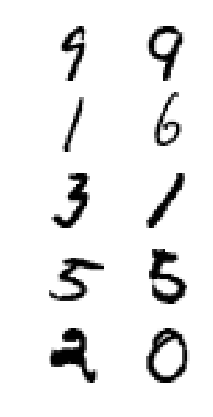

In [65]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

레이블을 확인해 보겠습니다(0은 "다른 것", 1은 "같은 것"을 의미합니다):

In [66]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

완벽하네요!

### 10.3.
_문제: 이 훈련 세트로 DNN을 훈련시키세요. 각각의 이미지 쌍에서 첫 번째 이미지는 DNN A에, 두 번째 이미지는 DNN B에 동시에 주입합니다. 전체 네트워크는 두 이미지가 같은 클래스인지 아닌지 구분하도록 점차 학습될 것입니다._

MNIST 테스트 세트에서 추출한 이미지 쌍으로 테스트 세트를 만듭니다:

In [67]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

이제 모델을 훈련시킵니다. `batch_size`가 크다는 것외에는 이 단계에 특별한 것은 없습니다. 배치 사이즈가 크지 않으면 모델이 학습을 실패하고 50% 정확도밖에 도달하지 못할 것입니다:

In [68]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "훈련 손실:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 훈련 손실: 0.4924257
0 테스트 정확도: 0.7861
1 훈련 손실: 0.33481342
2 훈련 손실: 0.29043424
3 훈련 손실: 0.25343397
4 훈련 손실: 0.21784273
5 훈련 손실: 0.17126976
5 테스트 정확도: 0.9185
6 훈련 손실: 0.20712842
7 훈련 손실: 0.17227527
8 훈련 손실: 0.16678247
9 훈련 손실: 0.16109405
10 훈련 손실: 0.12513137
10 테스트 정확도: 0.9425
11 훈련 손실: 0.1598237
12 훈련 손실: 0.124751955
13 훈련 손실: 0.11223439
14 훈련 손실: 0.11450212
15 훈련 손실: 0.09500929
15 테스트 정확도: 0.9532
16 훈련 손실: 0.11929634
17 훈련 손실: 0.0754429
18 훈련 손실: 0.11229495
19 훈련 손실: 0.13370793
20 훈련 손실: 0.11354699
20 테스트 정확도: 0.9596
21 훈련 손실: 0.06740806
22 훈련 손실: 0.0936298
23 훈련 손실: 0.09864689
24 훈련 손실: 0.111874945
25 훈련 손실: 0.073562324
25 테스트 정확도: 0.9675
26 훈련 손실: 0.07903241
27 훈련 손실: 0.04876441
28 훈련 손실: 0.086907074
29 훈련 손실: 0.06944222
30 훈련 손실: 0.06008898
30 테스트 정확도: 0.9663
31 훈련 손실: 0.10390249
32 훈련 손실: 0.053595282
33 훈련 손실: 0.031067856
34 훈련 손실: 0.05362943
35 훈련 손실: 0.046265054
35 테스트 정확도: 0.9701
36 훈련 손실: 0.067982085
37 훈련 손실: 0.032665566
38 훈련 손실: 0.035747916
39 훈련 손실: 0.0333373
40 훈련 손실: 0.041

좋습니다. 숫자 비교 작업에서 97.6% 정확도를 달성했습니다. 아주 나쁘지 않네요. 이 모델은 손글씨 숫자를 비교하는 능력을 갖추었습니다!

이 지식을 일반 MNIST 분류 문제에 사용할 수 있는지 확인해 보겠습니다.

### 10.4.
_문제: 이제 DNN A의 은닉층을 동결해서 재사용하고 10개의 뉴런으로 된 소프트맥스 출력 층을 추가한 새로운 DNN을 만듭니다. 이 네트워크를 분할 #2에 대해 훈련시켜보고 클래스당 500개의 이미지만으로도 높은 성능을 얻을 수 있는지 확인해보세요._

모델을 만드는 것은 매우 간단합니다. 하위층을 동결하는 방법이 많이 있습니다. 이 예제에서는 `tf.stop_gradient()` 함수를 사용하겠습니다. 미리 학습된 DNN A를 복원하기 위해 `Saver` 객체가 필요하고 최종 모델을 저장하기 위해 다른 `Saver` 객체가 필요합니다:

In [69]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

이제 훈련입니다! 모든 변수를 초기화하고(새 출력층의 변수를 포함하여), 미리 학습된 DNN A를 복원합니다. 다음에 작은 MNIST 데이터셋(5,000개 이미지)에 이 모델을 훈련시킵니다:

In [70]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 테스트 정확도: 0.9269
10 테스트 정확도: 0.9676
20 테스트 정확도: 0.9675
30 테스트 정확도: 0.9673
40 테스트 정확도: 0.9672
50 테스트 정확도: 0.9674
60 테스트 정확도: 0.9674
70 테스트 정확도: 0.9673
80 테스트 정확도: 0.9673
90 테스트 정확도: 0.9673


오 96.7% 정확도네요. 지금까지 훈련시킨 최고의 MNIST 모델은 아니지만 아주 작은 훈련 세트(숫자당 500개 이미지)를 사용한 것을 유념하세요. 전이 학습을 사용하지 않고 그냥 처음부터 학습시킨 DNN과 결과를 비교해 보겠습니다:

In [71]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [72]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 테스트 정확도: 0.8893
10 테스트 정확도: 0.9402
20 테스트 정확도: 0.9481
30 테스트 정확도: 0.9483
40 테스트 정확도: 0.9484
50 테스트 정확도: 0.9482
60 테스트 정확도: 0.9483
70 테스트 정확도: 0.9485
80 테스트 정확도: 0.9481
90 테스트 정확도: 0.9481
100 테스트 정확도: 0.9479
110 테스트 정확도: 0.9478
120 테스트 정확도: 0.9478
130 테스트 정확도: 0.9477
140 테스트 정확도: 0.9479


94.8% 정확도 밖에 안되네요. 전이 학습이 에러율를 5.2%에서 3.3%로 낮추어 주었습니다(36% 이상 에러가 감소했습니다). 더군다나 전이 학습을 사용한 모델은 10번의 에포크만에 96%의 정확도에 도달했습니다.

최종 결과: 전이 학습이 항상 좋은 결과를 내지는 않습니다(연습문제 9에서 보았듯이). 하지만 그렇지 않을 땐 아주 큰 차이를 만들 수 있습니다. 그러므로 꼭 시도해 보세요!